In [2]:
base_dir = './results/'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import dill
import skimage.io as io
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import zipfile

2024-05-06 23:30:41.983676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
tf.autograph.set_verbosity(0)

In [5]:
def n_filters(stage, fmap_base, fmap_max, fmap_decay):
  """Get the number of filters in a convolutional layer."""
  return int(min(fmap_max, fmap_base / 2.0 ** (stage * fmap_decay)))


def pixelwise_feature_norm(x, epsilon=1e-8):
  """Pixelwise feature normalization for the output of convolutional layers."""
  return x / K.sqrt(
      K.mean(K.square(x), axis=len(x.shape)-1, keepdims=True) + epsilon)


def layer_init_stddev(shape, gain=np.sqrt(2)):
  """Get the He initialization scaling term."""
  fan_in = np.prod(shape[:-1])
  return gain / np.sqrt(fan_in)


def Dense(x, units,
          use_wscale=False,
          gain=np.sqrt(2),
          name=None):
  """Build a densely connected layer."""
  if len(x.shape) > 2:
    x = K.reshape(x, shape=(-1, np.prod(x.shape[1:])))
  stddev = layer_init_stddev([x.shape[1], units], gain=gain)
  if use_wscale:
    weight_init = tf.keras.initializers.RandomNormal()
    x = tf.keras.layers.Dense(units, activation=None,
                              kernel_initializer=weight_init,
                              use_bias=False,
                              name=name)(x)
    x = tf.keras.layers.Lambda(
        lambda x: x * K.constant(stddev, dtype='float32'))(x)
    return x
  weight_init = tf.keras.initializers.RandomNormal(0.0, stddev)
  return tf.keras.layers.Dense(units, activation=None,
                               kernel_initializer=weight_init,
                               use_bias=False,
                               name=name)(x)


class Bias(tf.keras.layers.Layer):
  """Bias layer for applying the bias after weight scaling."""
  def __init__(self, shape, *args, **kwargs):
    super(Bias, self).__init__(*args, **kwargs)
    self.shape = shape
    self._config = {'shape': shape}
    self.b = self.add_weight('bias',
                             shape=shape,
                             initializer='zeros',
                             trainable=True)

  def call(self, x):
    """Call method for functional API."""
    return x + self.b


def Conv2D(x, filters, kernel,
           gain=np.sqrt(2),
           use_wscale=False,
           name=None,
           **unused_kwargs):
  """Build a 2D convolutional layer."""
  stddev = layer_init_stddev([kernel, kernel, x.shape[1], filters], gain=gain)
  if use_wscale:
    weight_init = tf.keras.initializers.RandomNormal()
    x = tf.keras.layers.Conv2D(filters, kernel,
                               strides=(1, 1),
                               padding='same',
                               kernel_initializer=weight_init,
                               use_bias=False,
                               activation=None,
                               name=name)(x)
    x = tf.keras.layers.Lambda(
        lambda x: x * K.constant(stddev, dtype='float32'))(x)
    return x
  weight_init = tf.keras.initializers.RandomNormal(0.0, stddev)
  return tf.keras.layers.Conv2D(filters, kernel,
                                strides=(1, 1),
                                padding='same',
                                kernel_initializer=weight_init,
                                use_bias=False,
                                activation=None,
                                name=name)(x)



class Lerp(tf.keras.layers.Layer):
  """A linear interpolation layer for fading in higher resolutions."""

  def __init__(self, t, *args, **kwargs):
    super(Lerp, self).__init__(*args, **kwargs)
    self.t = t

  def call(self, a, b, *args, **kwargs):
    """Call method for functional API."""
    return a + (b - a) * self.t


def resolution_label(res_log2):
  """Create an image resolution label."""
  return '{}x{}'.format(1 << res_log2, 1 << res_log2)

In [6]:
def G(latent_size=None,  # Dimensionality of latent space.
      fmap_base=8192,
      fmap_max=512,  # Max filters in each conv layer.
      fmap_decay=1.0,
      normalize_latents=True,  # Pixelwise normalize latent vector.
      use_wscale=True,  # Scale the weights with He init at runtime.
      use_pixel_norm=True,  # Use pixelwise normalization.
      use_leaky_relu=True,  # True = use LeakyReLU, False = use ReLU.
      num_channels=3,  # Number of output channels.
      resolution=64,  # Resolution of the output.
      **unused_kwargs):
  """Build the generator networks for each size."""
  if latent_size is None:
    latent_size = min(fmap_base, fmap_max)

  partial_nfilters = lambda n: n_filters(n, fmap_base, fmap_max, fmap_decay)

  opts = {
      'use_wscale': use_wscale,
      'use_pixel_norm': use_pixel_norm,
      'use_leaky_relu': use_leaky_relu,
  }

  # We can set the value of this during training with a callback.
  alpha = K.variable(0.0, dtype='float32', name='alpha')

  models = {}
  resolution_log2 = int(np.log2(resolution))

  for max_res_log2 in range(2, resolution_log2 + 1):
    latents_in = tf.keras.layers.Input(shape=(latent_size,), name='latents_in')
    x = latents_in
    if normalize_latents:
      x = pixelwise_feature_norm(x)
    x = G_block(x, 2, partial_nfilters, **opts)
    img = toRGB(x, num_channels, **opts, name='4x4_to_rgb')

    if max_res_log2 == 2:
      models['4x4'] = tf.keras.models.Model(latents_in, img)
      continue

    img_prev = img

    for res_log2 in range(3, max_res_log2 + 1):
      x = G_block(x, res_log2, partial_nfilters, **opts)
      if res_log2 == (max_res_log2 - 1):
        img_prev = toRGB(x, num_channels, **opts,
                         name='{}_to_rgb'.format(resolution_label(res_log2)))
      if res_log2 == max_res_log2:
        img = toRGB(x, num_channels, **opts,
                    name='{}_to_rgb'.format(resolution_label(res_log2)))
        img = Lerp(alpha)(tf.keras.layers.UpSampling2D()(img_prev), img)

    label = resolution_label(max_res_log2)
    models[label] = tf.keras.models.Model(latents_in, [img, img_prev])

  return models, alpha


def G_block(x, res_log2, n_filters,
            use_pixel_norm=False,
            use_wscale=False,
            use_leaky_relu=False,
            **unused_kwargs):
  """Build a block of the generator."""
  pn = lambda x: pixelwise_feature_norm(x) if use_pixel_norm else x
  act = (tf.keras.layers.LeakyReLU() if use_leaky_relu
         else tf.keras.layers.Activation('relu'))
  
  nf = n_filters(res_log2 - 1)

  if res_log2 == 2:
    # Start with dense layer.
    units = nf << 4
    x = Dense(x, units, gain=np.sqrt(2)/4, use_wscale=use_wscale,
              name='G_dense_head')
    x = K.reshape(x, [-1, 4, 4, nf])
    x = Bias([1, 1, nf], name='G_dense_head_bias')(x)
    x = pn(act(x))
    # Then the first convolutional layer.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale, name='4x4_conv')
    x = Bias([1, 1, nf], name='4x4_conv_bias')(x)
    return pn(act(x))
  else:
    res_label = resolution_label(res_log2)
    # Upsample the input.
    x = tf.keras.layers.UpSampling2D()(x)

    # Now 2 convolutional layers.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv0'.format(res_label))
    x = Bias([1, 1, nf], name='{}_conv0_bias'.format(res_label))(x)
    x = pn(act(x))

    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv1'.format(res_label))
    x = Bias([1, 1, nf], name='{}_conv1_bias'.format(res_label))(x)
    return pn(act(x))
  return x


def toRGB(x, channels,
          use_pixel_norm=False,
          use_wscale=False,
          use_leaky_relu=False,
          name=None,
          **unused_kwargs):
  """Convert a 4D tensor into the RGB color space."""
  pn = lambda x: pixelwise_feature_norm(x) if use_pixel_norm else x
  act = (tf.keras.layers.LeakyReLU() if use_leaky_relu
         else tf.keras.layers.Activation('relu'))
  x = Conv2D(x, filters=channels, kernel=1, gain=1, use_wscale=use_wscale,
             name=name)
  bias_name = None if name is None else name + '_bias'
  x = Bias([1, 1, channels], name=bias_name)(x)
  return tf.keras.layers.Activation('sigmoid')(x)

In [7]:
def D(num_channels=3,  # Number of channels images have.
      resolution=64,  # Max image resolution.
      fmap_base=8192,
      fmap_max=512,  # Max filters in each conv layer.
      fmap_decay=1.0,
      use_wscale=True,  # Scale the weights with He init at runtime.
      mbstd_group_size=4, # Group size for minibatch stddev layer.
      **unused_kwargs):
  """Build the discriminator networks for each size."""
  partial_nfilters = lambda n: n_filters(n, fmap_base, fmap_max, fmap_decay)
  resolution_log2 = int(np.log2(resolution))
  opts = {
      'use_wscale': use_wscale,
      'mbstd_group_size': mbstd_group_size,
  }

  # We can set the value of this during training with a callback.
  alpha = K.variable(0.0, dtype='float32', name='alpha')
  img_ins = {
      resolution_label(res_log2): tf.keras.layers.Input(
          shape=(1 << res_log2, 1 << res_log2, num_channels))
      for res_log2 in range(2, resolution_log2 + 1)
  }
  outputs = {}

  for max_res_log2 in range(2, resolution_log2 + 1):
    label = resolution_label(max_res_log2)
    x = img_ins[label]
    x = fromRGB(x, filters=partial_nfilters(max_res_log2 - 1),
                name='{}_from_rgb'.format(label), **opts)
    for res_log2 in range(max_res_log2, 2, -1):
      x = D_block(x, res_log2, partial_nfilters, **opts)
      if res_log2 == max_res_log2:
        prev_label = resolution_label(res_log2 - 1)
        prev_img = img_ins[prev_label]
        y = fromRGB(prev_img, partial_nfilters(res_log2 - 2),
                    name='{}_from_rgb'.format(prev_label), **opts)
        x = Lerp(alpha)(y, x)
    outputs[label] = D_block(x, 2, partial_nfilters, **opts)

  models = {}
  for res_log2 in range(2, resolution_log2 + 1):
    label = resolution_label(res_log2)
    ins = [img_ins[label]]
    if res_log2 > 2:
      ins.append(img_ins[resolution_label(res_log2 - 1)])
    models[label] = tf.keras.models.Model(ins, outputs[label])
  
  return models, alpha


def fromRGB(x, filters,
            use_wscale=False,
            name=None,
            **unused_kwargs):
  """First covolutional layer after an RGB layer."""
  x = Conv2D(x, filters=filters, kernel=1, use_wscale=use_wscale, name=name)
  bias_name = None if name is None else name + '_bias'
  x = Bias([1, 1, filters], name=bias_name)(x)
  return tf.keras.layers.LeakyReLU()(x)


def D_block(x, res_log2, n_filters,
            mbstd_group_size=4,
            use_wscale=False,
            **unused_kwargs):
  """Build a block of the discriminator conv net."""
  act = tf.keras.layers.LeakyReLU()
  nf = n_filters(res_log2 - 1)
  if res_log2 == 2:
    # Apply minibatch stddev layer.
    x = MinibatchStddev(x, mbstd_group_size)

    # Then a convolutional layer.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale, name='4x4_conv')
    x = Bias([1, 1, nf], name='4x4_conv_bias')(x)
    x = act(x)

    # Now we add the dense head to the discriminator.
    nf = n_filters(0)
    x = tf.keras.layers.Flatten(data_format='channels_last')(x)
    x = Dense(x, nf, use_wscale=use_wscale, name='D_dense_head')
    x = Bias([nf], name='D_dense_head_bias')(x)
    x = act(x)
    x = Dense(x, 1, gain=1, use_wscale=use_wscale, name='D_logit')
    x = Bias([1], name='D_logit_bias')(x)
  else:
    label = resolution_label(res_log2)

    # First convolutional layer.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv0'.format(label))
    x = Bias([1, 1, nf], name='{}_conv0_bias'.format(label))(x)
    x = act(x)

    # Second convolutional layer.
    nf = n_filters(res_log2 - 2)
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv1'.format(label))
    x = Bias([1, 1, nf], name='{}_conv1_bias'.format(label))(x)
    x = act(x)
    
    # And downscale.
    x = Downscale2D(x)
  return x


def MinibatchStddev(x, group_size):
  """Contatenate the stddev of the minibatch to the output of a conv layer."""
  y = K.reshape(x, [group_size, -1, *x.shape[1:]])
  y = K.cast(y, 'float32')
  y -= K.mean(y, axis=0, keepdims=True)
  y = K.mean(K.square(y), axis=0)
  y = K.cast(y, x.dtype)
  y = K.tile(y, [group_size, 1, 1, 1])
  return K.concatenate([x, y], axis=1)


def Downscale2D(x):
  """Downscale layer scales an image down 2x."""
  return tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='valid',
                                          data_format='channels_last')(x)

In [8]:
class WGANGP(tf.keras.models.Model):
  """
  A single WGAN-GP network.

  This implements the training objective for a single resolution
  of ProGAN. This model is applied iteratively over each resolution
  with a fresh optimizer. The motivation of ProGAN is to treat each
  resolution as an entirely different learning task, and uses the
  pretrained lower layers for transfer learning.

  In order to properly implement the gradient penalty loss term
  with TensorFlow 2.x, we need to extend the Keras model with
  our own custom training method. Since we have to use this model
  extension, we can also encapsulate the "fading in" the next
  resolutions.
  
  """

  def __init__(self,
               resolution,
               G,
               D,
               G_optimizer,
               D_optimizer,
               batch_size,
               latent_size,
               G_alpha=None,
               D_alpha=None,
               gradient_weight=10.0,
               D_repeat=1,
               *args, **kwargs):
    super(WGANGP, self).__init__(*args, **kwargs)
    self.resolution = resolution
    self.G = G
    self.D = D
    self.G_optimizer = G_optimizer
    self.D_optimizer = D_optimizer
    self.batch_size = batch_size
    self.latent_size = latent_size
    self.gradient_weight = gradient_weight

    self.G_alpha = G_alpha
    self.D_alpha = D_alpha

    self.D_repeat = D_repeat

  def compute_D_loss(self, real_imgs):
    """Compute discriminator loss terms."""

    # Generate the image at lower resolution for layer fading.
    latents_in = np.random.normal(size=(self.batch_size, self.latent_size))
    if self.resolution > 4:
      fake_imgs = self.G(latents_in)
      interp_imgs = [self.interpolate_imgs(real_imgs[i], fake_imgs[i])
                     for i in range(2)]
    else:
      fake_imgs = [self.G(latents_in)]
      interp_imgs = [self.interpolate_imgs(real_imgs[0], fake_imgs[0])]
    
    real_pred = self.D(real_imgs)
    fake_pred = self.D(fake_imgs)

    real_loss = tf.reduce_mean(real_pred)
    fake_loss = -tf.reduce_mean(fake_pred)
    gp_loss = self.gradient_penalty(interp_imgs)

    return real_loss, fake_loss, gp_loss

  def interpolate_imgs(self, real_img, fake_img):
    """Interpolate real and fake images for GP loss calculation."""
    w = tf.random.uniform([self.batch_size, 1, 1, 1], 0.0, 1.0)
    return (w * real_img) + ((1.0 - w) * fake_img)

  def gradient_penalty(self, interp_imgs):
    """Compute gradient penalty loss."""
    with tf.GradientTape() as tape:
      tape.watch(interp_imgs)
      interp_pred = self.D(interp_imgs)
    grads = tape.gradient(interp_pred, interp_imgs)[0]
    ddx = K.sqrt(K.sum(tf.square(grads), axis=np.arange(1, len(grads.shape))))
    loss = tf.reduce_mean(tf.square(1.0 - ddx))
    return self.gradient_weight * loss

  def compute_G_loss(self):
    """Compute G loss."""
    latents_in = np.random.normal(size=(self.batch_size, self.latent_size))

    # For fading in the new layer.
    if self.resolution > 4:
      fake_imgs = self.G(latents_in)
    else:
      fake_imgs = [self.G(latents_in)]

    fake_pred = self.D(fake_imgs)
    return tf.reduce_mean(fake_pred)

  def compute_D_gradients(self, real_imgs, print_loss=False):
    """Compute the discriminator loss gradients."""
    with tf.GradientTape() as tape:
      D_loss_real, D_loss_fake, D_loss_gp = self.compute_D_loss(real_imgs)
      D_loss = D_loss_real + D_loss_fake + D_loss_gp

    if print_loss:
      print('D Loss: R: {:04f} F: {:04f} GP: {:04f}'.format(
          D_loss_real, D_loss_fake, D_loss_gp))
    
    return tape.gradient(D_loss, self.D.trainable_variables)

  def compute_G_gradients(self, print_loss=False):
    """Compute the generator loss gradients."""
    with tf.GradientTape() as tape:
      G_loss = self.compute_G_loss()

    if print_loss:
      print('G Loss: {:04f}'.format(G_loss))

    return tape.gradient(G_loss, self.G.trainable_variables)

  def train_on_batch(self, X_batch, alpha=None, print_loss=False):
    """Train on a single batch of data."""
    if alpha is not None:
      K.set_value(self.G_alpha, alpha)
      K.set_value(self.D_alpha, alpha)

    for _ in range(self.D_repeat):
      D_grads = self.compute_D_gradients(X_batch, print_loss)
      self.D_optimizer.apply_gradients(zip(D_grads, self.D.trainable_variables))
    
    G_grads = self.compute_G_gradients(print_loss)
    self.G_optimizer.apply_gradients(zip(G_grads, self.G.trainable_variables))


def average_gradients(all_grads):
  """Take the average of gradients over multiple batches."""
  grad_table = {}
  for grads in all_grads:
    for i, g in enumerate(grads):
      try:
        grad_table[i].append(g)
      except:
        grad_table[i] = [g]

  return [tf.reduce_mean(tf.stack(grad_table[i]), axis=0)
          for i in sorted(grad_table.keys())]

In [9]:
class ProGAN:
  """Collection of WGAN-GP networks for each resolution model."""

  def __init__(self,
               # ProGAN parameters
               batch_size=64,
               learning_rate=0.001,
               learning_rate_decay=0.8,
               gradient_weight=10.0,
               D_repeat=1,
               # Generator parameters
               latent_size=None,
               normalize_latents=True,
               use_leaky_relu=True,
               # Discriminator parameters
               mbstd_group_size=4,
               # Shared parameters
               fmap_base=8192,
               fmap_max=512,
               fmap_decay=1.0,
               num_channels=3,
               resolution=128,
               use_pixel_norm=True,
               use_wscale=True,
               **unused_kwargs):
    if latent_size is None:
      latent_size = min(fmap_base, fmap_max)

    self.latent_size = latent_size
    self.batch_size = batch_size
    self.G, self.alpha_G = G(latent_size=latent_size,
                             fmap_base=fmap_base,
                             fmap_max=fmap_max,
                             fmap_decay=fmap_decay,
                             normalize_latents=normalize_latents,
                             use_wscale=use_wscale,
                             use_pixel_norm=use_pixel_norm,
                             use_leaky_relu=use_leaky_relu,
                             num_channels=num_channels,
                             resolution=resolution)
    self.D, self.alpha_D = D(num_channels=num_channels,
                             resolution=resolution,
                             fmap_base=fmap_base,
                             fmap_max=fmap_max,
                             fmap_decay=fmap_decay,
                             use_pixel_norm=use_pixel_norm,
                             use_wscale=use_wscale,
                             mbstd_group_size=mbstd_group_size)
    
    opt = lambda lr: tf.keras.optimizers.Adam(lr, beta_1=0.0,
                                              beta_2=0.99, epsilon=1e-8)
    self.models = {
        resolution_label(res_log2): WGANGP(
            1 << res_log2,
            self.G[resolution_label(res_log2)],
            self.D[resolution_label(res_log2)],
            opt(learning_rate * (learning_rate_decay ** (res_log2 - 2))),
            opt(learning_rate * (learning_rate_decay ** (res_log2 - 2))),
            batch_size, 
            latent_size,
            self.alpha_G,
            self.alpha_D,
            gradient_weight,
            D_repeat)
        for res_log2 in range(2, int(np.log2(resolution)) + 1)
    }

  def transfer_previous_resolution_weights(self, resolution):
    """Load the weights from the model for the previous resolution."""
    cur_res_log2 = int(np.log2(resolution))
    prev_label = resolution_label(cur_res_log2 - 1)
    cur_label = resolution_label(cur_res_log2)

    # Copy model weights

    prev_weights_G = {}
    for layer in self.G[prev_label].layers:
      w = layer.get_weights()
      if w:
        prev_weights_G[layer.name] = w
    
    prev_weights_D = {}
    for layer in self.D[prev_label].layers:
      w = layer.get_weights()
      if w:
        prev_weights_D[layer.name] = w

    total_params = 0

    for layer in self.G[cur_label].layers:
      if layer.name in prev_weights_G:
        w = np.array(prev_weights_G[layer.name])
        layer.set_weights(prev_weights_G[layer.name])
        total_params += np.prod(w.shape)

    for layer in self.D[cur_label].layers:
      if layer.name in prev_weights_D:
        w = np.array(prev_weights_D[layer.name])
        layer.set_weights(w)
        total_params += np.prod(w.shape)

    print('Copied {} parameters to the higher resolution model.'.format(
        total_params))
    
  def save(self, resolution, checkpoint_path):
    """Save model weights and optimizer state."""
    resolution_log2 = int(np.log2(resolution))
    label = resolution_label(resolution_log2)

    self.G[label].save_weights(os.path.join(checkpoint_path, 'G_weights.ckpt'))
    self.D[label].save_weights(os.path.join(checkpoint_path, 'D_weights.ckpt'))

    model = self.models[label]
    dill.dump(model.G_optimizer,
                open(os.path.join(checkpoint_path, 'G_opt.pkl'), 'wb'))
    dill.dump(model.D_optimizer,
                open(os.path.join(checkpoint_path, 'D_opt.pkl'), 'wb'))

  def load(self, resolution, checkpoint_path, load_optimizer_state=False):
    """Load model weights and optimizer state."""
    resolution_log2 = int(np.log2(resolution))
    label = resolution_label(resolution_log2)

    self.G[label].load_weights(os.path.join(checkpoint_path, 'G_weights.ckpt'))
    self.D[label].load_weights(os.path.join(checkpoint_path, 'D_weights.ckpt'))
    
    if load_optimizer_state:
      model = self.models[label]
      model.G_optimizer = dill.load(
          open(os.path.join(checkpoint_path, 'G_opt.pkl'), 'rb'))
      model.D_optimizer = dill.load(
          open(os.path.join(checkpoint_path, 'D_opt.pkl'), 'rb'))

In [10]:
with zipfile.ZipFile('cats_64x64.zip', 'r') as z:
    z.extractall('data/')

In [11]:
def augment(x, image_size):
    """Data augmentation"""
    x = tf.image.random_flip_left_right(x)
    return tf.cast(x, tf.float32) / 255.0


@tf.autograph.experimental.do_not_convert
def images_dataset(image_size, batch_size):
    """Create a training set of img_size x img_size photographs."""
    return tf.keras.preprocessing.image_dataset_from_directory(
      'data',
      label_mode=None,
      batch_size=batch_size,
      interpolation='nearest',
      image_size=(image_size, image_size)).map(lambda x: augment(x, image_size))

In [12]:
def plot_real_images(resolution,
                     n_to_show=20,
                     n_rows=5,
                     figsize=(8, 10)):
    """Plot a set of real images."""
    X_train = images_dataset(resolution, n_to_show).as_numpy_iterator()
    X_batch = next(X_train)
    fig = plt.figure(figsize=figsize)
  
    for i, x in enumerate(X_batch):
        ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
        ax.axis('off')
        ax.imshow(x.squeeze(), interpolation='antialiased')

Found 17432 files belonging to 1 classes.


2024-05-06 23:31:14.020717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-06 23:31:14.021002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


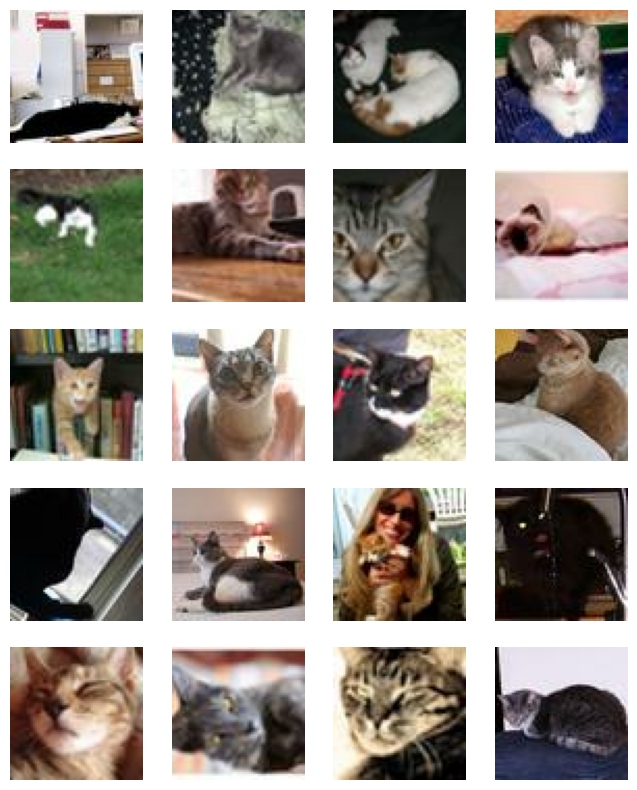

In [13]:
plot_real_images(64)

In [14]:
def training_datasets(resolution_log2, batch_size):
  """Build the training datasets up to a maximum resolution."""
  if resolution_log2 == 2:
    return [images_dataset(4, batch_size).as_numpy_iterator()]
  size = 1 << resolution_log2
  datasets = [images_dataset(size, batch_size)]
  datasets.append(datasets[0].map(
      lambda x: tf.image.resize(x, (size >> 1, size >> 1))))
  return [ds.as_numpy_iterator() for ds in datasets]


def training_data(resolution, batch_size):
  """Build a generator for training the discriminator."""
  resolution_log2 = int(np.log2(resolution))
  datasets = training_datasets(resolution_log2, batch_size)
  while True:
    try:
      data = tuple([next(ds) for ds in datasets])
      if len(data[0]) != batch_size:
        datasets = training_datasets(resolution_log2, batch_size)
        data = tuple([next(ds) for ds in datasets])
      yield data
    except StopIteration:
      datasets = training_datasets(resolution_log2, batch_size)

In [15]:
def train_progan(gan, resolution,
                 total_kimg=1000,  # 1000s of images to show D.
                 transition_kimg=500,  # 1000s of images to fade in new layer.
                 checkpoint_path=None,  # Path to save weights.
                 print_every_n_batches=25,
                 alpha_min=0.0,  # Min and max for the mixing factor.
                 alpha_max=1.0,
                 save_every_n_batches=1000,
                 snapshot_every_n_batches=500,
                 **unused_kwargs):
  """Train ProGAN at a specific resolution."""
  batch_size = gan.batch_size

  total_img = 0
  n_batches = (total_kimg * 1000) // batch_size
  X_train = training_data(resolution, batch_size)

  resolution_log2 = int(np.log2(resolution))
  label = resolution_label(resolution_log2)
  alpha_batch = None

  for i in range(1, n_batches + 1):
    total_img += batch_size

    if resolution > 4 and transition_kimg != 0:
      alpha_batch = alpha_min
      alpha_batch += ((alpha_max - alpha_min)
                      * float(total_img) / (transition_kimg * 1000))
      alpha_batch = max(alpha_min, alpha_batch)
      alpha_batch = min(alpha_max, alpha_batch)
    elif resolution > 4:
      alpha_batch = 1.0

    X_batch = next(X_train)
    if alpha_batch is not None:
      X_batch = (fade_new_resolution(X_batch[0], alpha_batch), X_batch[1])
    
    print_loss = (i % print_every_n_batches) == 0
    if print_loss:
      print('Batch: {} / {}'.format(i, n_batches))
      if alpha_batch is not None:
        print('Alpha: {}'.format(alpha_batch))

    gan.models[label].train_on_batch(X_batch,
                                     alpha=alpha_batch,
                                     print_loss=print_loss)

    if (i % save_every_n_batches == 0 or i == n_batches) and checkpoint_path:
      print('Saving weights...')
      gan.save(resolution, checkpoint_path)
      print('Done.')
    
    # Every snaphot_every_n_batches batches we plot a snapshot of the model's
    # progress. Since evaluating the performance based on loss has been
    # difficult while I was experimenting with hyperparameters on my own.
    # The best way to evaluate the model is sampling G at each distribution.
    if i % snapshot_every_n_batches == 0:
      plot_generated_images(gan, resolution, alpha=alpha_batch)
      plt.show()


def plot_generated_images(gan,
                          resolution,
                          latents_in=None,
                          n_to_show=20,
                          n_rows=5,
                          figsize=(8, 10),
                          alpha=1.0):
  """Plot images made by a generator."""
  resolution_log2 = int(np.log2(resolution))

  latents_in = np.random.normal(size=(n_to_show, gan.latent_size))
  X_batch = gan.G[resolution_label(resolution_log2)].predict(latents_in)
  if resolution > 4:
    X_batch, X_prev = X_batch

  if alpha is not None and alpha != 1.0:
    X_prev = np.array(X_prev).repeat(2, axis=1).repeat(2, axis=2)
    X_batch = (alpha * X_batch) + ((1.0 - alpha) * X_prev)
  
  fig = plt.figure(figsize=(8, 10))

  for i, x in enumerate(X_batch):
    ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
    ax.axis('off')
    ax.imshow(np.clip(np.array(x).squeeze(), 0.0, 1.0),
              interpolation='antialiased')


def fade_new_resolution(x, alpha):
  """Just-in-time preprocessing of the real images adds crossfade between levels of detail."""
  s = x.shape
  y = tf.reshape(x, [-1, s[1] // 2, 2, s[2] // 2, 2, s[3]])
  y = tf.reduce_mean(y, axis=(2, 4))
  y = tf.keras.layers.UpSampling2D()(y)
  y = tf.reshape(y, [-1, *s[1:]])
  return y + (x - y) * alpha

In [16]:
latents_test = np.random.normal(size=(64, 512))

Found 17432 files belonging to 1 classes.


2024-05-06 23:31:28.097532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-06 23:31:28.097823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


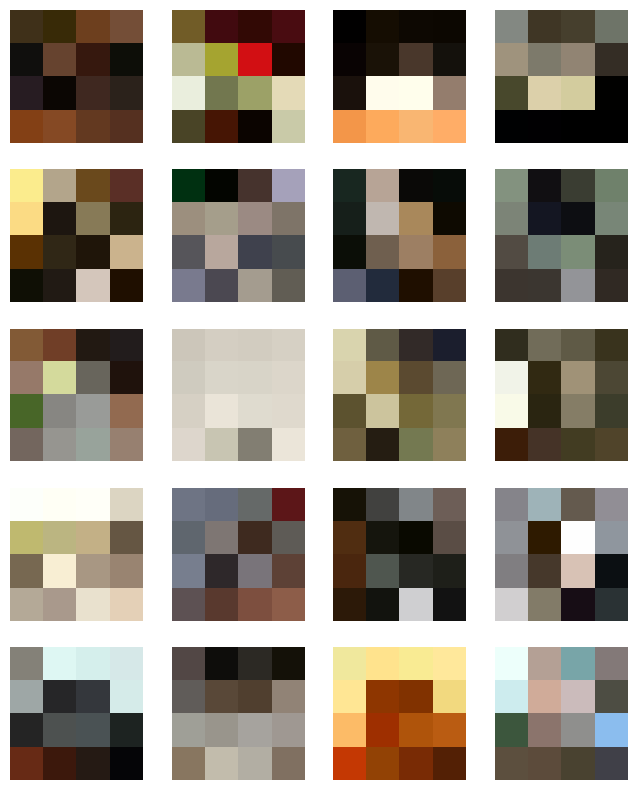

In [17]:
plot_real_images(4)

In [18]:
gan = ProGAN()

Found 17432 files belonging to 1 classes.


2024-05-05 17:27:47.272137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 17:27:47.272418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 25 / 15625
D Loss: R: 0.016256 F: 0.333244 GP: 4.771654
G Loss: -0.370770
Batch: 50 / 15625
D Loss: R: 0.068061 F: 0.938635 GP: 2.808882
G Loss: -1.138777
Batch: 75 / 15625
D Loss: R: 0.340227 F: 0.740409 GP: 2.290236
G Loss: -0.719784
Batch: 100 / 15625
D Loss: R: 0.620364 F: 1.057365 GP: 0.310474
G Loss: -0.982407
Batch: 125 / 15625
D Loss: R: 0.748128 F: 1.036287 GP: 0.135721
G Loss: -1.069070
Batch: 150 / 15625
D Loss: R: 0.810717 F: 0.985611 GP: 0.108266
G Loss: -0.978592
Batch: 175 / 15625
D Loss: R: 0.833176 F: 0.676697 GP: 0.091804
G Loss: -0.679536
Batch: 200 / 15625
D Loss: R: 0.667362 F: 0.685248 GP: 0.057965
G Loss: -0.663784
Batch: 225 / 15625
D Loss: R: -0.141868 F: 1.216226 GP: 0.046001
G Loss: -1.234197
Batch: 250 / 15625
D Loss: R: -1.063304 F: 1.563949 GP: 0.024605
G Loss: -1.598159
Found 17432 files belonging to 1 classes.


2024-05-05 17:34:23.187407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 17:34:23.187719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 275 / 15625
D Loss: R: -0.136782 F: 0.874956 GP: 0.009711
G Loss: -0.771490
Batch: 300 / 15625
D Loss: R: 0.614097 F: 0.144019 GP: 0.021321
G Loss: -0.134625
Batch: 325 / 15625
D Loss: R: -0.017916 F: 0.396866 GP: 0.002836
G Loss: -0.363687
Batch: 350 / 15625
D Loss: R: 0.066758 F: 0.793846 GP: 0.022272
G Loss: -0.781189
Batch: 375 / 15625
D Loss: R: 0.009777 F: 0.611778 GP: 0.010131
G Loss: -0.626354
Batch: 400 / 15625
D Loss: R: -0.382528 F: 0.601163 GP: 0.001883
G Loss: -0.578929
Batch: 425 / 15625
D Loss: R: -0.336193 F: 0.014256 GP: 0.009207
G Loss: 0.029494
Batch: 450 / 15625
D Loss: R: -0.392012 F: 0.562715 GP: 0.016721
G Loss: -0.512470
Batch: 475 / 15625
D Loss: R: -0.496974 F: -0.357045 GP: 0.034015
G Loss: 0.415734
Batch: 500 / 15625
D Loss: R: -2.501888 F: 1.606341 GP: 0.147855
G Loss: -1.612215
1/1 [==============================] - 0s 100ms/step


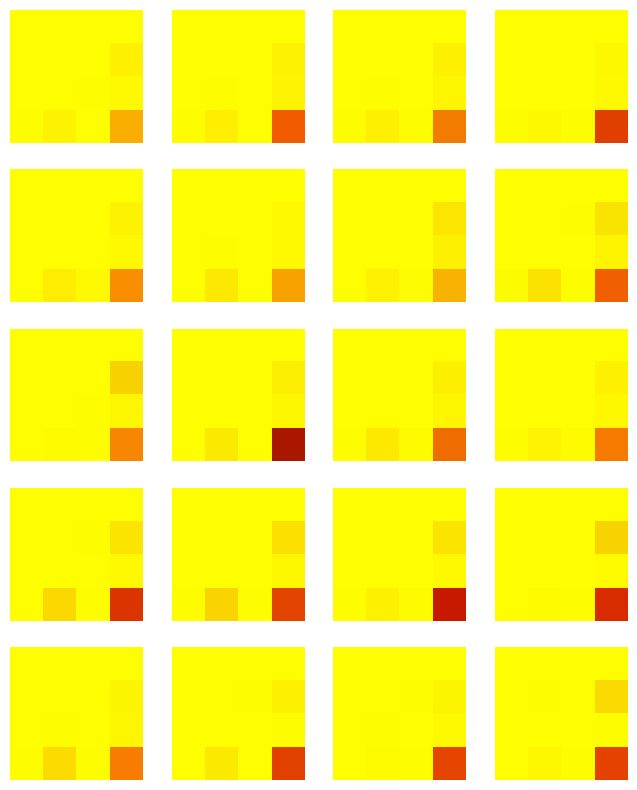

Batch: 525 / 15625
D Loss: R: -3.076328 F: 1.556401 GP: 0.080023
G Loss: -1.632268
Found 17432 files belonging to 1 classes.


2024-05-05 17:41:02.554014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 17:41:02.554280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 550 / 15625
D Loss: R: -4.737412 F: 3.815273 GP: 0.028649
G Loss: -3.562443
Batch: 575 / 15625
D Loss: R: -3.738807 F: 0.603429 GP: 0.109806
G Loss: -0.786187
Batch: 600 / 15625
D Loss: R: 0.793499 F: -5.376501 GP: 0.622178
G Loss: 6.121584
Batch: 625 / 15625
D Loss: R: -4.090671 F: 4.877676 GP: 0.156372
G Loss: -5.486845
Batch: 650 / 15625
D Loss: R: -4.064255 F: 2.532565 GP: 0.160060
G Loss: -1.426034
Batch: 675 / 15625
D Loss: R: -7.330545 F: 5.053029 GP: 0.091351
G Loss: -5.308694
Batch: 700 / 15625
D Loss: R: -8.177872 F: 10.010752 GP: 0.088202
G Loss: -9.238719
Batch: 725 / 15625
D Loss: R: 1.062475 F: -5.926548 GP: 0.629176
G Loss: 5.951457
Batch: 750 / 15625
D Loss: R: -6.635293 F: 6.750288 GP: 0.045060
G Loss: -6.948784
Batch: 775 / 15625
D Loss: R: -10.110176 F: 7.526690 GP: 0.131831
G Loss: -7.503648
Batch: 800 / 15625
D Loss: R: 0.560241 F: -3.192690 GP: 0.787217
G Loss: 1.130619
Found 17432 files belonging to 1 classes.


2024-05-05 17:47:46.143610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 17:47:46.143895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 825 / 15625
D Loss: R: -10.419584 F: 8.493587 GP: 0.072281
G Loss: -8.388433
Batch: 850 / 15625
D Loss: R: -6.312864 F: 6.211907 GP: 0.086173
G Loss: -6.643679
Batch: 875 / 15625
D Loss: R: -8.100784 F: 7.054191 GP: 0.035109
G Loss: -7.342208
Batch: 900 / 15625
D Loss: R: -5.758647 F: 5.994510 GP: 0.056751
G Loss: -6.337536
Batch: 925 / 15625
D Loss: R: -6.422206 F: 6.323556 GP: 0.048093
G Loss: -6.531192
Batch: 950 / 15625
D Loss: R: -7.300883 F: 7.000581 GP: 0.038688
G Loss: -7.227419
Batch: 975 / 15625
D Loss: R: -6.723362 F: 6.863624 GP: 0.022407
G Loss: -6.568254
Batch: 1000 / 15625
D Loss: R: -6.194767 F: 6.406963 GP: 0.036919
G Loss: -6.263361
Saving weights...
Done.
1/1 [==============================] - 0s 21ms/step


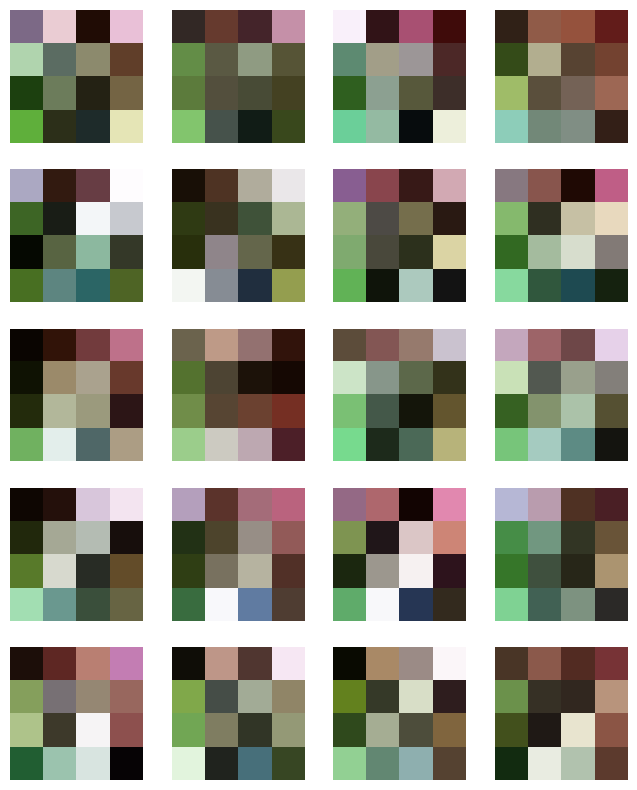

Batch: 1025 / 15625
D Loss: R: -6.270625 F: 6.448112 GP: 0.050073
G Loss: -6.359032
Batch: 1050 / 15625
D Loss: R: -6.025578 F: 6.262212 GP: 0.066984
G Loss: -5.904933
Batch: 1075 / 15625
D Loss: R: -6.148055 F: 6.210594 GP: 0.047603
G Loss: -6.394351
Found 17432 files belonging to 1 classes.


2024-05-05 17:54:29.752434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 17:54:29.752756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 1100 / 15625
D Loss: R: -6.275637 F: 6.382171 GP: 0.043621
G Loss: -6.168195
Batch: 1125 / 15625
D Loss: R: -5.859819 F: 6.087191 GP: 0.043144
G Loss: -6.381112
Batch: 1150 / 15625
D Loss: R: -6.352592 F: 6.628290 GP: 0.167606
G Loss: -6.303497
Batch: 1175 / 15625
D Loss: R: -7.028540 F: 7.027780 GP: 0.046304
G Loss: -7.077350
Batch: 1200 / 15625
D Loss: R: -7.014939 F: 7.323232 GP: 0.027326
G Loss: -7.188458
Batch: 1225 / 15625
D Loss: R: -6.697534 F: 6.783654 GP: 0.020891
G Loss: -6.863197
Batch: 1250 / 15625
D Loss: R: -6.724156 F: 6.860458 GP: 0.027114
G Loss: -6.877910
Batch: 1275 / 15625
D Loss: R: -6.171205 F: 6.314357 GP: 0.026364
G Loss: -7.048974
Batch: 1300 / 15625
D Loss: R: -6.327844 F: 6.516913 GP: 0.108551
G Loss: -5.943010
Batch: 1325 / 15625
D Loss: R: -6.377712 F: 6.569707 GP: 0.075928
G Loss: -6.727559
Batch: 1350 / 15625
D Loss: R: -7.118414 F: 7.202382 GP: 0.013834
G Loss: -6.611586
Found 17432 files belonging to 1 classes.


2024-05-05 18:01:11.112015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 18:01:11.112276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 1375 / 15625
D Loss: R: -7.046713 F: 7.326898 GP: 0.035924
G Loss: -7.037860
Batch: 1400 / 15625
D Loss: R: -6.690964 F: 7.001718 GP: 0.038455
G Loss: -6.788616
Batch: 1425 / 15625
D Loss: R: -6.640505 F: 6.780990 GP: 0.066117
G Loss: -7.012450
Batch: 1450 / 15625
D Loss: R: -6.921164 F: 7.045399 GP: 0.058098
G Loss: -6.900188
Batch: 1475 / 15625
D Loss: R: -6.970083 F: 7.038980 GP: 0.070931
G Loss: -7.449256
Batch: 1500 / 15625
D Loss: R: -7.763586 F: 7.939501 GP: 0.056971
G Loss: -7.210246
1/1 [==============================] - 0s 22ms/step


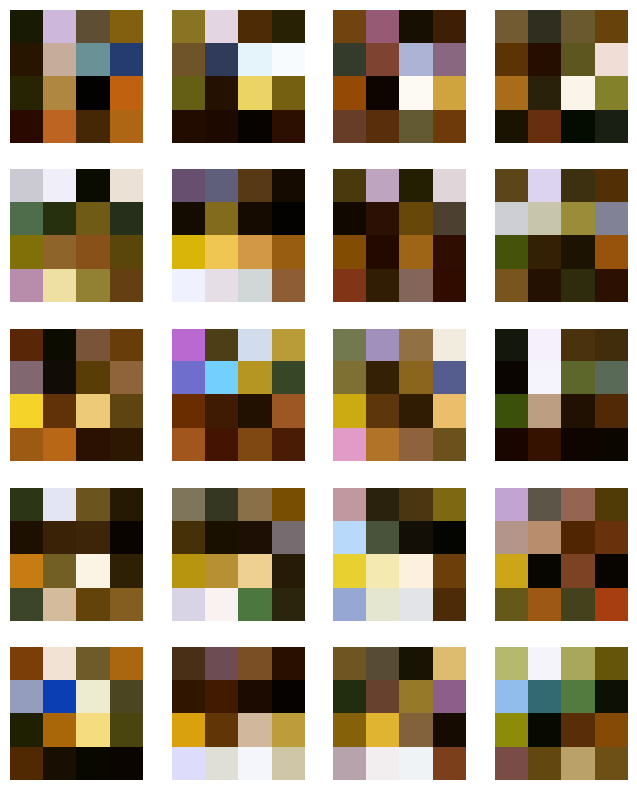

Batch: 1525 / 15625
D Loss: R: -7.571583 F: 7.769016 GP: 0.085120
G Loss: -7.802277
Batch: 1550 / 15625
D Loss: R: -7.957610 F: 8.222054 GP: 0.083494
G Loss: -7.932769
Batch: 1575 / 15625
D Loss: R: -8.251401 F: 8.498811 GP: 0.070510
G Loss: -8.606692
Batch: 1600 / 15625
D Loss: R: -8.480624 F: 8.561245 GP: 0.223111
G Loss: -9.020619
Batch: 1625 / 15625
D Loss: R: -9.111803 F: 9.226859 GP: 0.029498
G Loss: -8.909091
Found 17432 files belonging to 1 classes.


2024-05-05 18:07:52.377916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 18:07:52.378175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 1650 / 15625
D Loss: R: -8.909866 F: 9.102371 GP: 0.151225
G Loss: -9.411163
Batch: 1675 / 15625
D Loss: R: -8.968080 F: 9.293787 GP: 0.161419
G Loss: -8.972631
Batch: 1700 / 15625
D Loss: R: -9.314709 F: 9.537689 GP: 0.061172
G Loss: -8.896801
Batch: 1725 / 15625
D Loss: R: -8.887867 F: 9.022986 GP: 0.401946
G Loss: -9.109426
Batch: 1750 / 15625
D Loss: R: -9.218969 F: 9.301048 GP: 0.123272
G Loss: -10.097829
Batch: 1775 / 15625
D Loss: R: -9.993022 F: 10.463365 GP: 0.097543
G Loss: -10.252728
Batch: 1800 / 15625
D Loss: R: -9.863822 F: 9.984316 GP: 0.087404
G Loss: -10.178867
Batch: 1825 / 15625
D Loss: R: -10.100328 F: 10.335502 GP: 0.161518
G Loss: -10.157812
Batch: 1850 / 15625
D Loss: R: -10.264460 F: 10.361816 GP: 0.141937
G Loss: -10.911985
Batch: 1875 / 15625
D Loss: R: -10.223828 F: 10.355701 GP: 0.098967
G Loss: -10.128900
Batch: 1900 / 15625
D Loss: R: -10.996770 F: 11.129110 GP: 0.047902
G Loss: -10.539306
Found 17432 files belonging to 1 classes.


2024-05-05 18:14:34.995251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 18:14:34.995514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 1925 / 15625
D Loss: R: -11.611433 F: 11.827989 GP: 0.179639
G Loss: -12.031736
Batch: 1950 / 15625
D Loss: R: -12.094281 F: 12.316745 GP: 0.078190
G Loss: -11.619568
Batch: 1975 / 15625
D Loss: R: -11.483177 F: 11.849995 GP: 0.188523
G Loss: -12.350367
Batch: 2000 / 15625
D Loss: R: -11.139149 F: 11.282037 GP: 0.146332
G Loss: -11.229424
Saving weights...
Done.
1/1 [==============================] - 0s 22ms/step


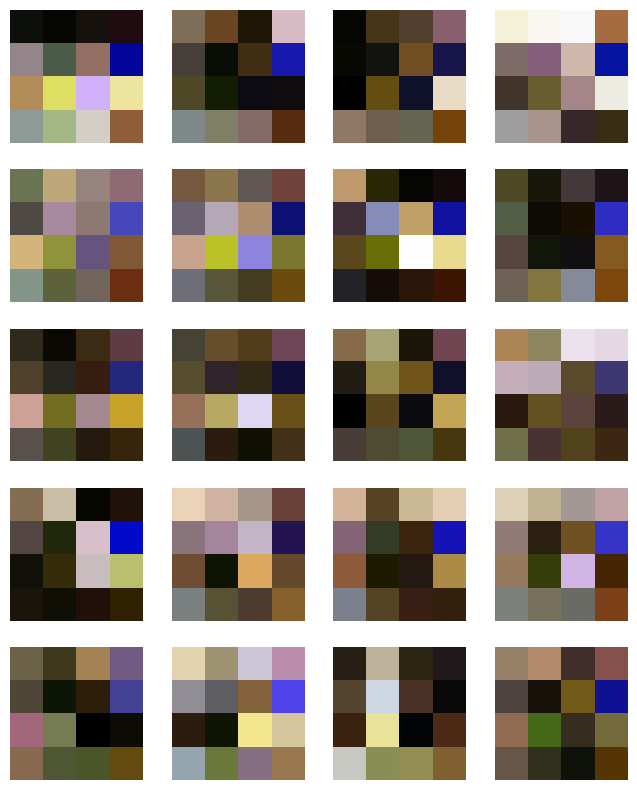

Batch: 2025 / 15625
D Loss: R: -11.287071 F: 11.425436 GP: 0.164198
G Loss: -11.408665
Batch: 2050 / 15625
D Loss: R: -11.324606 F: 11.542110 GP: 0.180208
G Loss: -11.504196
Batch: 2075 / 15625
D Loss: R: -11.121521 F: 11.249037 GP: 0.118342
G Loss: -11.655775
Batch: 2100 / 15625
D Loss: R: -12.127280 F: 12.342435 GP: 0.170840
G Loss: -11.880190
Batch: 2125 / 15625
D Loss: R: -11.900320 F: 12.151592 GP: 0.356116
G Loss: -13.037291
Batch: 2150 / 15625
D Loss: R: -10.932902 F: 11.221619 GP: 0.179672
G Loss: -11.461129
Batch: 2175 / 15625
D Loss: R: -12.482914 F: 12.620535 GP: 0.201119
G Loss: -12.224699
Found 17432 files belonging to 1 classes.


2024-05-05 18:21:15.276633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 18:21:15.276891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 2200 / 15625
D Loss: R: -13.299325 F: 13.467916 GP: 0.151397
G Loss: -12.779436
Batch: 2225 / 15625
D Loss: R: -13.090492 F: 13.195997 GP: 0.159790
G Loss: -13.540741
Batch: 2250 / 15625
D Loss: R: -13.995400 F: 14.258968 GP: 0.106388
G Loss: -14.096720
Batch: 2275 / 15625
D Loss: R: -13.635478 F: 13.802103 GP: 0.225264
G Loss: -14.227606
Batch: 2300 / 15625
D Loss: R: -13.100399 F: 13.321636 GP: 0.103094
G Loss: -12.567181
Batch: 2325 / 15625
D Loss: R: -12.454885 F: 12.563492 GP: 0.098898
G Loss: -12.450911
Batch: 2350 / 15625
D Loss: R: -11.796240 F: 11.976654 GP: 0.155317
G Loss: -11.568885
Batch: 2375 / 15625
D Loss: R: -12.462179 F: 12.627660 GP: 0.158230
G Loss: -13.185686
Batch: 2400 / 15625
D Loss: R: -12.783420 F: 12.856277 GP: 0.176797
G Loss: -12.662684
Batch: 2425 / 15625
D Loss: R: -13.861528 F: 14.040724 GP: 0.100310
G Loss: -14.035461
Found 17432 files belonging to 1 classes.


2024-05-05 18:27:54.607246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 18:27:54.607523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 2450 / 15625
D Loss: R: -13.821081 F: 14.104502 GP: 0.134903
G Loss: -14.117933
Batch: 2475 / 15625
D Loss: R: -13.791447 F: 13.935215 GP: 0.183579
G Loss: -13.796091
Batch: 2500 / 15625
D Loss: R: -13.782084 F: 13.910485 GP: 0.150216
G Loss: -13.315213
1/1 [==============================] - 0s 22ms/step


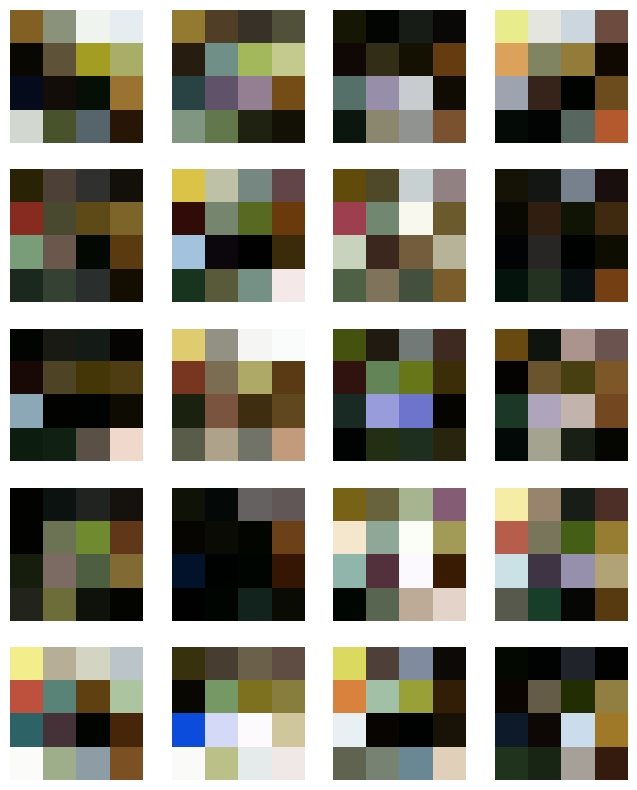

Batch: 2525 / 15625
D Loss: R: -12.575569 F: 12.741209 GP: 0.128290
G Loss: -12.646400
Batch: 2550 / 15625
D Loss: R: -13.030148 F: 13.087018 GP: 0.111855
G Loss: -13.120514
Batch: 2575 / 15625
D Loss: R: -12.532362 F: 12.643480 GP: 0.108834
G Loss: -12.865332
Batch: 2600 / 15625
D Loss: R: -13.071889 F: 13.248205 GP: 0.040755
G Loss: -12.487724
Batch: 2625 / 15625
D Loss: R: -12.245879 F: 12.399715 GP: 0.155792
G Loss: -11.696609
Batch: 2650 / 15625
D Loss: R: -12.779543 F: 12.893190 GP: 0.189683
G Loss: -13.586727
Batch: 2675 / 15625
D Loss: R: -13.677011 F: 13.804644 GP: 0.077664
G Loss: -12.855873
Batch: 2700 / 15625
D Loss: R: -12.287519 F: 12.375807 GP: 0.082377
G Loss: -12.195697
Found 17432 files belonging to 1 classes.


2024-05-05 18:34:36.861804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 18:34:36.862086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 2725 / 15625
D Loss: R: -12.007277 F: 12.276100 GP: 0.120337
G Loss: -12.570784
Batch: 2750 / 15625
D Loss: R: -13.409559 F: 13.407945 GP: 0.111550
G Loss: -13.590940
Batch: 2775 / 15625
D Loss: R: -14.113365 F: 14.201702 GP: 0.115137
G Loss: -14.063267
Batch: 2800 / 15625
D Loss: R: -15.028235 F: 15.169456 GP: 0.178835
G Loss: -14.466528
Batch: 2825 / 15625
D Loss: R: -14.803822 F: 14.872997 GP: 0.183469
G Loss: -15.704535
Batch: 2850 / 15625
D Loss: R: -14.751207 F: 14.909479 GP: 0.118680
G Loss: -14.320681
Batch: 2875 / 15625
D Loss: R: -13.359991 F: 13.507559 GP: 0.149490
G Loss: -14.107635
Batch: 2900 / 15625
D Loss: R: -15.728664 F: 15.827344 GP: 0.072066
G Loss: -15.608135
Batch: 2925 / 15625
D Loss: R: -14.760838 F: 14.844708 GP: 0.174959
G Loss: -14.597075
Batch: 2950 / 15625
D Loss: R: -14.028562 F: 14.061374 GP: 0.400792
G Loss: -14.604700
Batch: 2975 / 15625
D Loss: R: -13.597636 F: 13.687191 GP: 0.214601
G Loss: -13.583796
Found 17432 files belonging to 1 classes.


2024-05-05 18:41:14.989195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 18:41:14.989470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 3000 / 15625
D Loss: R: -14.422780 F: 14.502460 GP: 0.117134
G Loss: -14.273766
Saving weights...
Done.
1/1 [==============================] - 0s 23ms/step


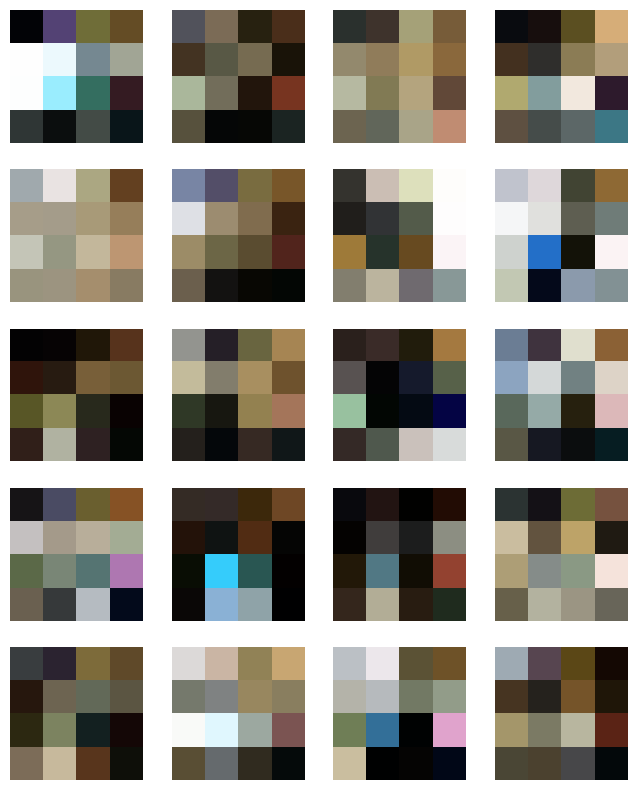

Batch: 3025 / 15625
D Loss: R: -13.363958 F: 13.445915 GP: 0.136797
G Loss: -13.652729
Batch: 3050 / 15625
D Loss: R: -13.518940 F: 13.587473 GP: 0.180122
G Loss: -13.968348
Batch: 3075 / 15625
D Loss: R: -13.994357 F: 14.017263 GP: 0.144510
G Loss: -14.524953
Batch: 3100 / 15625
D Loss: R: -15.047680 F: 15.157547 GP: 0.127840
G Loss: -15.375988
Batch: 3125 / 15625
D Loss: R: -14.198241 F: 14.255837 GP: 0.110971
G Loss: -14.325686
Batch: 3150 / 15625
D Loss: R: -14.627853 F: 14.678391 GP: 0.107469
G Loss: -14.086185
Batch: 3175 / 15625
D Loss: R: -14.465107 F: 14.429927 GP: 0.103130
G Loss: -14.732313
Batch: 3200 / 15625
D Loss: R: -13.792926 F: 13.885427 GP: 0.172475
G Loss: -14.456173
Batch: 3225 / 15625
D Loss: R: -13.756053 F: 13.807945 GP: 0.144623
G Loss: -14.046331
Batch: 3250 / 15625
D Loss: R: -15.550785 F: 15.492687 GP: 0.144641
G Loss: -14.623064
Found 17432 files belonging to 1 classes.


2024-05-05 18:47:55.870815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 18:47:55.871150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 3275 / 15625
D Loss: R: -15.390502 F: 15.513691 GP: 0.088877
G Loss: -14.905695
Batch: 3300 / 15625
D Loss: R: -14.607025 F: 14.650598 GP: 0.101575
G Loss: -14.352423
Batch: 3325 / 15625
D Loss: R: -14.836822 F: 14.899464 GP: 0.115427
G Loss: -14.612660
Batch: 3350 / 15625
D Loss: R: -14.014284 F: 14.081274 GP: 0.263839
G Loss: -14.282085
Batch: 3375 / 15625
D Loss: R: -15.634322 F: 15.760632 GP: 0.109718
G Loss: -14.972445
Batch: 3400 / 15625
D Loss: R: -15.645161 F: 15.689177 GP: 0.123070
G Loss: -15.071335
Batch: 3425 / 15625
D Loss: R: -14.462694 F: 14.508242 GP: 0.097660
G Loss: -13.984053
Batch: 3450 / 15625
D Loss: R: -13.970803 F: 14.074575 GP: 0.092898
G Loss: -14.153810
Batch: 3475 / 15625
D Loss: R: -15.539367 F: 15.580052 GP: 0.076398
G Loss: -15.570431
Batch: 3500 / 15625
D Loss: R: -16.055693 F: 16.072449 GP: 0.103556
G Loss: -16.145845
1/1 [==============================] - 0s 22ms/step


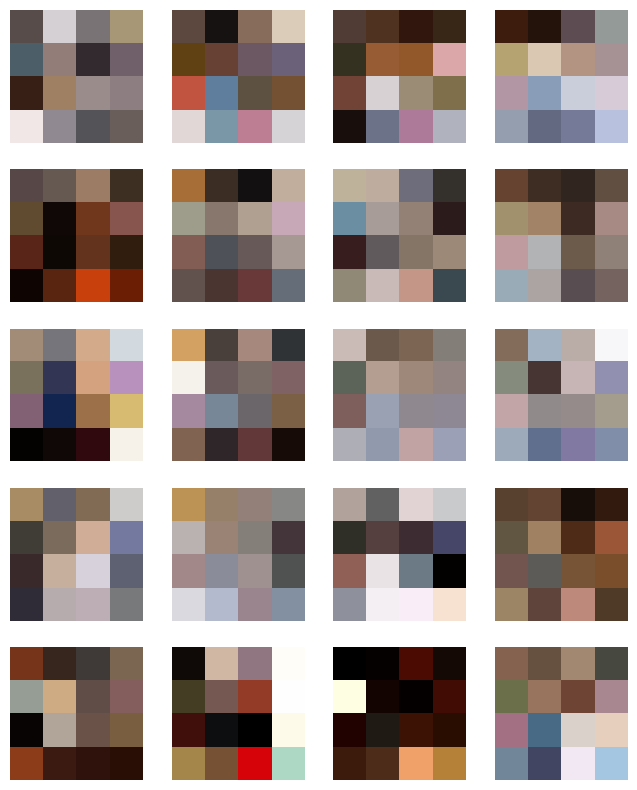

Batch: 3525 / 15625
D Loss: R: -15.622572 F: 15.755074 GP: 0.148832
G Loss: -14.791023
Found 17432 files belonging to 1 classes.


2024-05-05 18:54:35.498513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 18:54:35.498798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 3550 / 15625
D Loss: R: -15.238207 F: 15.273020 GP: 0.119532
G Loss: -15.431761
Batch: 3575 / 15625
D Loss: R: -16.268408 F: 16.327972 GP: 0.086455
G Loss: -15.556929
Batch: 3600 / 15625
D Loss: R: -15.360497 F: 15.404546 GP: 0.194092
G Loss: -15.842915
Batch: 3625 / 15625
D Loss: R: -14.576623 F: 14.668856 GP: 0.129593
G Loss: -14.358740
Batch: 3650 / 15625
D Loss: R: -14.973442 F: 15.028836 GP: 0.184279
G Loss: -15.568205
Batch: 3675 / 15625
D Loss: R: -15.248654 F: 15.388693 GP: 0.085088
G Loss: -15.514450
Batch: 3700 / 15625
D Loss: R: -14.678544 F: 14.811245 GP: 0.089739
G Loss: -14.690190
Batch: 3725 / 15625
D Loss: R: -14.344545 F: 14.395512 GP: 0.096612
G Loss: -14.277178
Batch: 3750 / 15625
D Loss: R: -13.905042 F: 13.917572 GP: 0.126180
G Loss: -13.564576
Batch: 3775 / 15625
D Loss: R: -13.717893 F: 13.711976 GP: 0.149649
G Loss: -13.631668
Batch: 3800 / 15625
D Loss: R: -14.958195 F: 14.989457 GP: 0.160201
G Loss: -14.573638
Found 17432 files belonging to 1 classes.


2024-05-05 19:01:14.429092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 19:01:14.429390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 3825 / 15625
D Loss: R: -15.054672 F: 15.085995 GP: 0.205990
G Loss: -15.327694
Batch: 3850 / 15625
D Loss: R: -15.467169 F: 15.569751 GP: 0.102423
G Loss: -15.260340
Batch: 3875 / 15625
D Loss: R: -14.544605 F: 14.620955 GP: 0.079556
G Loss: -14.598923
Batch: 3900 / 15625
D Loss: R: -14.287201 F: 14.332142 GP: 0.129221
G Loss: -14.501884
Batch: 3925 / 15625
D Loss: R: -13.878611 F: 13.878428 GP: 0.078601
G Loss: -13.522381
Batch: 3950 / 15625
D Loss: R: -13.338298 F: 13.364784 GP: 0.109303
G Loss: -13.918827
Batch: 3975 / 15625
D Loss: R: -12.709012 F: 12.781586 GP: 0.105258
G Loss: -13.307389
Batch: 4000 / 15625
D Loss: R: -13.188718 F: 13.259891 GP: 0.094445
G Loss: -13.295092
Saving weights...
Done.
1/1 [==============================] - 0s 22ms/step


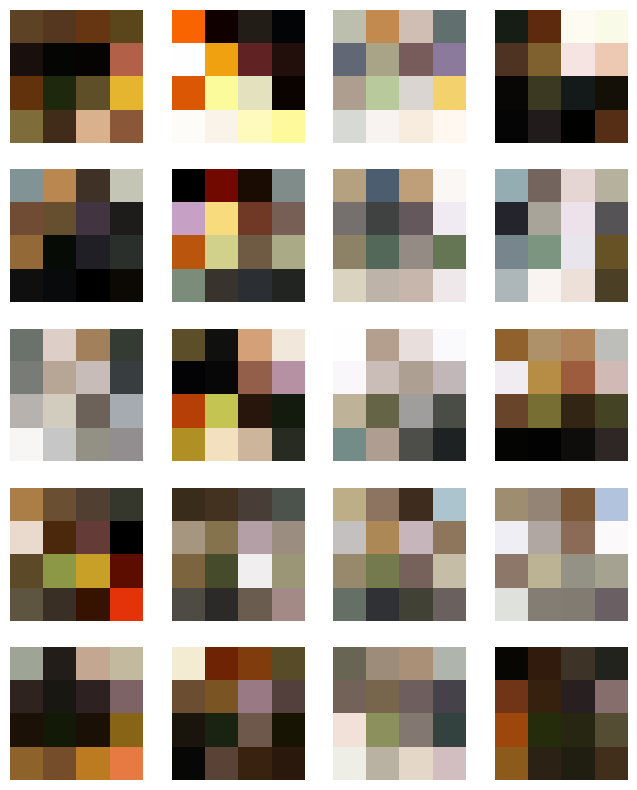

Batch: 4025 / 15625
D Loss: R: -14.032533 F: 14.172196 GP: 0.163271
G Loss: -13.496470
Batch: 4050 / 15625
D Loss: R: -13.394699 F: 13.442719 GP: 0.081806
G Loss: -14.020092
Batch: 4075 / 15625
D Loss: R: -13.688740 F: 13.712524 GP: 0.141281
G Loss: -13.679775
Found 17432 files belonging to 1 classes.


2024-05-05 19:07:54.780934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 19:07:54.781217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 4100 / 15625
D Loss: R: -12.503748 F: 12.548713 GP: 0.161743
G Loss: -12.042097
Batch: 4125 / 15625
D Loss: R: -13.037066 F: 13.122489 GP: 0.148939
G Loss: -12.569207
Batch: 4150 / 15625
D Loss: R: -12.593843 F: 12.659274 GP: 0.085542
G Loss: -13.094734
Batch: 4175 / 15625
D Loss: R: -12.458475 F: 12.548532 GP: 0.105259
G Loss: -12.384069
Batch: 4200 / 15625
D Loss: R: -12.124952 F: 12.172052 GP: 0.124130
G Loss: -11.884989
Batch: 4225 / 15625
D Loss: R: -11.937704 F: 12.013670 GP: 0.114457
G Loss: -11.645217
Batch: 4250 / 15625
D Loss: R: -12.495756 F: 12.470027 GP: 0.106458
G Loss: -12.138124
Batch: 4275 / 15625
D Loss: R: -12.714780 F: 12.725567 GP: 0.157805
G Loss: -12.894427
Batch: 4300 / 15625
D Loss: R: -12.058424 F: 12.118982 GP: 0.124162
G Loss: -12.042902
Batch: 4325 / 15625
D Loss: R: -11.652232 F: 11.695384 GP: 0.167537
G Loss: -12.066587
Batch: 4350 / 15625
D Loss: R: -12.128550 F: 12.243056 GP: 0.130505
G Loss: -12.827460
Found 17432 files belonging to 1 classes.


2024-05-05 19:14:33.744199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 19:14:33.744493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 4375 / 15625
D Loss: R: -13.544590 F: 13.639996 GP: 0.124010
G Loss: -13.811338
Batch: 4400 / 15625
D Loss: R: -13.718478 F: 13.730157 GP: 0.145125
G Loss: -13.149155
Batch: 4425 / 15625
D Loss: R: -11.981681 F: 12.028893 GP: 0.079844
G Loss: -11.527267
Batch: 4450 / 15625
D Loss: R: -11.622610 F: 11.714321 GP: 0.179978
G Loss: -11.511011
Batch: 4475 / 15625
D Loss: R: -12.853959 F: 12.871475 GP: 0.108698
G Loss: -12.370476
Batch: 4500 / 15625
D Loss: R: -12.275681 F: 12.355170 GP: 0.140234
G Loss: -12.294256
1/1 [==============================] - 0s 23ms/step


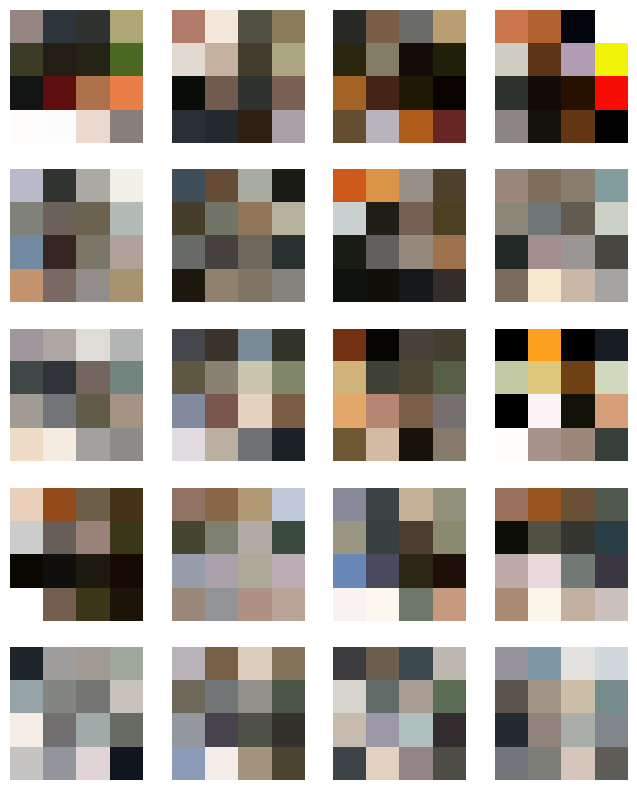

Batch: 4525 / 15625
D Loss: R: -11.420406 F: 11.449130 GP: 0.105144
G Loss: -11.566284
Batch: 4550 / 15625
D Loss: R: -11.224061 F: 11.288773 GP: 0.191535
G Loss: -11.499289
Batch: 4575 / 15625
D Loss: R: -11.611430 F: 11.644965 GP: 0.076166
G Loss: -11.706704
Batch: 4600 / 15625
D Loss: R: -11.825243 F: 11.857826 GP: 0.098556
G Loss: -11.696095
Found 17432 files belonging to 1 classes.
Batch: 4625 / 15625


2024-05-05 19:21:12.771716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 19:21:12.772018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


D Loss: R: -11.226387 F: 11.271818 GP: 0.243736
G Loss: -11.787045
Batch: 4650 / 15625
D Loss: R: -10.946086 F: 11.062185 GP: 0.148266
G Loss: -11.146933
Batch: 4675 / 15625
D Loss: R: -11.276036 F: 11.278052 GP: 0.109547
G Loss: -11.025573
Batch: 4700 / 15625
D Loss: R: -10.288158 F: 10.371585 GP: 0.303954
G Loss: -9.903148
Batch: 4725 / 15625
D Loss: R: -11.818292 F: 11.797354 GP: 0.072561
G Loss: -11.778160
Batch: 4750 / 15625
D Loss: R: -12.836039 F: 12.857602 GP: 0.122018
G Loss: -12.573961
Batch: 4775 / 15625
D Loss: R: -11.575230 F: 11.595682 GP: 0.140877
G Loss: -10.966076
Batch: 4800 / 15625
D Loss: R: -10.724798 F: 10.657839 GP: 0.136819
G Loss: -10.161707
Batch: 4825 / 15625
D Loss: R: -10.718712 F: 10.795588 GP: 0.075821
G Loss: -10.973874
Batch: 4850 / 15625
D Loss: R: -11.413774 F: 11.430073 GP: 0.062155
G Loss: -11.098783
Batch: 4875 / 15625
D Loss: R: -10.316231 F: 10.339043 GP: 0.096665
G Loss: -10.651333
Found 17432 files belonging to 1 classes.


2024-05-05 19:27:51.939827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 19:27:51.940097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 4900 / 15625
D Loss: R: -9.568728 F: 9.581112 GP: 0.091461
G Loss: -9.629619
Batch: 4925 / 15625
D Loss: R: -9.397198 F: 9.453268 GP: 0.113038
G Loss: -9.529935
Batch: 4950 / 15625
D Loss: R: -9.973375 F: 10.043158 GP: 0.070610
G Loss: -10.035004
Batch: 4975 / 15625
D Loss: R: -9.918562 F: 9.948921 GP: 0.081978
G Loss: -9.934732
Batch: 5000 / 15625
D Loss: R: -10.604818 F: 10.629919 GP: 0.227772
G Loss: -10.422492
Saving weights...
Done.
1/1 [==============================] - 0s 23ms/step


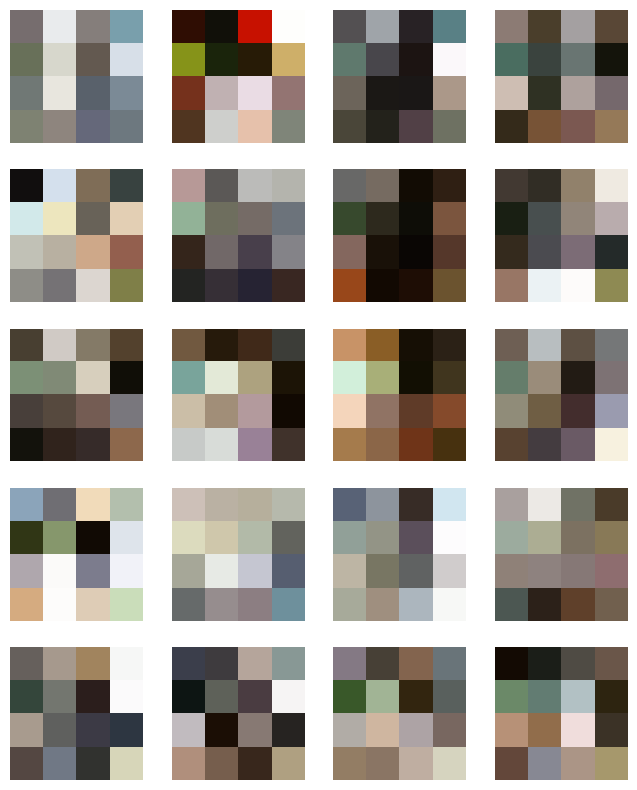

Batch: 5025 / 15625
D Loss: R: -9.857210 F: 9.889418 GP: 0.075319
G Loss: -9.941071
Batch: 5050 / 15625
D Loss: R: -9.606361 F: 9.641619 GP: 0.106610
G Loss: -9.515184
Batch: 5075 / 15625
D Loss: R: -10.072536 F: 10.074249 GP: 0.091883
G Loss: -9.969313
Batch: 5100 / 15625
D Loss: R: -9.670985 F: 9.695068 GP: 0.092174
G Loss: -9.901717
Batch: 5125 / 15625
D Loss: R: -10.111183 F: 10.123169 GP: 0.083283
G Loss: -9.835399
Batch: 5150 / 15625
D Loss: R: -9.436623 F: 9.497755 GP: 0.140097
G Loss: -9.766256
Found 17432 files belonging to 1 classes.


2024-05-05 19:34:32.965383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 19:34:32.965734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 5175 / 15625
D Loss: R: -9.061842 F: 9.132101 GP: 0.053316
G Loss: -9.309427
Batch: 5200 / 15625
D Loss: R: -9.427574 F: 9.386189 GP: 0.148712
G Loss: -9.818061
Batch: 5225 / 15625
D Loss: R: -9.471713 F: 9.485738 GP: 0.107500
G Loss: -9.547428
Batch: 5250 / 15625
D Loss: R: -9.777236 F: 9.787836 GP: 0.157149
G Loss: -9.429847
Batch: 5275 / 15625
D Loss: R: -9.840512 F: 9.926207 GP: 0.100221
G Loss: -9.916780
Batch: 5300 / 15625
D Loss: R: -8.722063 F: 8.809340 GP: 0.052157
G Loss: -8.938931
Batch: 5325 / 15625
D Loss: R: -7.905948 F: 7.964206 GP: 0.140992
G Loss: -8.656331
Batch: 5350 / 15625
D Loss: R: -9.813931 F: 9.904437 GP: 0.165749
G Loss: -9.862626
Batch: 5375 / 15625
D Loss: R: -10.040658 F: 10.023129 GP: 0.225930
G Loss: -9.502481
Batch: 5400 / 15625
D Loss: R: -9.104104 F: 9.154221 GP: 0.185164
G Loss: -9.306314
Batch: 5425 / 15625
D Loss: R: -8.218228 F: 8.334336 GP: 0.137441
G Loss: -8.490843
Found 17432 files belonging to 1 classes.


2024-05-05 19:41:10.873287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 19:41:10.873631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 5450 / 15625
D Loss: R: -9.321093 F: 9.280508 GP: 0.070198
G Loss: -8.946375
Batch: 5475 / 15625
D Loss: R: -9.052332 F: 9.100794 GP: 0.102485
G Loss: -9.025810
Batch: 5500 / 15625
D Loss: R: -8.315073 F: 8.412968 GP: 0.079341
G Loss: -8.250606
1/1 [==============================] - 0s 22ms/step


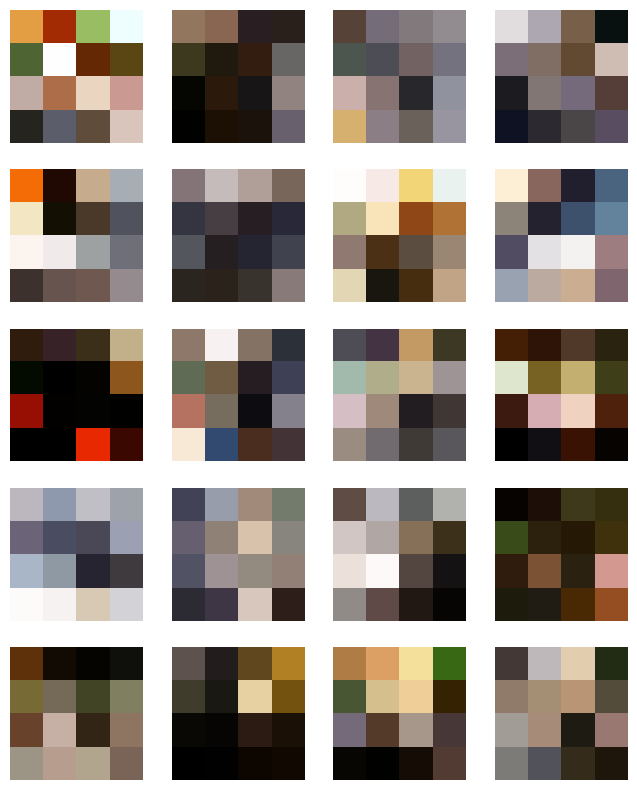

Batch: 5525 / 15625
D Loss: R: -8.082109 F: 8.050037 GP: 0.084107
G Loss: -8.191701
Batch: 5550 / 15625
D Loss: R: -8.200748 F: 8.255380 GP: 0.130339
G Loss: -8.324248
Batch: 5575 / 15625
D Loss: R: -9.063313 F: 9.114349 GP: 0.083543
G Loss: -8.824502
Batch: 5600 / 15625
D Loss: R: -8.769351 F: 8.808290 GP: 0.196156
G Loss: -8.879129
Batch: 5625 / 15625
D Loss: R: -9.132130 F: 9.197977 GP: 0.081005
G Loss: -9.143112
Batch: 5650 / 15625
D Loss: R: -8.842475 F: 8.901663 GP: 0.088511
G Loss: -9.667992
Batch: 5675 / 15625
D Loss: R: -8.913559 F: 8.932182 GP: 0.178819
G Loss: -8.420351
Batch: 5700 / 15625
D Loss: R: -8.964462 F: 8.955171 GP: 0.064486
G Loss: -8.880211
Found 17432 files belonging to 1 classes.


2024-05-05 19:47:51.185502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 19:47:51.185846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 5725 / 15625
D Loss: R: -7.441545 F: 7.457797 GP: 0.573822
G Loss: -6.628152
Batch: 5750 / 15625
D Loss: R: -8.291428 F: 8.300874 GP: 0.065036
G Loss: -8.362614
Batch: 5775 / 15625
D Loss: R: -7.898053 F: 7.973240 GP: 0.114085
G Loss: -8.255177
Batch: 5800 / 15625
D Loss: R: -9.096210 F: 9.145560 GP: 0.047146
G Loss: -9.233821
Batch: 5825 / 15625
D Loss: R: -8.942272 F: 8.993858 GP: 0.126424
G Loss: -9.210600
Batch: 5850 / 15625
D Loss: R: -8.706869 F: 8.750942 GP: 0.152406
G Loss: -8.489525
Batch: 5875 / 15625
D Loss: R: -7.769534 F: 7.756631 GP: 0.106596
G Loss: -7.919173
Batch: 5900 / 15625
D Loss: R: -7.788983 F: 7.831640 GP: 0.084903
G Loss: -7.923889
Batch: 5925 / 15625
D Loss: R: -7.805830 F: 7.861888 GP: 0.236844
G Loss: -7.051565
Batch: 5950 / 15625
D Loss: R: -8.157244 F: 8.189754 GP: 0.186671
G Loss: -7.977975
Batch: 5975 / 15625
D Loss: R: -7.732689 F: 7.750114 GP: 0.117249
G Loss: -7.964552
Found 17432 files belonging to 1 classes.


2024-05-05 19:54:30.665905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 19:54:30.666187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 6000 / 15625
D Loss: R: -8.257921 F: 8.275283 GP: 0.173292
G Loss: -8.264834
Saving weights...
Done.
1/1 [==============================] - 0s 22ms/step


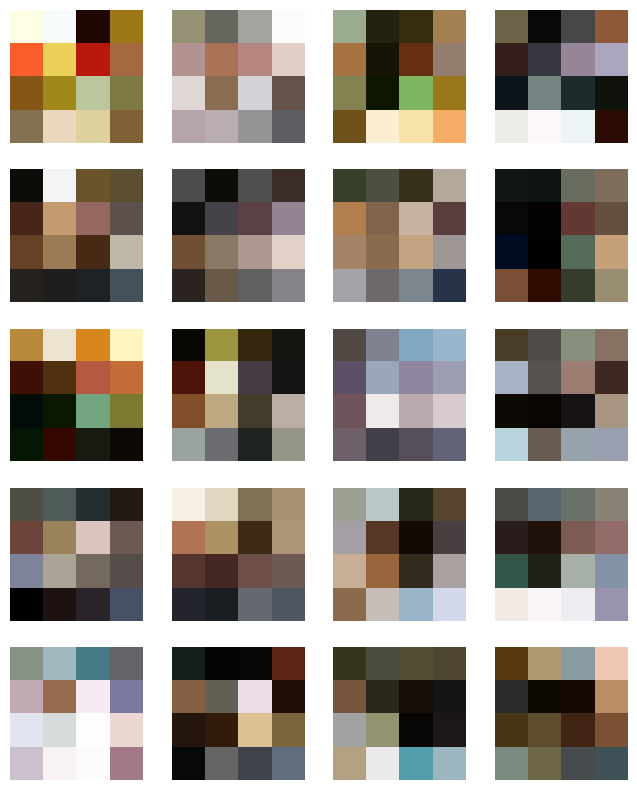

Batch: 6025 / 15625
D Loss: R: -8.460357 F: 8.553749 GP: 0.121720
G Loss: -8.415535
Batch: 6050 / 15625
D Loss: R: -7.454591 F: 7.549196 GP: 0.123488
G Loss: -7.822755
Batch: 6075 / 15625
D Loss: R: -7.571774 F: 7.492227 GP: 0.093804
G Loss: -7.466133
Batch: 6100 / 15625
D Loss: R: -6.579379 F: 6.582096 GP: 0.071389
G Loss: -6.647627
Batch: 6125 / 15625
D Loss: R: -7.701886 F: 7.735440 GP: 0.133961
G Loss: -8.075820
Batch: 6150 / 15625
D Loss: R: -7.740692 F: 7.821795 GP: 0.156803
G Loss: -7.902972
Batch: 6175 / 15625
D Loss: R: -6.905167 F: 6.923077 GP: 0.104116
G Loss: -7.067650
Batch: 6200 / 15625
D Loss: R: -8.031173 F: 8.110391 GP: 0.151458
G Loss: -8.366690
Batch: 6225 / 15625
D Loss: R: -8.466842 F: 8.445571 GP: 0.069704
G Loss: -8.327559
Batch: 6250 / 15625
D Loss: R: -7.450532 F: 7.447196 GP: 0.084250
G Loss: -7.442188
Found 17432 files belonging to 1 classes.


2024-05-05 20:01:09.547401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 20:01:09.547679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 6275 / 15625
D Loss: R: -6.906339 F: 6.935891 GP: 0.132517
G Loss: -6.902142
Batch: 6300 / 15625
D Loss: R: -6.770087 F: 6.804964 GP: 0.148156
G Loss: -6.619102
Batch: 6325 / 15625
D Loss: R: -7.109200 F: 7.102866 GP: 0.034153
G Loss: -6.987658
Batch: 6350 / 15625
D Loss: R: -6.988306 F: 6.975056 GP: 0.065430
G Loss: -6.859350
Batch: 6375 / 15625
D Loss: R: -5.431859 F: 5.511595 GP: 0.051390
G Loss: -5.393594
Batch: 6400 / 15625
D Loss: R: -5.107794 F: 5.075399 GP: 0.164012
G Loss: -5.131781
Batch: 6425 / 15625
D Loss: R: -5.669352 F: 5.770457 GP: 0.076299
G Loss: -5.936700
Batch: 6450 / 15625
D Loss: R: -6.180443 F: 6.215915 GP: 0.080547
G Loss: -6.209332
Batch: 6475 / 15625
D Loss: R: -5.723528 F: 5.746366 GP: 0.092144
G Loss: -5.557074
Batch: 6500 / 15625
D Loss: R: -5.818119 F: 5.857015 GP: 0.077895
G Loss: -5.782018
1/1 [==============================] - 0s 23ms/step


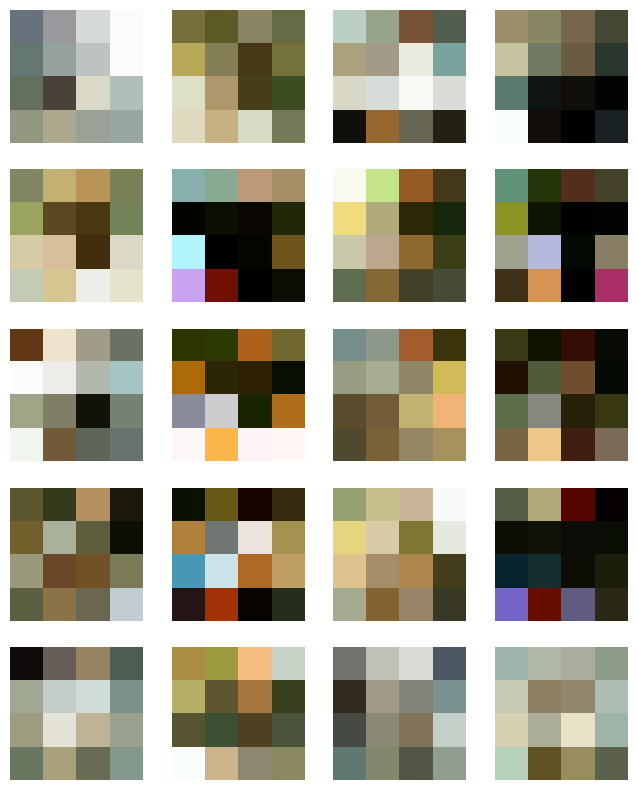

Batch: 6525 / 15625
D Loss: R: -5.381967 F: 5.416830 GP: 0.205447
G Loss: -5.709142
Found 17432 files belonging to 1 classes.


2024-05-05 20:07:47.190207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 20:07:47.190477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 6550 / 15625
D Loss: R: -6.297915 F: 6.294841 GP: 0.081232
G Loss: -6.411255
Batch: 6575 / 15625
D Loss: R: -5.857806 F: 5.925677 GP: 0.241693
G Loss: -5.849601
Batch: 6600 / 15625
D Loss: R: -6.457266 F: 6.432729 GP: 0.438347
G Loss: -7.720415
Batch: 6625 / 15625
D Loss: R: -5.921874 F: 5.942050 GP: 0.104406
G Loss: -6.114439
Batch: 6650 / 15625
D Loss: R: -5.473794 F: 5.501665 GP: 0.114141
G Loss: -5.587461
Batch: 6675 / 15625
D Loss: R: -5.451803 F: 5.540308 GP: 0.060436
G Loss: -5.399284
Batch: 6700 / 15625
D Loss: R: -5.655136 F: 5.620377 GP: 0.080415
G Loss: -5.758377
Batch: 6725 / 15625
D Loss: R: -5.748652 F: 5.744801 GP: 0.044112
G Loss: -5.777492
Batch: 6750 / 15625
D Loss: R: -6.036502 F: 6.086462 GP: 0.106403
G Loss: -5.757899
Batch: 6775 / 15625
D Loss: R: -5.812118 F: 5.861114 GP: 0.122281
G Loss: -5.960664
Batch: 6800 / 15625
D Loss: R: -6.029041 F: 6.025111 GP: 0.065167
G Loss: -6.002333
Found 17432 files belonging to 1 classes.


2024-05-05 20:14:25.788550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 20:14:25.788896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 6825 / 15625
D Loss: R: -5.794129 F: 5.771719 GP: 0.110982
G Loss: -5.867901
Batch: 6850 / 15625
D Loss: R: -6.040840 F: 6.079999 GP: 0.083778
G Loss: -6.004218
Batch: 6875 / 15625
D Loss: R: -5.790463 F: 5.822953 GP: 0.073305
G Loss: -5.872465
Batch: 6900 / 15625
D Loss: R: -6.353244 F: 6.379217 GP: 0.107234
G Loss: -6.177413
Batch: 6925 / 15625
D Loss: R: -5.852696 F: 5.886086 GP: 0.129015
G Loss: -5.940884
Batch: 6950 / 15625
D Loss: R: -6.419032 F: 6.448189 GP: 0.057399
G Loss: -6.354223
Batch: 6975 / 15625
D Loss: R: -5.613723 F: 5.692496 GP: 0.084093
G Loss: -5.716598
Batch: 7000 / 15625
D Loss: R: -6.171148 F: 6.160695 GP: 0.070002
G Loss: -6.151335
Saving weights...
Done.
1/1 [==============================] - 0s 22ms/step


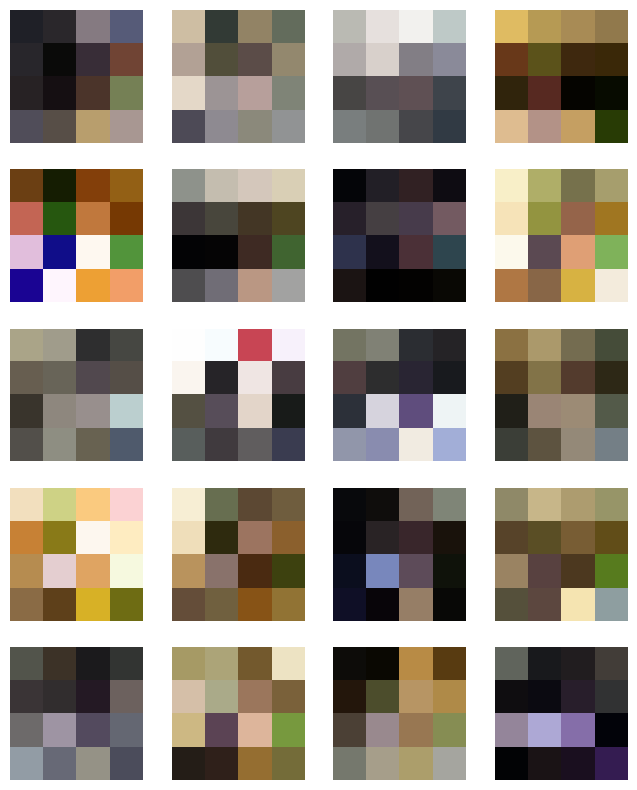

Batch: 7025 / 15625
D Loss: R: -6.636132 F: 6.647573 GP: 0.067215
G Loss: -6.603053
Batch: 7050 / 15625
D Loss: R: -5.549510 F: 5.563367 GP: 0.115236
G Loss: -5.395666
Found 17432 files belonging to 1 classes.


2024-05-05 20:21:05.045895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 20:21:05.046217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 7075 / 15625
D Loss: R: -5.397539 F: 5.383311 GP: 0.055216
G Loss: -5.214944
Batch: 7100 / 15625
D Loss: R: -4.944156 F: 4.997018 GP: 0.059788
G Loss: -4.781572
Batch: 7125 / 15625
D Loss: R: -4.718257 F: 4.761169 GP: 0.081002
G Loss: -5.102357
Batch: 7150 / 15625
D Loss: R: -4.146238 F: 4.126860 GP: 0.134373
G Loss: -4.300933
Batch: 7175 / 15625
D Loss: R: -4.057150 F: 4.103179 GP: 0.078852
G Loss: -3.940276
Batch: 7200 / 15625
D Loss: R: -3.893855 F: 3.866681 GP: 0.154504
G Loss: -3.944739
Batch: 7225 / 15625
D Loss: R: -4.141951 F: 4.157425 GP: 0.069661
G Loss: -4.243959
Batch: 7250 / 15625
D Loss: R: -4.586108 F: 4.594945 GP: 0.113658
G Loss: -4.706938
Batch: 7275 / 15625
D Loss: R: -4.293605 F: 4.322237 GP: 0.233611
G Loss: -5.082367
Batch: 7300 / 15625
D Loss: R: -4.807584 F: 4.875025 GP: 0.032507
G Loss: -4.918607
Batch: 7325 / 15625
D Loss: R: -4.073643 F: 4.088157 GP: 0.091088
G Loss: -3.861313
Found 17432 files belonging to 1 classes.


2024-05-05 20:27:43.000468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 20:27:43.000741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 7350 / 15625
D Loss: R: -4.061484 F: 4.073084 GP: 0.253417
G Loss: -4.032710
Batch: 7375 / 15625
D Loss: R: -3.830774 F: 3.827634 GP: 0.063110
G Loss: -3.667858
Batch: 7400 / 15625
D Loss: R: -3.648115 F: 3.648851 GP: 0.048624
G Loss: -3.457439
Batch: 7425 / 15625
D Loss: R: -3.773907 F: 3.780976 GP: 0.339875
G Loss: -3.880741
Batch: 7450 / 15625
D Loss: R: -4.292047 F: 4.362525 GP: 0.076502
G Loss: -4.428096
Batch: 7475 / 15625
D Loss: R: -4.434085 F: 4.436965 GP: 0.041980
G Loss: -4.365515
Batch: 7500 / 15625
D Loss: R: -3.664874 F: 3.695673 GP: 0.047211
G Loss: -3.641525
1/1 [==============================] - 0s 22ms/step


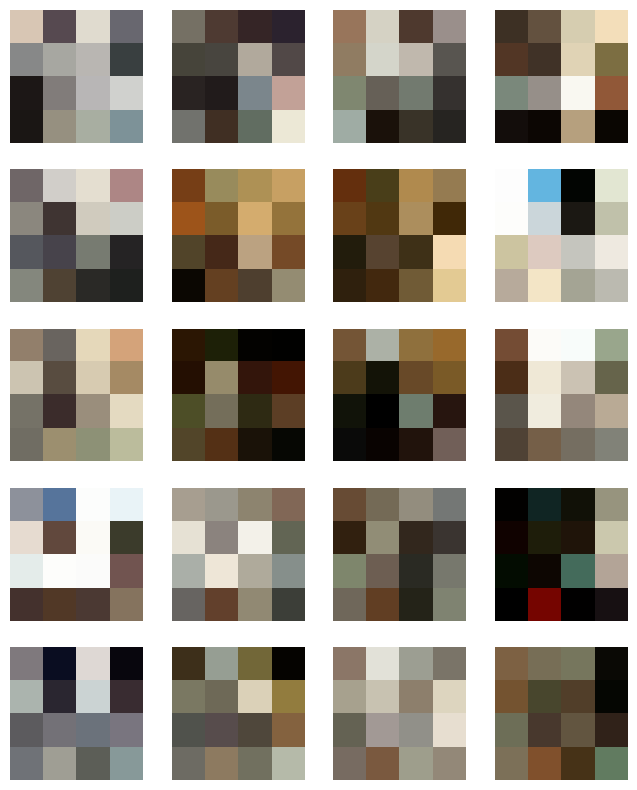

Batch: 7525 / 15625
D Loss: R: -3.570797 F: 3.589046 GP: 0.354017
G Loss: -3.801900
Batch: 7550 / 15625
D Loss: R: -3.836752 F: 3.855210 GP: 0.114057
G Loss: -3.900743
Batch: 7575 / 15625
D Loss: R: -3.975380 F: 4.020189 GP: 0.079367
G Loss: -4.050271
Batch: 7600 / 15625
D Loss: R: -4.167562 F: 4.134100 GP: 0.077216
G Loss: -4.168901
Found 17432 files belonging to 1 classes.


2024-05-05 20:34:21.886660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 20:34:21.886940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 7625 / 15625
D Loss: R: -4.309309 F: 4.304915 GP: 0.191011
G Loss: -3.419344
Batch: 7650 / 15625
D Loss: R: -4.100365 F: 4.110428 GP: 0.090774
G Loss: -4.150699
Batch: 7675 / 15625
D Loss: R: -3.742062 F: 3.791329 GP: 0.072036
G Loss: -3.650263
Batch: 7700 / 15625
D Loss: R: -2.608409 F: 2.685882 GP: 0.099000
G Loss: -2.745311
Batch: 7725 / 15625
D Loss: R: -3.211593 F: 3.249625 GP: 0.114345
G Loss: -3.183846
Batch: 7750 / 15625
D Loss: R: -2.364421 F: 2.384152 GP: 0.101021
G Loss: -2.322158
Batch: 7775 / 15625
D Loss: R: -2.208390 F: 2.253268 GP: 0.165521
G Loss: -2.815604
Batch: 7800 / 15625
D Loss: R: -1.838943 F: 1.915250 GP: 0.105870
G Loss: -2.057659
Batch: 7825 / 15625
D Loss: R: -1.827309 F: 1.791399 GP: 0.146685
G Loss: -1.740736
Batch: 7850 / 15625
D Loss: R: -1.393850 F: 1.525203 GP: 0.060952
G Loss: -1.821047
Batch: 7875 / 15625
D Loss: R: -2.400497 F: 2.420646 GP: 0.074809
G Loss: -2.558231
Found 17432 files belonging to 1 classes.


2024-05-05 20:40:59.619065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 20:40:59.619367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 7900 / 15625
D Loss: R: -2.796331 F: 2.843277 GP: 0.099214
G Loss: -2.772301
Batch: 7925 / 15625
D Loss: R: -2.985640 F: 3.001618 GP: 0.105444
G Loss: -2.776825
Batch: 7950 / 15625
D Loss: R: -2.648810 F: 2.608486 GP: 0.065083
G Loss: -2.575876
Batch: 7975 / 15625
D Loss: R: -2.064721 F: 2.093813 GP: 0.062042
G Loss: -2.041464
Batch: 8000 / 15625
D Loss: R: -1.304856 F: 1.289051 GP: 0.037719
G Loss: -1.344386
Saving weights...
Done.
1/1 [==============================] - 0s 23ms/step


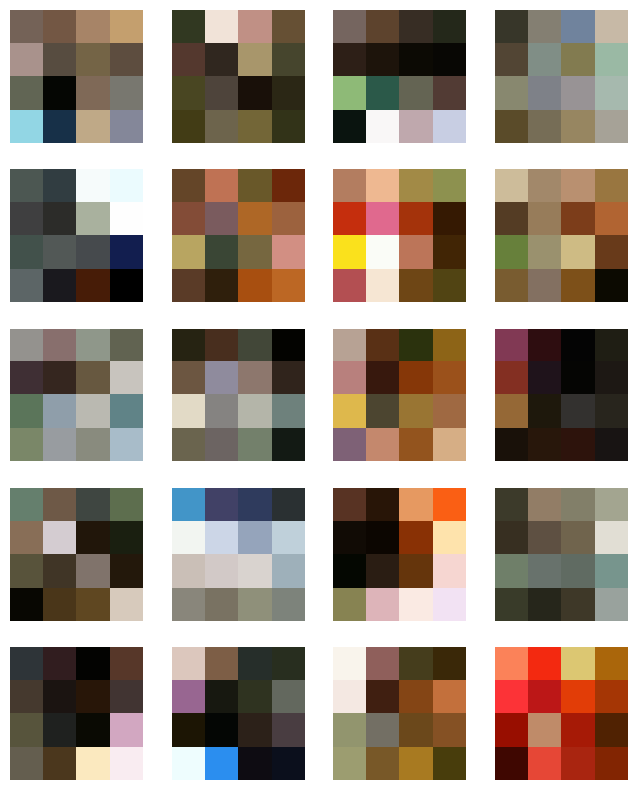

Batch: 8025 / 15625
D Loss: R: -1.559209 F: 1.526546 GP: 0.046225
G Loss: -1.502321
Batch: 8050 / 15625
D Loss: R: -1.917231 F: 1.978302 GP: 0.188322
G Loss: -2.091422
Batch: 8075 / 15625
D Loss: R: -1.992702 F: 2.034526 GP: 0.092543
G Loss: -1.743371
Batch: 8100 / 15625
D Loss: R: -1.266316 F: 1.329391 GP: 0.181651
G Loss: -1.573946
Batch: 8125 / 15625
D Loss: R: -1.086893 F: 1.039105 GP: 0.174390
G Loss: -1.173467
Batch: 8150 / 15625
D Loss: R: -0.855066 F: 0.936129 GP: 0.113296
G Loss: -0.961822
Found 17432 files belonging to 1 classes.


2024-05-05 20:47:40.449097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 20:47:40.449406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 8175 / 15625
D Loss: R: -0.681689 F: 0.692827 GP: 0.087214
G Loss: -0.804095
Batch: 8200 / 15625
D Loss: R: -0.807735 F: 0.855214 GP: 0.055752
G Loss: -0.801727
Batch: 8225 / 15625
D Loss: R: -1.317686 F: 1.300197 GP: 0.054873
G Loss: -1.214202
Batch: 8250 / 15625
D Loss: R: -1.102954 F: 1.151537 GP: 0.031161
G Loss: -1.155801
Batch: 8275 / 15625
D Loss: R: -0.493591 F: 0.497450 GP: 0.101871
G Loss: -0.548342
Batch: 8300 / 15625
D Loss: R: -0.125196 F: 0.171831 GP: 0.045101
G Loss: -0.218917
Batch: 8325 / 15625
D Loss: R: -0.865731 F: 0.907240 GP: 0.095922
G Loss: -0.939779
Batch: 8350 / 15625
D Loss: R: -1.618242 F: 1.577002 GP: 0.061340
G Loss: -1.656600
Batch: 8375 / 15625
D Loss: R: -1.344348 F: 1.353505 GP: 0.059258
G Loss: -1.330744
Batch: 8400 / 15625
D Loss: R: -0.380431 F: 0.399298 GP: 0.087665
G Loss: -0.740071
Batch: 8425 / 15625
D Loss: R: -1.171028 F: 1.181657 GP: 0.065578
G Loss: -1.157398
Found 17432 files belonging to 1 classes.


2024-05-05 20:54:17.983105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 20:54:17.983398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 8450 / 15625
D Loss: R: -1.022539 F: 1.111498 GP: 0.081341
G Loss: -1.112485
Batch: 8475 / 15625
D Loss: R: -0.744092 F: 0.794840 GP: 0.153144
G Loss: -0.794780
Batch: 8500 / 15625
D Loss: R: -0.691662 F: 0.693385 GP: 0.086716
G Loss: -0.769777
1/1 [==============================] - 0s 22ms/step


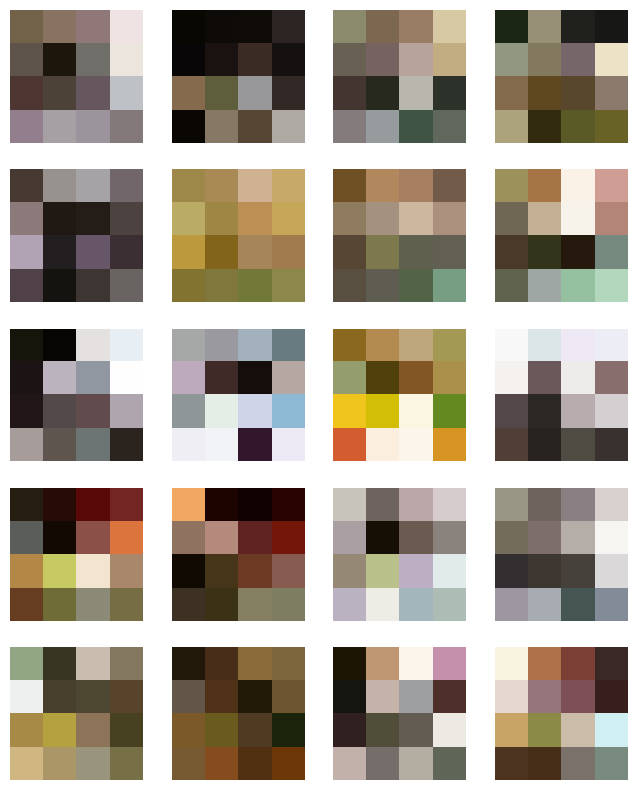

Batch: 8525 / 15625
D Loss: R: -1.734567 F: 1.762727 GP: 0.035531
G Loss: -1.930517
Batch: 8550 / 15625
D Loss: R: -1.167767 F: 1.166109 GP: 0.067730
G Loss: -1.135877
Batch: 8575 / 15625
D Loss: R: -1.096459 F: 1.118450 GP: 0.121444
G Loss: -1.156377
Batch: 8600 / 15625
D Loss: R: -1.515711 F: 1.574400 GP: 0.098919
G Loss: -1.551679
Batch: 8625 / 15625
D Loss: R: -0.914517 F: 0.966400 GP: 0.045500
G Loss: -0.963374
Batch: 8650 / 15625
D Loss: R: -1.394754 F: 1.415091 GP: 0.056909
G Loss: -1.299417
Batch: 8675 / 15625
D Loss: R: -1.442380 F: 1.474166 GP: 0.115068
G Loss: -1.183137
Batch: 8700 / 15625
D Loss: R: -0.921813 F: 1.004685 GP: 0.121379
G Loss: -1.044581
Found 17432 files belonging to 1 classes.


2024-05-05 21:00:52.558194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 21:00:52.558481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 8725 / 15625
D Loss: R: -1.336200 F: 1.363127 GP: 0.338037
G Loss: -1.123205
Batch: 8750 / 15625
D Loss: R: -1.280207 F: 1.330510 GP: 0.048004
G Loss: -1.307275
Batch: 8775 / 15625
D Loss: R: -1.339577 F: 1.371175 GP: 0.095930
G Loss: -1.480002
Batch: 8800 / 15625
D Loss: R: -1.538035 F: 1.525393 GP: 0.202893
G Loss: -1.485955
Batch: 8825 / 15625
D Loss: R: -1.453844 F: 1.479467 GP: 0.102632
G Loss: -1.430919
Batch: 8850 / 15625
D Loss: R: -0.975386 F: 0.987081 GP: 0.055654
G Loss: -0.877916
Batch: 8875 / 15625
D Loss: R: -0.421980 F: 0.504370 GP: 0.074596
G Loss: -0.660325
Batch: 8900 / 15625
D Loss: R: -0.859718 F: 0.844678 GP: 0.048922
G Loss: -0.653827
Batch: 8925 / 15625
D Loss: R: -1.349651 F: 1.364727 GP: 0.084337
G Loss: -1.505812
Batch: 8950 / 15625
D Loss: R: -0.833208 F: 0.886526 GP: 0.055959
G Loss: -0.775290
Batch: 8975 / 15625
D Loss: R: 0.014312 F: 0.037498 GP: 0.117326
G Loss: 0.022370
Found 17432 files belonging to 1 classes.


2024-05-05 21:07:32.227398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 21:07:32.227727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 9000 / 15625
D Loss: R: 0.186543 F: -0.151089 GP: 0.111272
G Loss: 0.389199
Saving weights...
Done.
1/1 [==============================] - 0s 22ms/step


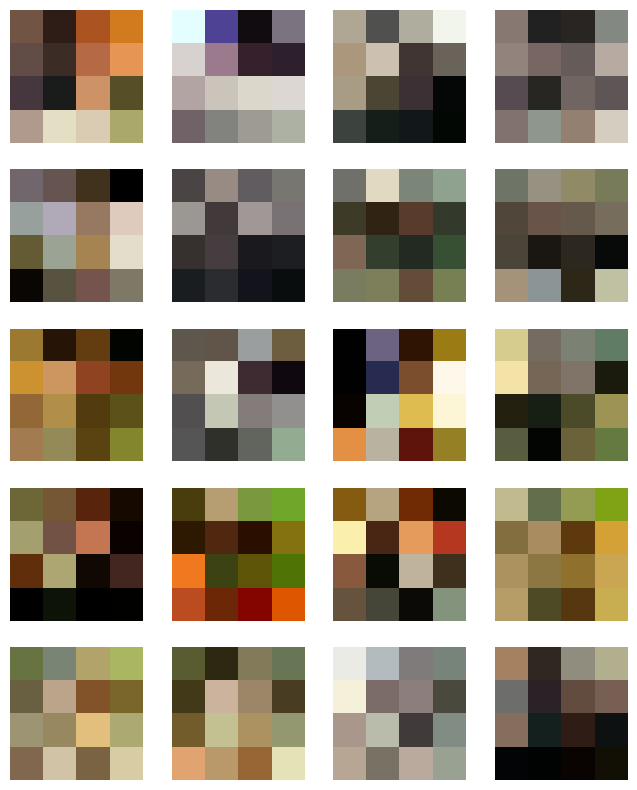

Batch: 9025 / 15625
D Loss: R: 0.693648 F: -0.707201 GP: 0.053454
G Loss: 0.730721
Batch: 9050 / 15625
D Loss: R: -0.308081 F: 0.319139 GP: 0.155000
G Loss: -0.379353
Batch: 9075 / 15625
D Loss: R: -0.081847 F: 0.091867 GP: 0.068009
G Loss: -0.032698
Batch: 9100 / 15625
D Loss: R: 0.371796 F: -0.281168 GP: 0.155735
G Loss: 0.461549
Batch: 9125 / 15625
D Loss: R: 0.278693 F: -0.273959 GP: 0.049159
G Loss: 0.259211
Batch: 9150 / 15625
D Loss: R: 0.531118 F: -0.500736 GP: 0.169848
G Loss: 0.662638
Batch: 9175 / 15625
D Loss: R: 0.588646 F: -0.588432 GP: 0.054037
G Loss: 0.812771
Batch: 9200 / 15625
D Loss: R: 1.050832 F: -0.963928 GP: 0.151089
G Loss: 0.898508
Batch: 9225 / 15625
D Loss: R: 0.708618 F: -0.650221 GP: 0.081232
G Loss: 0.690380
Found 17432 files belonging to 1 classes.


2024-05-05 21:14:11.087987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 21:14:11.088251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 9250 / 15625
D Loss: R: 0.444152 F: -0.472728 GP: 0.097357
G Loss: 0.545359
Batch: 9275 / 15625
D Loss: R: 0.916526 F: -0.881362 GP: 0.117935
G Loss: 0.846755
Batch: 9300 / 15625
D Loss: R: 0.777738 F: -0.716330 GP: 0.199685
G Loss: 1.124885
Batch: 9325 / 15625
D Loss: R: 1.016943 F: -1.067998 GP: 0.091356
G Loss: 0.896984
Batch: 9350 / 15625
D Loss: R: 0.736159 F: -0.699764 GP: 0.075785
G Loss: 0.747037
Batch: 9375 / 15625
D Loss: R: 0.520855 F: -0.531090 GP: 0.066279
G Loss: 0.407944
Batch: 9400 / 15625
D Loss: R: 0.815737 F: -0.819552 GP: 0.064416
G Loss: 0.963623
Batch: 9425 / 15625
D Loss: R: 0.463434 F: -0.463448 GP: 0.047057
G Loss: 0.637173
Batch: 9450 / 15625
D Loss: R: 0.393130 F: -0.334384 GP: 0.085639
G Loss: 0.453181
Batch: 9475 / 15625
D Loss: R: 0.443098 F: -0.412597 GP: 0.106301
G Loss: 0.562379
Batch: 9500 / 15625
D Loss: R: 0.582556 F: -0.597465 GP: 0.051113
G Loss: 0.620902
1/1 [==============================] - 0s 23ms/step


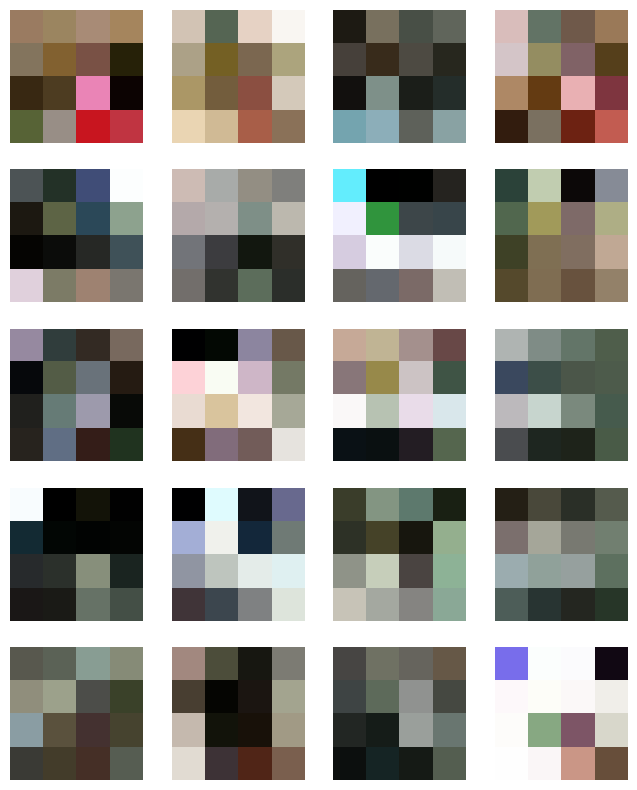

Found 17432 files belonging to 1 classes.


2024-05-05 21:20:48.053840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 21:20:48.054119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 9525 / 15625
D Loss: R: 0.522188 F: -0.501731 GP: 0.128507
G Loss: 0.773263
Batch: 9550 / 15625
D Loss: R: 0.516633 F: -0.530910 GP: 0.056419
G Loss: 0.625971
Batch: 9575 / 15625
D Loss: R: 0.790144 F: -0.699387 GP: 0.086834
G Loss: 0.669266
Batch: 9600 / 15625
D Loss: R: 1.170598 F: -1.178892 GP: 0.099300
G Loss: 1.270222
Batch: 9625 / 15625
D Loss: R: 2.390428 F: -2.327071 GP: 0.082110
G Loss: 2.319965
Batch: 9650 / 15625
D Loss: R: 2.039347 F: -1.992929 GP: 0.160461
G Loss: 2.406717
Batch: 9675 / 15625
D Loss: R: 2.512333 F: -2.464138 GP: 0.101599
G Loss: 2.505373
Batch: 9700 / 15625
D Loss: R: 2.835663 F: -2.806109 GP: 0.068951
G Loss: 2.523051
Batch: 9725 / 15625
D Loss: R: 2.761359 F: -2.721355 GP: 0.071251
G Loss: 2.755839
Batch: 9750 / 15625
D Loss: R: 2.475509 F: -2.444548 GP: 0.099634
G Loss: 2.311083
Batch: 9775 / 15625
D Loss: R: 2.414482 F: -2.379118 GP: 0.090541
G Loss: 2.460673
Found 17432 files belonging to 1 classes.


2024-05-05 21:27:28.059342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 21:27:28.059630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 9800 / 15625
D Loss: R: 2.305070 F: -2.354316 GP: 0.046213
G Loss: 2.017972
Batch: 9825 / 15625
D Loss: R: 2.257571 F: -2.206551 GP: 0.126684
G Loss: 2.361622
Batch: 9850 / 15625
D Loss: R: 3.097868 F: -3.064794 GP: 0.117377
G Loss: 3.362254
Batch: 9875 / 15625
D Loss: R: 1.901790 F: -1.898976 GP: 0.092228
G Loss: 1.887061
Batch: 9900 / 15625
D Loss: R: 1.625326 F: -1.637033 GP: 0.109532
G Loss: 1.812676
Batch: 9925 / 15625
D Loss: R: 2.987464 F: -2.697952 GP: 0.206780
G Loss: 2.320330
Batch: 9950 / 15625
D Loss: R: 1.405759 F: -1.405566 GP: 0.046996
G Loss: 1.425521
Batch: 9975 / 15625
D Loss: R: 1.705075 F: -1.657885 GP: 0.064720
G Loss: 1.757347
Batch: 10000 / 15625
D Loss: R: 1.703392 F: -1.653255 GP: 0.083183
G Loss: 1.758689
Saving weights...
Done.
1/1 [==============================] - 0s 23ms/step


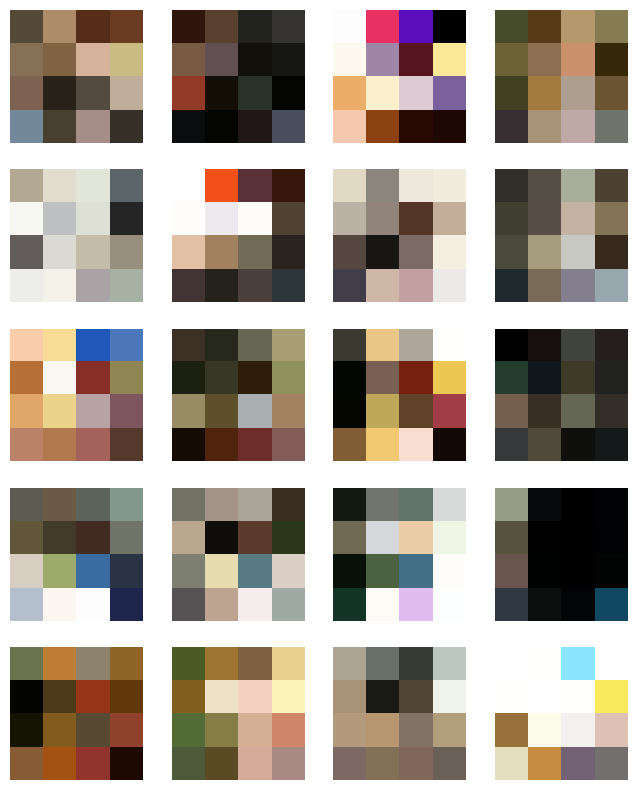

Batch: 10025 / 15625
D Loss: R: 1.850303 F: -1.814126 GP: 0.046173
G Loss: 2.074939
Batch: 10050 / 15625
D Loss: R: 1.751621 F: -1.723179 GP: 0.032094
G Loss: 1.964464
Found 17432 files belonging to 1 classes.


2024-05-05 21:34:07.217695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 21:34:07.218044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 10075 / 15625
D Loss: R: 1.769059 F: -1.741595 GP: 0.072269
G Loss: 1.806403
Batch: 10100 / 15625
D Loss: R: 1.931326 F: -1.972370 GP: 0.048973
G Loss: 2.094576
Batch: 10125 / 15625
D Loss: R: 1.778495 F: -1.815240 GP: 0.080411
G Loss: 1.607844
Batch: 10150 / 15625
D Loss: R: 1.577130 F: -1.578685 GP: 0.070652
G Loss: 1.503850
Batch: 10175 / 15625
D Loss: R: 1.402455 F: -1.362862 GP: 0.045835
G Loss: 1.555127
Batch: 10200 / 15625
D Loss: R: 1.273226 F: -1.261005 GP: 0.171011
G Loss: 1.409752
Batch: 10225 / 15625
D Loss: R: 1.507394 F: -1.464517 GP: 0.058150
G Loss: 1.514351
Batch: 10250 / 15625
D Loss: R: 2.000699 F: -1.901928 GP: 0.141437
G Loss: 2.050089
Batch: 10275 / 15625
D Loss: R: 1.791428 F: -1.766508 GP: 0.083088
G Loss: 1.699520
Batch: 10300 / 15625
D Loss: R: 1.968334 F: -1.945036 GP: 0.061541
G Loss: 2.025948
Batch: 10325 / 15625
D Loss: R: 2.187951 F: -2.125042 GP: 0.058786
G Loss: 1.986472
Found 17432 files belonging to 1 classes.


2024-05-05 21:40:46.941388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 21:40:46.941683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 10350 / 15625
D Loss: R: 2.282179 F: -2.189233 GP: 0.142958
G Loss: 2.060315
Batch: 10375 / 15625
D Loss: R: 2.741024 F: -2.633039 GP: 0.067147
G Loss: 2.565437
Batch: 10400 / 15625
D Loss: R: 3.067162 F: -3.021481 GP: 0.039745
G Loss: 2.804022
Batch: 10425 / 15625
D Loss: R: 3.268592 F: -3.259867 GP: 0.076249
G Loss: 3.255662
Batch: 10450 / 15625
D Loss: R: 3.237659 F: -3.199191 GP: 0.058133
G Loss: 3.383617
Batch: 10475 / 15625
D Loss: R: 3.269895 F: -3.203571 GP: 0.061225
G Loss: 3.228888
Batch: 10500 / 15625
D Loss: R: 3.011741 F: -2.943775 GP: 0.117846
G Loss: 2.298279
1/1 [==============================] - 0s 23ms/step


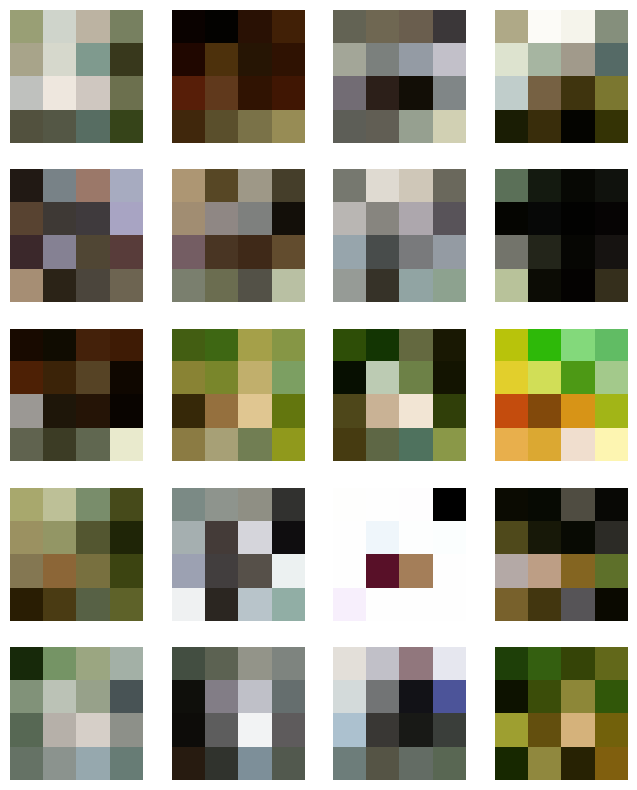

Batch: 10525 / 15625
D Loss: R: 2.634969 F: -2.614953 GP: 0.074177
G Loss: 2.594597
Batch: 10550 / 15625
D Loss: R: 3.319060 F: -3.239196 GP: 0.034568
G Loss: 3.311387
Batch: 10575 / 15625
D Loss: R: 3.426758 F: -3.341802 GP: 0.057253
G Loss: 3.330587
Batch: 10600 / 15625
D Loss: R: 3.519335 F: -3.521080 GP: 0.085220
G Loss: 3.669738
Found 17432 files belonging to 1 classes.


2024-05-05 21:47:27.468543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 21:47:27.468827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 10625 / 15625
D Loss: R: 3.775013 F: -3.731040 GP: 0.090439
G Loss: 3.751743
Batch: 10650 / 15625
D Loss: R: 3.678638 F: -3.600945 GP: 0.141842
G Loss: 3.657783
Batch: 10675 / 15625
D Loss: R: 2.465839 F: -2.465857 GP: 0.108356
G Loss: 2.614419
Batch: 10700 / 15625
D Loss: R: 2.586208 F: -2.561227 GP: 0.077473
G Loss: 2.321507
Batch: 10725 / 15625
D Loss: R: 2.506478 F: -2.438709 GP: 0.060539
G Loss: 2.681235
Batch: 10750 / 15625
D Loss: R: 3.012326 F: -2.954939 GP: 0.058434
G Loss: 3.148766
Batch: 10775 / 15625
D Loss: R: 3.781699 F: -3.665885 GP: 0.061843
G Loss: 3.649787
Batch: 10800 / 15625
D Loss: R: 2.796244 F: -2.800655 GP: 0.049901
G Loss: 2.604952
Batch: 10825 / 15625
D Loss: R: 2.793731 F: -2.812951 GP: 0.073041
G Loss: 2.926523
Batch: 10850 / 15625
D Loss: R: 2.853807 F: -2.835755 GP: 0.152566
G Loss: 2.722204
Batch: 10875 / 15625
D Loss: R: 2.830610 F: -2.799719 GP: 0.075351
G Loss: 2.897524
Found 17432 files belonging to 1 classes.


2024-05-05 21:54:08.331811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 21:54:08.332081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 10900 / 15625
D Loss: R: 3.900646 F: -3.920311 GP: 0.077939
G Loss: 3.959746
Batch: 10925 / 15625
D Loss: R: 3.860851 F: -3.809097 GP: 0.072736
G Loss: 3.808729
Batch: 10950 / 15625
D Loss: R: 3.730777 F: -3.716665 GP: 0.081618
G Loss: 3.734989
Batch: 10975 / 15625
D Loss: R: 3.603840 F: -3.617852 GP: 0.080406
G Loss: 3.613733
Batch: 11000 / 15625
D Loss: R: 3.561161 F: -3.545562 GP: 0.106031
G Loss: 3.527614
Saving weights...
Done.
1/1 [==============================] - 0s 22ms/step


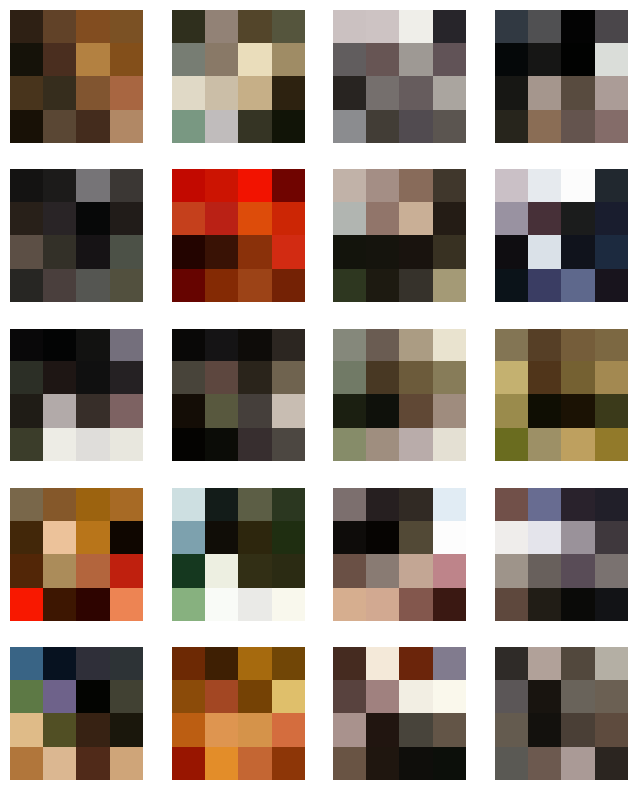

Batch: 11025 / 15625
D Loss: R: 3.562719 F: -3.479355 GP: 0.193149
G Loss: 3.582531
Batch: 11050 / 15625
D Loss: R: 3.785669 F: -3.764234 GP: 0.061598
G Loss: 3.722618
Batch: 11075 / 15625
D Loss: R: 4.225450 F: -4.264079 GP: 0.062323
G Loss: 4.222321
Batch: 11100 / 15625
D Loss: R: 4.375770 F: -4.320154 GP: 0.040993
G Loss: 4.225866
Batch: 11125 / 15625
D Loss: R: 4.531890 F: -4.523263 GP: 0.040046
G Loss: 4.520669
Batch: 11150 / 15625
D Loss: R: 4.570299 F: -4.537909 GP: 0.041347
G Loss: 4.411473
Found 17432 files belonging to 1 classes.


2024-05-05 22:00:50.479755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 22:00:50.480093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 11175 / 15625
D Loss: R: 4.605192 F: -4.614129 GP: 0.033101
G Loss: 4.619731
Batch: 11200 / 15625
D Loss: R: 4.808369 F: -4.776990 GP: 0.116087
G Loss: 4.727429
Batch: 11225 / 15625
D Loss: R: 4.586662 F: -4.609943 GP: 0.065505
G Loss: 4.533450
Batch: 11250 / 15625
D Loss: R: 4.375020 F: -4.397237 GP: 0.065671
G Loss: 4.516778
Batch: 11275 / 15625
D Loss: R: 4.390156 F: -4.360082 GP: 0.061911
G Loss: 4.437354
Batch: 11300 / 15625
D Loss: R: 5.148792 F: -5.089926 GP: 0.080934
G Loss: 5.073659
Batch: 11325 / 15625
D Loss: R: 5.228516 F: -5.212878 GP: 0.096032
G Loss: 5.248441
Batch: 11350 / 15625
D Loss: R: 5.391037 F: -5.431170 GP: 0.062473
G Loss: 5.316319
Batch: 11375 / 15625
D Loss: R: 5.405469 F: -5.370276 GP: 0.048016
G Loss: 5.334482
Batch: 11400 / 15625
D Loss: R: 5.292459 F: -5.256152 GP: 0.125040
G Loss: 5.374215
Found 17432 files belonging to 1 classes.
Batch: 11425 / 15625


2024-05-05 22:07:32.039961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 22:07:32.040258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


D Loss: R: 6.055932 F: -6.024205 GP: 0.074032
G Loss: 5.999465
Batch: 11450 / 15625
D Loss: R: 5.432624 F: -5.447719 GP: 0.154412
G Loss: 5.487187
Batch: 11475 / 15625
D Loss: R: 5.372074 F: -5.364642 GP: 0.247233
G Loss: 5.313479
Batch: 11500 / 15625
D Loss: R: 5.247255 F: -5.159336 GP: 0.117269
G Loss: 5.081474
1/1 [==============================] - 0s 22ms/step


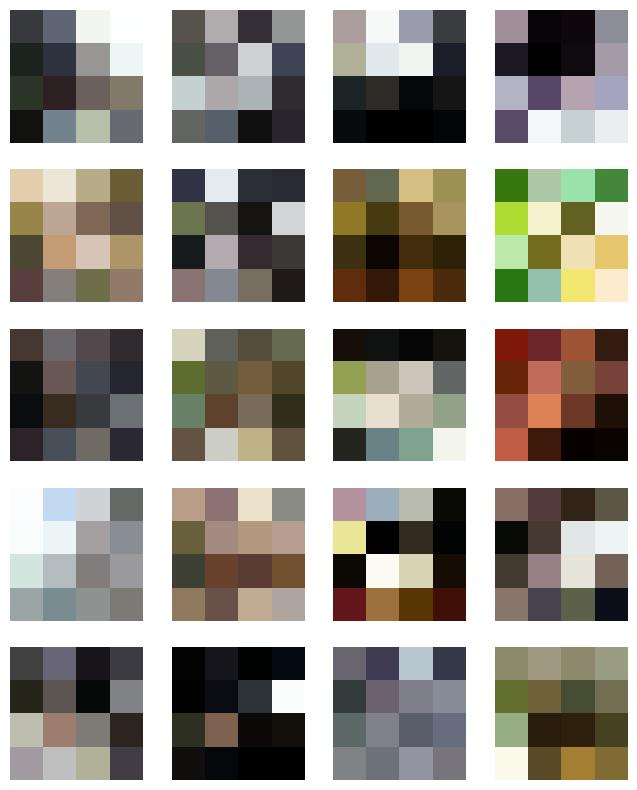

Batch: 11525 / 15625
D Loss: R: 5.363527 F: -5.317035 GP: 0.070041
G Loss: 5.166237
Batch: 11550 / 15625
D Loss: R: 5.301701 F: -5.286870 GP: 0.085777
G Loss: 5.313954
Batch: 11575 / 15625
D Loss: R: 4.856560 F: -4.806145 GP: 0.183429
G Loss: 4.778409
Batch: 11600 / 15625
D Loss: R: 4.552994 F: -4.537271 GP: 0.226302
G Loss: 4.344930
Batch: 11625 / 15625
D Loss: R: 4.618508 F: -4.571766 GP: 0.088991
G Loss: 4.634048
Batch: 11650 / 15625
D Loss: R: 4.812069 F: -4.797857 GP: 0.064211
G Loss: 4.704972
Batch: 11675 / 15625
D Loss: R: 4.735315 F: -4.684320 GP: 0.096049
G Loss: 4.725418
Found 17432 files belonging to 1 classes.


2024-05-05 22:14:10.937369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 22:14:10.937652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 11700 / 15625
D Loss: R: 4.826181 F: -4.859423 GP: 0.066462
G Loss: 4.792475
Batch: 11725 / 15625
D Loss: R: 4.843853 F: -4.865772 GP: 0.110371
G Loss: 4.913734
Batch: 11750 / 15625
D Loss: R: 5.036180 F: -5.052678 GP: 0.286528
G Loss: 4.947960
Batch: 11775 / 15625
D Loss: R: 4.790553 F: -4.739141 GP: 0.166828
G Loss: 4.873865
Batch: 11800 / 15625
D Loss: R: 5.081830 F: -5.060829 GP: 0.133349
G Loss: 5.075109
Batch: 11825 / 15625
D Loss: R: 5.018567 F: -4.995391 GP: 0.165317
G Loss: 4.836862
Batch: 11850 / 15625
D Loss: R: 4.918127 F: -4.902645 GP: 0.058846
G Loss: 4.714322
Batch: 11875 / 15625
D Loss: R: 4.436701 F: -4.455493 GP: 0.179290
G Loss: 4.569901
Batch: 11900 / 15625
D Loss: R: 4.881271 F: -4.819160 GP: 0.101187
G Loss: 4.717291
Batch: 11925 / 15625
D Loss: R: 5.254820 F: -5.232148 GP: 0.154129
G Loss: 5.192313
Batch: 11950 / 15625
D Loss: R: 5.146504 F: -5.119656 GP: 0.065494
G Loss: 5.305170
Found 17432 files belonging to 1 classes.


2024-05-05 22:20:53.496656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 22:20:53.497000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 11975 / 15625
D Loss: R: 5.219478 F: -5.211828 GP: 0.073666
G Loss: 5.100653
Batch: 12000 / 15625
D Loss: R: 4.648886 F: -4.673267 GP: 0.065303
G Loss: 4.641274
Saving weights...
Done.
1/1 [==============================] - 0s 23ms/step


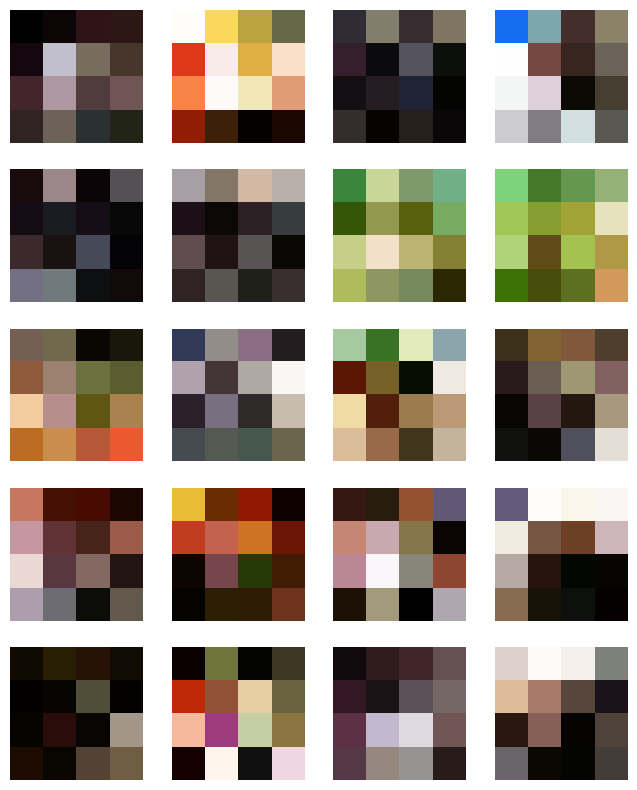

Batch: 12025 / 15625
D Loss: R: 4.326671 F: -4.268620 GP: 0.058589
G Loss: 4.339027
Batch: 12050 / 15625
D Loss: R: 4.208298 F: -4.135837 GP: 0.051069
G Loss: 4.070905
Batch: 12075 / 15625
D Loss: R: 3.731836 F: -3.697806 GP: 0.070855
G Loss: 3.619292
Batch: 12100 / 15625
D Loss: R: 4.249502 F: -4.211493 GP: 0.091564
G Loss: 4.208829
Batch: 12125 / 15625
D Loss: R: 4.247748 F: -4.205510 GP: 0.061504
G Loss: 4.133914
Batch: 12150 / 15625
D Loss: R: 3.813836 F: -3.851923 GP: 0.051218
G Loss: 3.855453
Batch: 12175 / 15625
D Loss: R: 3.641823 F: -3.650412 GP: 0.068257
G Loss: 3.789843
Batch: 12200 / 15625
D Loss: R: 3.283359 F: -3.213727 GP: 0.111615
G Loss: 3.277739
Batch: 12225 / 15625
D Loss: R: 3.125037 F: -3.126536 GP: 0.115804
G Loss: 3.248166
Found 17432 files belonging to 1 classes.


2024-05-05 22:27:34.366094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 22:27:34.366422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 12250 / 15625
D Loss: R: 3.101500 F: -3.131380 GP: 0.082745
G Loss: 3.119848
Batch: 12275 / 15625
D Loss: R: 3.250406 F: -3.222855 GP: 0.064534
G Loss: 3.375828
Batch: 12300 / 15625
D Loss: R: 3.790329 F: -3.760612 GP: 0.137386
G Loss: 3.659351
Batch: 12325 / 15625
D Loss: R: 3.521451 F: -3.424924 GP: 0.047825
G Loss: 3.469986
Batch: 12350 / 15625
D Loss: R: 3.147032 F: -3.107996 GP: 0.095542
G Loss: 3.092463
Batch: 12375 / 15625
D Loss: R: 3.510824 F: -3.525589 GP: 0.110463
G Loss: 3.641082
Batch: 12400 / 15625
D Loss: R: 3.683587 F: -3.694964 GP: 0.045640
G Loss: 3.633382
Batch: 12425 / 15625
D Loss: R: 3.895320 F: -3.923486 GP: 0.077386
G Loss: 3.757389
Batch: 12450 / 15625
D Loss: R: 4.498787 F: -4.427041 GP: 0.042317
G Loss: 4.373191
Batch: 12475 / 15625
D Loss: R: 3.380273 F: -3.350140 GP: 0.045173
G Loss: 3.439175
Batch: 12500 / 15625
D Loss: R: 3.380965 F: -3.406462 GP: 0.144399
G Loss: 3.620822
1/1 [==============================] - 0s 22ms/step


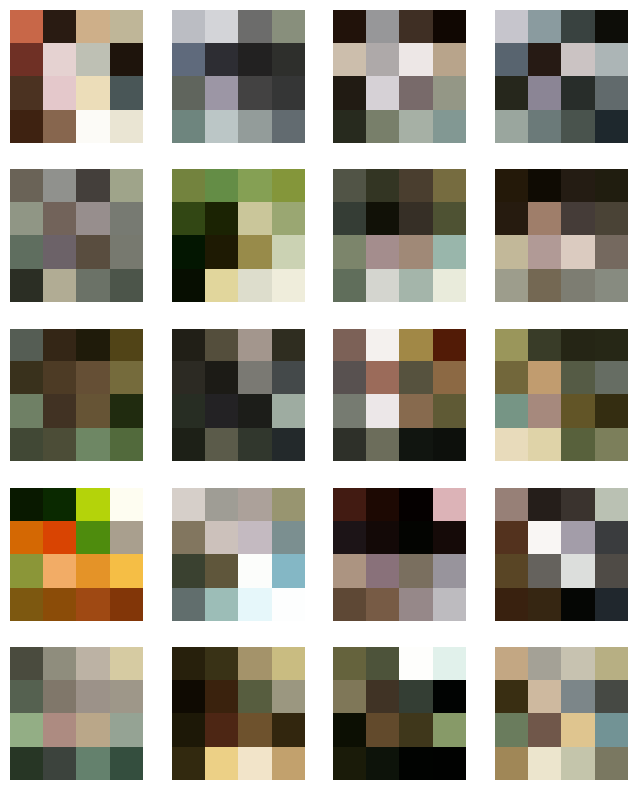

Found 17432 files belonging to 1 classes.


2024-05-05 22:34:14.817128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 22:34:14.817465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 12525 / 15625
D Loss: R: 3.934695 F: -3.904285 GP: 0.046170
G Loss: 3.891641
Batch: 12550 / 15625
D Loss: R: 4.100527 F: -4.091442 GP: 0.084073
G Loss: 4.061973
Batch: 12575 / 15625
D Loss: R: 3.792417 F: -3.819791 GP: 0.044423
G Loss: 3.862388
Batch: 12600 / 15625
D Loss: R: 3.700149 F: -3.730225 GP: 0.203763
G Loss: 3.875505
Batch: 12625 / 15625
D Loss: R: 3.983783 F: -3.982843 GP: 0.085857
G Loss: 3.862238
Batch: 12650 / 15625
D Loss: R: 4.755343 F: -4.784494 GP: 0.063284
G Loss: 4.576187
Batch: 12675 / 15625
D Loss: R: 4.382506 F: -4.369547 GP: 0.122843
G Loss: 4.341419
Batch: 12700 / 15625
D Loss: R: 4.059714 F: -4.053854 GP: 0.056826
G Loss: 3.996120
Batch: 12725 / 15625
D Loss: R: 4.400669 F: -4.429838 GP: 0.074410
G Loss: 4.415694
Batch: 12750 / 15625
D Loss: R: 4.534254 F: -4.484334 GP: 0.049537
G Loss: 4.386922
Batch: 12775 / 15625
D Loss: R: 4.330865 F: -4.300313 GP: 0.113572
G Loss: 4.280477
Found 17432 files belonging to 1 classes.


2024-05-05 22:40:52.471617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 22:40:52.471905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 12800 / 15625
D Loss: R: 3.446313 F: -3.435159 GP: 0.028210
G Loss: 3.428996
Batch: 12825 / 15625
D Loss: R: 3.787519 F: -3.795912 GP: 0.114761
G Loss: 3.763054
Batch: 12850 / 15625
D Loss: R: 4.351728 F: -4.324504 GP: 0.053867
G Loss: 4.345209
Batch: 12875 / 15625
D Loss: R: 4.890426 F: -4.916594 GP: 0.064349
G Loss: 4.761820
Batch: 12900 / 15625
D Loss: R: 4.749760 F: -4.749744 GP: 0.070696
G Loss: 4.539142
Batch: 12925 / 15625
D Loss: R: 4.154754 F: -4.163067 GP: 0.055214
G Loss: 4.205220
Batch: 12950 / 15625
D Loss: R: 3.948584 F: -3.957312 GP: 0.081152
G Loss: 3.919642
Batch: 12975 / 15625
D Loss: R: 4.261522 F: -4.209429 GP: 0.056215
G Loss: 4.301699
Batch: 13000 / 15625
D Loss: R: 4.292244 F: -4.298163 GP: 0.049227
G Loss: 4.416502
Saving weights...
Done.
1/1 [==============================] - 0s 22ms/step


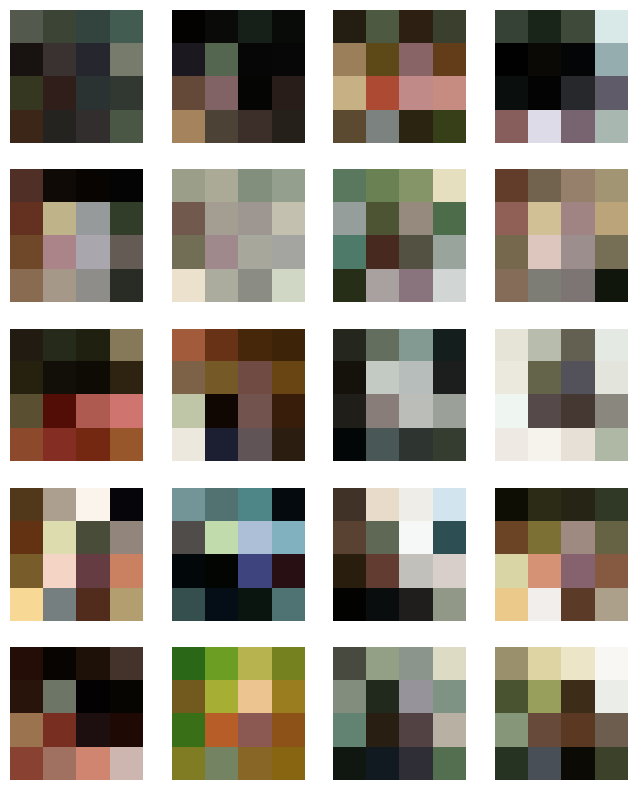

Batch: 13025 / 15625
D Loss: R: 4.728141 F: -4.713396 GP: 0.054454
G Loss: 4.378364
Batch: 13050 / 15625
D Loss: R: 4.386494 F: -4.287661 GP: 0.282285
G Loss: 4.292928
Found 17432 files belonging to 1 classes.


2024-05-05 22:47:33.878196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 22:47:33.878470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 13075 / 15625
D Loss: R: 4.162203 F: -4.160124 GP: 0.044638
G Loss: 3.973837
Batch: 13100 / 15625
D Loss: R: 4.165001 F: -4.100511 GP: 0.100064
G Loss: 4.167542
Batch: 13125 / 15625
D Loss: R: 4.437119 F: -4.461727 GP: 0.062507
G Loss: 4.375742
Batch: 13150 / 15625
D Loss: R: 4.655251 F: -4.687761 GP: 0.262377
G Loss: 4.678637
Batch: 13175 / 15625
D Loss: R: 4.415330 F: -4.407335 GP: 0.079547
G Loss: 4.263772
Batch: 13200 / 15625
D Loss: R: 4.076624 F: -3.992768 GP: 0.047812
G Loss: 4.116784
Batch: 13225 / 15625
D Loss: R: 4.061210 F: -4.015468 GP: 0.085099
G Loss: 4.160151
Batch: 13250 / 15625
D Loss: R: 3.894372 F: -3.817022 GP: 0.084552
G Loss: 3.855555
Batch: 13275 / 15625
D Loss: R: 3.868892 F: -3.817980 GP: 0.100152
G Loss: 3.858083
Batch: 13300 / 15625
D Loss: R: 3.707963 F: -3.660750 GP: 0.042602
G Loss: 3.697546
Batch: 13325 / 15625
D Loss: R: 3.913708 F: -3.933034 GP: 0.088556
G Loss: 3.893044
Found 17432 files belonging to 1 classes.


2024-05-05 22:54:12.908263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 22:54:12.908529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 13350 / 15625
D Loss: R: 4.305529 F: -4.249376 GP: 0.058376
G Loss: 4.230741
Batch: 13375 / 15625
D Loss: R: 4.537321 F: -4.486253 GP: 0.054709
G Loss: 4.454516
Batch: 13400 / 15625
D Loss: R: 4.318926 F: -4.219713 GP: 0.062050
G Loss: 4.310932
Batch: 13425 / 15625
D Loss: R: 4.106554 F: -4.021305 GP: 0.079801
G Loss: 4.205932
Batch: 13450 / 15625
D Loss: R: 4.912381 F: -4.838330 GP: 0.035805
G Loss: 4.817872
Batch: 13475 / 15625
D Loss: R: 4.934178 F: -4.869754 GP: 0.039418
G Loss: 4.949100
Batch: 13500 / 15625
D Loss: R: 4.663579 F: -4.695143 GP: 0.050580
G Loss: 4.522954
1/1 [==============================] - 0s 24ms/step


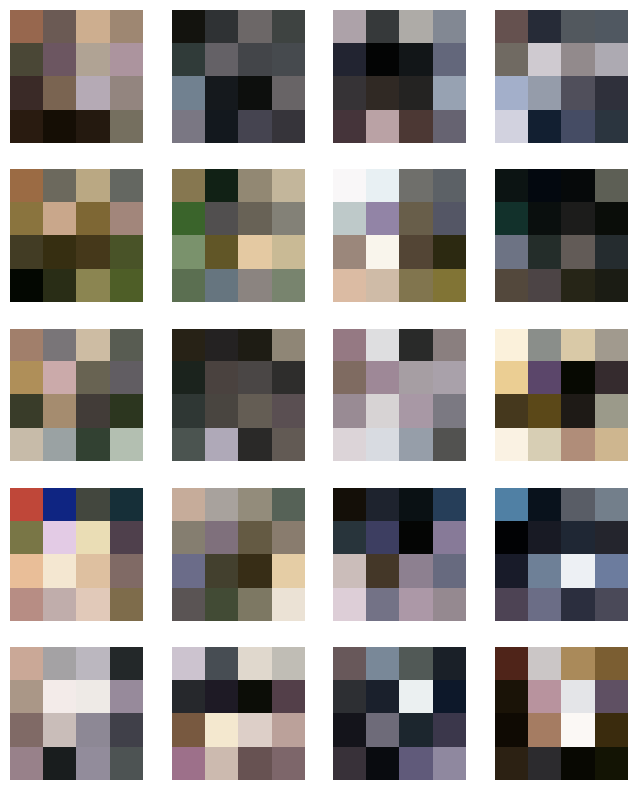

Batch: 13525 / 15625
D Loss: R: 4.361154 F: -4.343062 GP: 0.062970
G Loss: 4.291155
Batch: 13550 / 15625
D Loss: R: 4.105638 F: -4.139582 GP: 0.109973
G Loss: 4.228310
Batch: 13575 / 15625
D Loss: R: 4.514166 F: -4.514091 GP: 0.040694
G Loss: 4.481329
Batch: 13600 / 15625
D Loss: R: 4.638482 F: -4.589362 GP: 0.061753
G Loss: 4.615287
Found 17432 files belonging to 1 classes.


2024-05-05 23:00:53.851850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 23:00:53.852140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 13625 / 15625
D Loss: R: 4.655510 F: -4.640098 GP: 0.068445
G Loss: 4.454525
Batch: 13650 / 15625
D Loss: R: 3.971335 F: -3.968180 GP: 0.042956
G Loss: 3.913073
Batch: 13675 / 15625
D Loss: R: 4.233131 F: -4.176378 GP: 0.143655
G Loss: 4.180274
Batch: 13700 / 15625
D Loss: R: 4.470380 F: -4.461866 GP: 0.045625
G Loss: 4.375040
Batch: 13725 / 15625
D Loss: R: 4.072566 F: -4.013898 GP: 0.091141
G Loss: 4.190419
Batch: 13750 / 15625
D Loss: R: 4.467371 F: -4.444293 GP: 0.028423
G Loss: 4.669343
Batch: 13775 / 15625
D Loss: R: 4.421049 F: -4.384025 GP: 0.052746
G Loss: 4.353401
Batch: 13800 / 15625
D Loss: R: 4.545543 F: -4.522378 GP: 0.181971
G Loss: 4.456740
Batch: 13825 / 15625
D Loss: R: 4.683262 F: -4.686616 GP: 0.039987
G Loss: 4.722697
Batch: 13850 / 15625
D Loss: R: 4.818379 F: -4.794229 GP: 0.045282
G Loss: 4.847438
Found 17432 files belonging to 1 classes.


2024-05-05 23:07:33.796978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 23:07:33.797289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 13875 / 15625
D Loss: R: 4.831418 F: -4.739525 GP: 0.145794
G Loss: 4.846811
Batch: 13900 / 15625
D Loss: R: 4.439100 F: -4.323124 GP: 0.139694
G Loss: 4.186355
Batch: 13925 / 15625
D Loss: R: 4.111580 F: -4.113720 GP: 0.045570
G Loss: 4.186446
Batch: 13950 / 15625
D Loss: R: 4.908477 F: -4.856005 GP: 0.062434
G Loss: 4.800473
Batch: 13975 / 15625
D Loss: R: 5.082067 F: -5.017076 GP: 0.055846
G Loss: 5.093405
Batch: 14000 / 15625
D Loss: R: 4.587178 F: -4.560305 GP: 0.026078
G Loss: 4.541954
Saving weights...
Done.
1/1 [==============================] - 0s 23ms/step


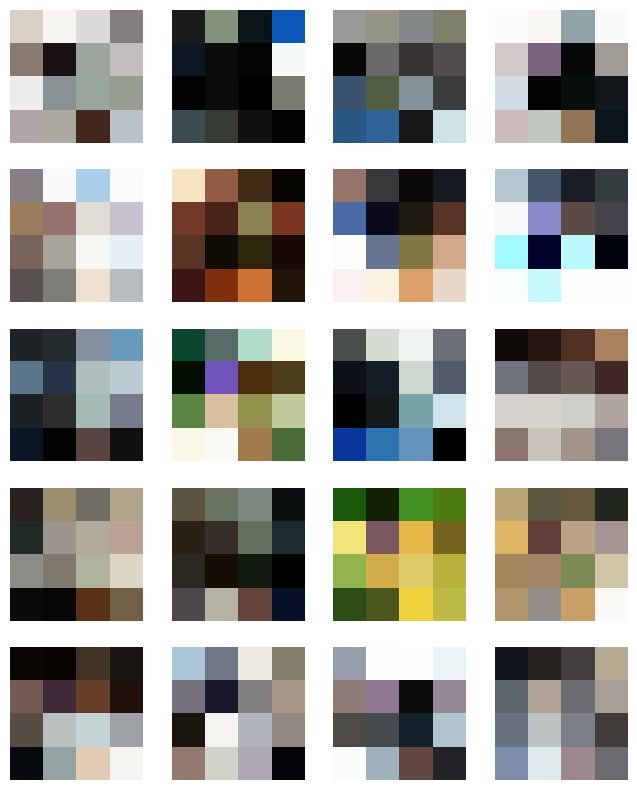

Batch: 14025 / 15625
D Loss: R: 4.806566 F: -4.828126 GP: 0.044906
G Loss: 4.908758
Batch: 14050 / 15625
D Loss: R: 4.772542 F: -4.708647 GP: 0.058160
G Loss: 4.754049
Batch: 14075 / 15625
D Loss: R: 4.671087 F: -4.619615 GP: 0.080349
G Loss: 4.545047
Batch: 14100 / 15625
D Loss: R: 4.042298 F: -3.989641 GP: 0.120174
G Loss: 3.911317
Batch: 14125 / 15625
D Loss: R: 3.841752 F: -3.791160 GP: 0.160172
G Loss: 3.840182
Found 17432 files belonging to 1 classes.


2024-05-05 23:14:14.879077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 23:14:14.879400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 14150 / 15625
D Loss: R: 4.248786 F: -4.238590 GP: 0.083266
G Loss: 4.148184
Batch: 14175 / 15625
D Loss: R: 4.520032 F: -4.524955 GP: 0.052642
G Loss: 4.410320
Batch: 14200 / 15625
D Loss: R: 4.642959 F: -4.641873 GP: 0.055415
G Loss: 4.530122
Batch: 14225 / 15625
D Loss: R: 4.395158 F: -4.414679 GP: 0.058873
G Loss: 4.475985
Batch: 14250 / 15625
D Loss: R: 3.853345 F: -3.792732 GP: 0.085082
G Loss: 3.769517
Batch: 14275 / 15625
D Loss: R: 4.035108 F: -4.078975 GP: 0.041521
G Loss: 4.216214
Batch: 14300 / 15625
D Loss: R: 4.374126 F: -4.388004 GP: 0.236884
G Loss: 4.356459
Batch: 14325 / 15625
D Loss: R: 4.380945 F: -4.356284 GP: 0.052309
G Loss: 4.201313
Batch: 14350 / 15625
D Loss: R: 4.351826 F: -4.375028 GP: 0.065918
G Loss: 4.507991
Batch: 14375 / 15625
D Loss: R: 4.343350 F: -4.334831 GP: 0.058109
G Loss: 4.374026
Batch: 14400 / 15625
D Loss: R: 4.200687 F: -4.160412 GP: 0.045056
G Loss: 4.050228
Found 17432 files belonging to 1 classes.


2024-05-05 23:20:54.825796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 23:20:54.826062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 14425 / 15625
D Loss: R: 3.638948 F: -3.593120 GP: 0.042630
G Loss: 3.528942
Batch: 14450 / 15625
D Loss: R: 3.526542 F: -3.530719 GP: 0.045656
G Loss: 3.896738
Batch: 14475 / 15625
D Loss: R: 4.412027 F: -4.382766 GP: 0.213309
G Loss: 4.391704
Batch: 14500 / 15625
D Loss: R: 3.949359 F: -3.936912 GP: 0.062835
G Loss: 3.973620
1/1 [==============================] - 0s 22ms/step


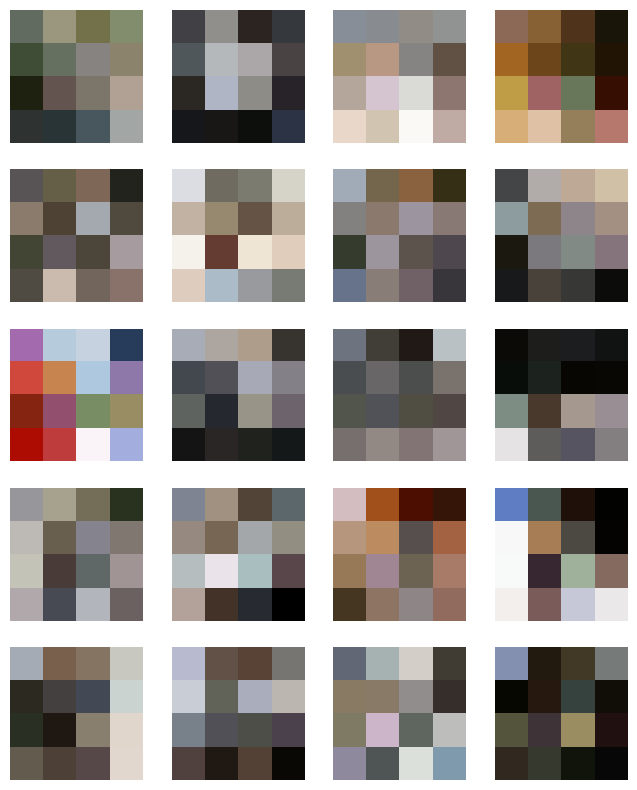

Batch: 14525 / 15625
D Loss: R: 4.599941 F: -4.554711 GP: 0.045580
G Loss: 4.538371
Batch: 14550 / 15625
D Loss: R: 4.348776 F: -4.305411 GP: 0.093181
G Loss: 4.204368
Batch: 14575 / 15625
D Loss: R: 4.356234 F: -4.330117 GP: 0.042795
G Loss: 4.187124
Batch: 14600 / 15625
D Loss: R: 3.889207 F: -3.910958 GP: 0.080039
G Loss: 3.912692
Batch: 14625 / 15625
D Loss: R: 4.846890 F: -4.739851 GP: 0.044937
G Loss: 4.772308
Batch: 14650 / 15625
D Loss: R: 4.737792 F: -4.685119 GP: 0.063280
G Loss: 4.695302
Batch: 14675 / 15625
D Loss: R: 4.851850 F: -4.843335 GP: 0.047880
G Loss: 4.885439
Found 17432 files belonging to 1 classes.


2024-05-05 23:27:35.572425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 23:27:35.572714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 14700 / 15625
D Loss: R: 4.602586 F: -4.585660 GP: 0.071250
G Loss: 4.555958
Batch: 14725 / 15625
D Loss: R: 5.114282 F: -5.143986 GP: 0.086430
G Loss: 5.112403
Batch: 14750 / 15625
D Loss: R: 5.556935 F: -5.503434 GP: 0.041600
G Loss: 5.315722
Batch: 14775 / 15625
D Loss: R: 4.482620 F: -4.481289 GP: 0.068030
G Loss: 4.505713
Batch: 14800 / 15625
D Loss: R: 4.305245 F: -4.288364 GP: 0.060222
G Loss: 4.408488
Batch: 14825 / 15625
D Loss: R: 4.555899 F: -4.511063 GP: 0.035388
G Loss: 4.539683
Batch: 14850 / 15625
D Loss: R: 4.523771 F: -4.481550 GP: 0.047087
G Loss: 4.562716
Batch: 14875 / 15625
D Loss: R: 4.512920 F: -4.503413 GP: 0.055113
G Loss: 4.763409
Batch: 14900 / 15625
D Loss: R: 4.476848 F: -4.497484 GP: 0.057731
G Loss: 4.471806
Batch: 14925 / 15625
D Loss: R: 4.958445 F: -4.921430 GP: 0.018816
G Loss: 4.987724
Batch: 14950 / 15625
D Loss: R: 4.765007 F: -4.716910 GP: 0.078806
G Loss: 4.532236
Found 17432 files belonging to 1 classes.


2024-05-05 23:34:15.036663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 23:34:15.036966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 14975 / 15625
D Loss: R: 4.532750 F: -4.505693 GP: 0.084837
G Loss: 4.575325
Batch: 15000 / 15625
D Loss: R: 4.752831 F: -4.762693 GP: 0.090873
G Loss: 4.851117
Saving weights...
Done.
1/1 [==============================] - 0s 23ms/step


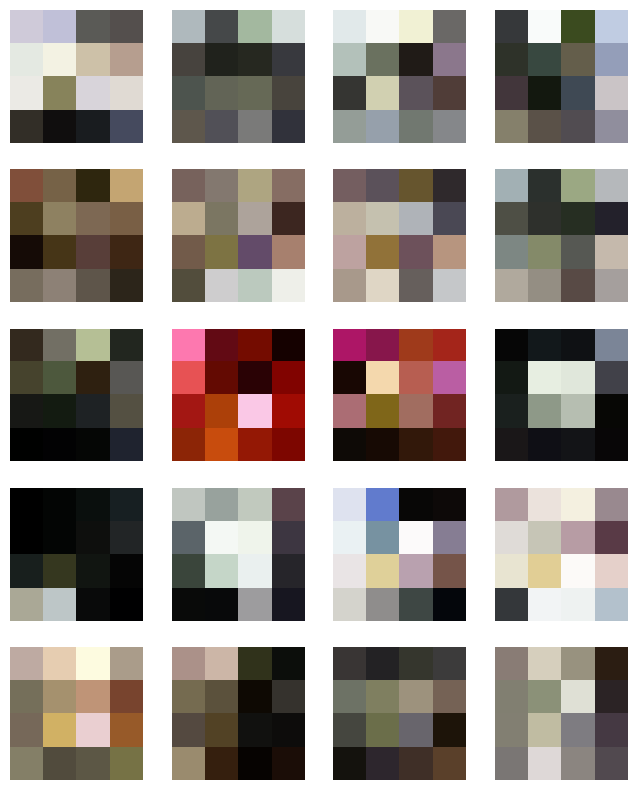

Batch: 15025 / 15625
D Loss: R: 4.465854 F: -4.459961 GP: 0.035495
G Loss: 4.411920
Batch: 15050 / 15625
D Loss: R: 4.510205 F: -4.435009 GP: 0.079135
G Loss: 4.586967
Batch: 15075 / 15625
D Loss: R: 4.587000 F: -4.531622 GP: 0.044866
G Loss: 4.730690
Batch: 15100 / 15625
D Loss: R: 4.363336 F: -4.394049 GP: 0.046373
G Loss: 4.483523
Batch: 15125 / 15625
D Loss: R: 4.360510 F: -4.366269 GP: 0.055620
G Loss: 4.137485
Batch: 15150 / 15625
D Loss: R: 4.712066 F: -4.641596 GP: 0.038001
G Loss: 4.551538
Batch: 15175 / 15625
D Loss: R: 4.187925 F: -4.071319 GP: 0.139832
G Loss: 4.196316
Batch: 15200 / 15625
D Loss: R: 4.456982 F: -4.355731 GP: 0.038050
G Loss: 4.469057
Batch: 15225 / 15625
D Loss: R: 4.715669 F: -4.674266 GP: 0.038066
G Loss: 4.738664
Found 17432 files belonging to 1 classes.


2024-05-05 23:40:55.123869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 23:40:55.124198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 15250 / 15625
D Loss: R: 4.777846 F: -4.782873 GP: 0.226225
G Loss: 4.972371
Batch: 15275 / 15625
D Loss: R: 5.076774 F: -5.018301 GP: 0.096829
G Loss: 4.943836
Batch: 15300 / 15625
D Loss: R: 5.093235 F: -5.082958 GP: 0.057040
G Loss: 5.261849
Batch: 15325 / 15625
D Loss: R: 4.201437 F: -4.176370 GP: 0.035172
G Loss: 4.039418
Batch: 15350 / 15625
D Loss: R: 4.250268 F: -4.223131 GP: 0.038536
G Loss: 4.243954
Batch: 15375 / 15625
D Loss: R: 4.639662 F: -4.591430 GP: 0.087561
G Loss: 4.615249
Batch: 15400 / 15625
D Loss: R: 4.495770 F: -4.489261 GP: 0.050811
G Loss: 4.471658
Batch: 15425 / 15625
D Loss: R: 4.678301 F: -4.691155 GP: 0.054162
G Loss: 4.724878
Batch: 15450 / 15625
D Loss: R: 4.637758 F: -4.623043 GP: 0.080241
G Loss: 4.686537
Batch: 15475 / 15625
D Loss: R: 4.216239 F: -4.104063 GP: 0.125809
G Loss: 4.254060
Batch: 15500 / 15625
D Loss: R: 4.419079 F: -4.432003 GP: 0.045127
G Loss: 4.292356
1/1 [==============================] - 0s 22ms/step


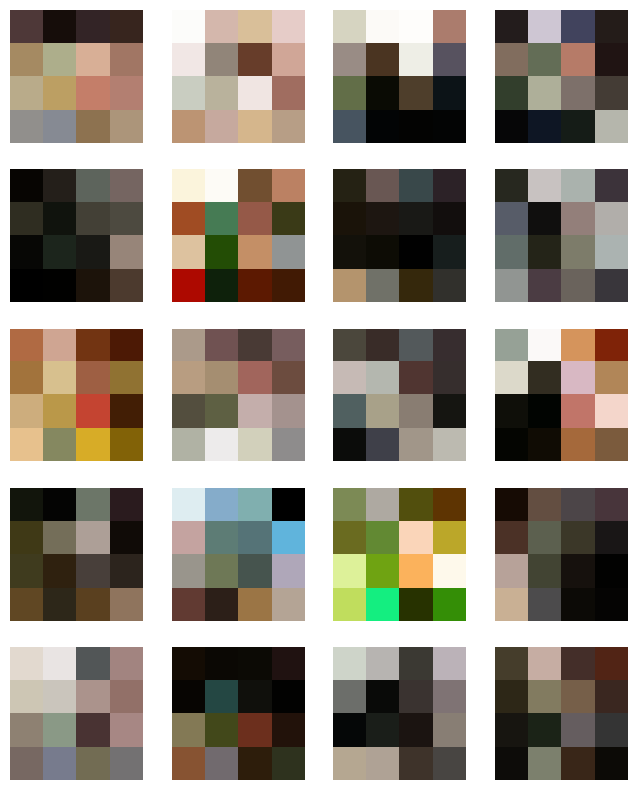

Found 17432 files belonging to 1 classes.


2024-05-05 23:47:34.794137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 23:47:34.794420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


Batch: 15525 / 15625
D Loss: R: 4.406391 F: -4.398587 GP: 0.029164
G Loss: 4.408649
Batch: 15550 / 15625
D Loss: R: 4.536080 F: -4.548864 GP: 0.022003
G Loss: 4.484683
Batch: 15575 / 15625
D Loss: R: 5.155616 F: -5.113506 GP: 0.021814
G Loss: 5.195602
Batch: 15600 / 15625
D Loss: R: 4.771163 F: -4.757145 GP: 0.049244
G Loss: 4.948818
Batch: 15625 / 15625
D Loss: R: 4.760517 F: -4.727096 GP: 0.024690
G Loss: 4.745806
Saving weights...
Done.


In [18]:
train_progan(gan, 4,
             checkpoint_path=base_dir+'4x4/',
             total_kimg=1000)

1/1 [==============================] - 0s 23ms/step


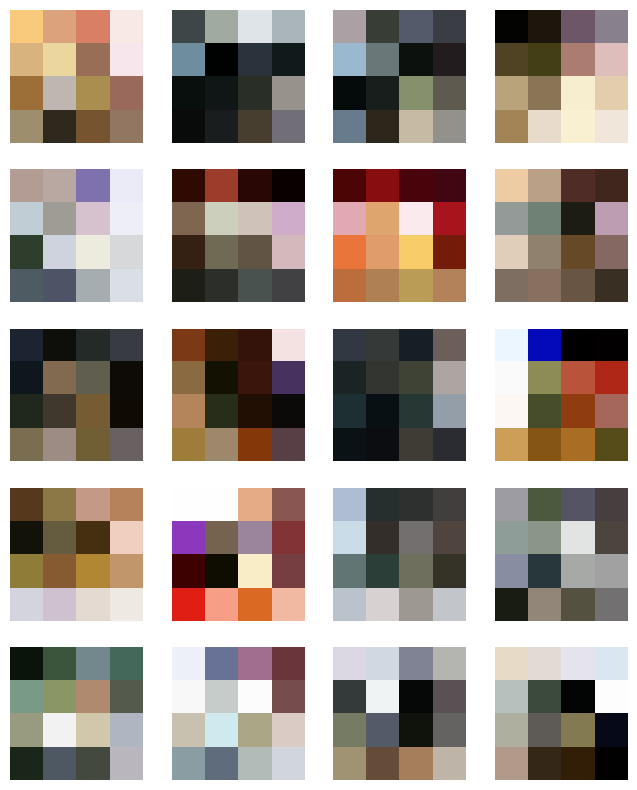

In [20]:
gan.load(4, base_dir+'4x4/')
plot_generated_images(gan, 4, latents_in=latents_test)

Found 17432 files belonging to 1 classes.


2024-05-05 23:58:59.873630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-05 23:58:59.873928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]


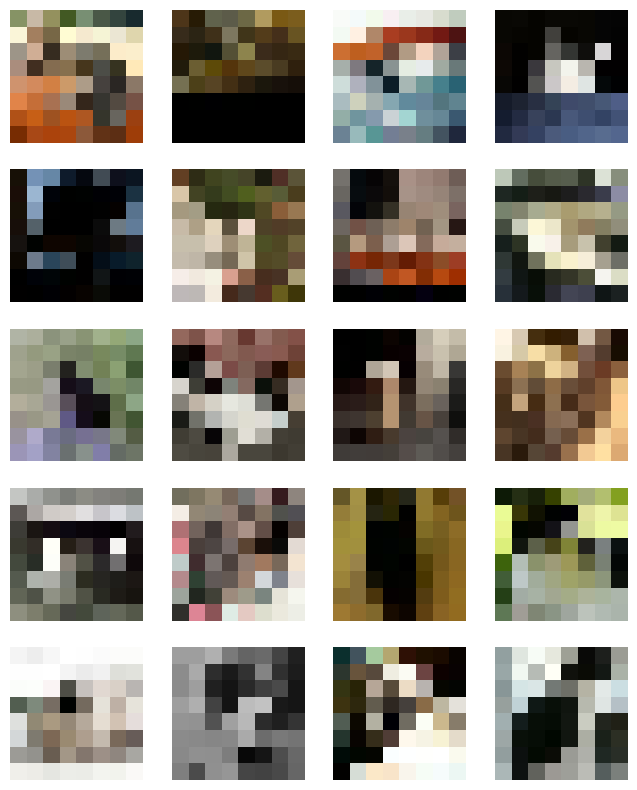

In [21]:
plot_real_images(8)

In [19]:
gan = ProGAN()
gan.load(4, base_dir+'4x4/')

In [20]:
gan.load(4, base_dir+'4x4/')
gan.transfer_previous_resolution_weights(8)

Copied 17307652 parameters to the higher resolution model.


Found 17432 files belonging to 1 classes.


2024-05-06 23:31:47.475690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-06 23:31:47.476008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-06 23:31:47.491593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 25 / 31250
Alpha: 0.0026666666666666666
D Loss: R: 8.980260 F: -8.763586 GP: 1.199476
G Loss: 8.707911
Batch: 50 / 31250
Alpha: 0.005333333333333333
D Loss: R: 2.551147 F: -2.463318 GP: 0.671725
G Loss: 4.642892
Batch: 75 / 31250
Alpha: 0.008
D Loss: R: 1.521578 F: -1.971115 GP: 0.610393
G Loss: 2.922598
Batch: 100 / 31250
Alpha: 0.010666666666666666
D Loss: R: 2.859128 F: -2.845788 GP: 0.560691
G Loss: 3.900991
Batch: 125 / 31250
Alpha: 0.013333333333333334
D Loss: R: 3.644167 F: -3.758531 GP: 0.389276
G Loss: 4.163271
Batch: 150 / 31250
Alpha: 0.016
D Loss: R: 4.461493 F: -4.572374 GP: 0.196916
G Loss: 4.088081
Batch: 175 / 31250
Alpha: 0.018666666666666668
D Loss: R: 3.194477 F: -3.701705 GP: 0.173517
G Loss: 4.140739
Batch: 200 / 31250
Alpha: 0.021333333333333333
D Loss: R: 3.950189 F: -4.617567 GP: 0.294159
G Loss: 4.058293
Batch: 225 / 31250
Alpha: 0.024
D Loss: R: 3.947904 F: -4.143804 GP: 0.332119
G Loss: 3.610643
Batch: 250 / 31250
Alpha: 0.02666666666666667
D Loss: R: 

2024-05-06 23:53:55.713476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-06 23:53:55.713741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-06 23:53:55.729853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 275 / 31250
Alpha: 0.029333333333333333
D Loss: R: 3.969869 F: -4.663054 GP: 0.389317
G Loss: 4.440329
Batch: 300 / 31250
Alpha: 0.032
D Loss: R: 3.758487 F: -4.278119 GP: 0.329296
G Loss: 4.625495
Batch: 325 / 31250
Alpha: 0.034666666666666665
D Loss: R: 4.982450 F: -5.371248 GP: 0.422015
G Loss: 5.034573
Batch: 350 / 31250
Alpha: 0.037333333333333336
D Loss: R: 4.515049 F: -4.858706 GP: 0.703623
G Loss: 4.201941
Batch: 375 / 31250
Alpha: 0.04
D Loss: R: 4.238204 F: -5.091325 GP: 0.328070
G Loss: 4.656570
Batch: 400 / 31250
Alpha: 0.042666666666666665
D Loss: R: 4.577806 F: -5.176866 GP: 0.488152
G Loss: 5.107468
Batch: 425 / 31250
Alpha: 0.04533333333333334
D Loss: R: 2.670582 F: -4.981394 GP: 0.710752
G Loss: 5.559890
Batch: 450 / 31250
Alpha: 0.048
D Loss: R: 2.936537 F: -5.514698 GP: 0.662865
G Loss: 5.184647
Batch: 475 / 31250
Alpha: 0.050666666666666665
D Loss: R: 3.996746 F: -6.572673 GP: 0.831162
G Loss: 6.513474
Batch: 500 / 31250
Alpha: 0.05333333333333334
D Loss: R: 

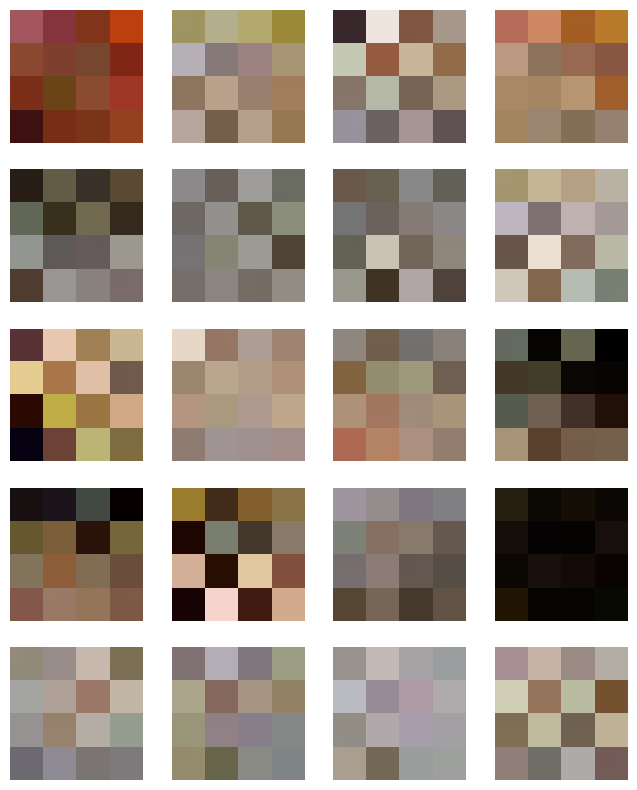

Batch: 525 / 31250
Alpha: 0.056
D Loss: R: 4.508000 F: -6.273665 GP: 0.883034
G Loss: 7.035725
Found 17432 files belonging to 1 classes.


2024-05-07 00:16:04.811951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 00:16:04.812280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 00:16:04.827922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 550 / 31250
Alpha: 0.058666666666666666
D Loss: R: 1.818593 F: -5.188566 GP: 1.112641
G Loss: 5.089405
Batch: 575 / 31250
Alpha: 0.06133333333333333
D Loss: R: 3.274966 F: -6.563007 GP: 1.001101
G Loss: 6.421271
Batch: 600 / 31250
Alpha: 0.064
D Loss: R: 5.171301 F: -7.349277 GP: 1.022482
G Loss: 8.021112
Batch: 625 / 31250
Alpha: 0.06666666666666667
D Loss: R: 5.997848 F: -8.501757 GP: 0.941390
G Loss: 8.429951
Batch: 650 / 31250
Alpha: 0.06933333333333333
D Loss: R: 5.915742 F: -8.468169 GP: 0.481415
G Loss: 8.313601
Batch: 675 / 31250
Alpha: 0.072
D Loss: R: 5.650900 F: -8.603537 GP: 0.609838
G Loss: 8.394608
Batch: 700 / 31250
Alpha: 0.07466666666666667
D Loss: R: 4.576431 F: -7.736785 GP: 1.149297
G Loss: 8.585965
Batch: 725 / 31250
Alpha: 0.07733333333333334
D Loss: R: 5.098766 F: -7.894976 GP: 0.724446
G Loss: 8.083255
Batch: 750 / 31250
Alpha: 0.08
D Loss: R: 4.222488 F: -6.825631 GP: 0.521621
G Loss: 7.532021
Batch: 775 / 31250
Alpha: 0.08266666666666667
D Loss: R: 5.17

2024-05-07 00:38:11.360431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 00:38:11.360695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 00:38:11.376742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 825 / 31250
Alpha: 0.088
D Loss: R: 4.940232 F: -7.972737 GP: 0.925976
G Loss: 8.398399
Batch: 850 / 31250
Alpha: 0.09066666666666667
D Loss: R: 5.415697 F: -8.230282 GP: 0.773349
G Loss: 8.822962
Batch: 875 / 31250
Alpha: 0.09333333333333334
D Loss: R: 3.999714 F: -6.733375 GP: 0.569142
G Loss: 7.581671
Batch: 900 / 31250
Alpha: 0.096
D Loss: R: 3.800278 F: -6.650367 GP: 0.553785
G Loss: 7.148691
Batch: 925 / 31250
Alpha: 0.09866666666666667
D Loss: R: 3.935253 F: -7.234701 GP: 0.786045
G Loss: 7.540394
Batch: 950 / 31250
Alpha: 0.10133333333333333
D Loss: R: 3.772103 F: -6.814453 GP: 0.531405
G Loss: 6.977494
Batch: 975 / 31250
Alpha: 0.104
D Loss: R: 3.999553 F: -6.654571 GP: 0.453210
G Loss: 6.168088
Batch: 1000 / 31250
Alpha: 0.10666666666666667
D Loss: R: 3.174016 F: -6.333302 GP: 0.987117
G Loss: 6.462424
Saving weights...
Done.
1/1 [==============================] - 0s 51ms/step


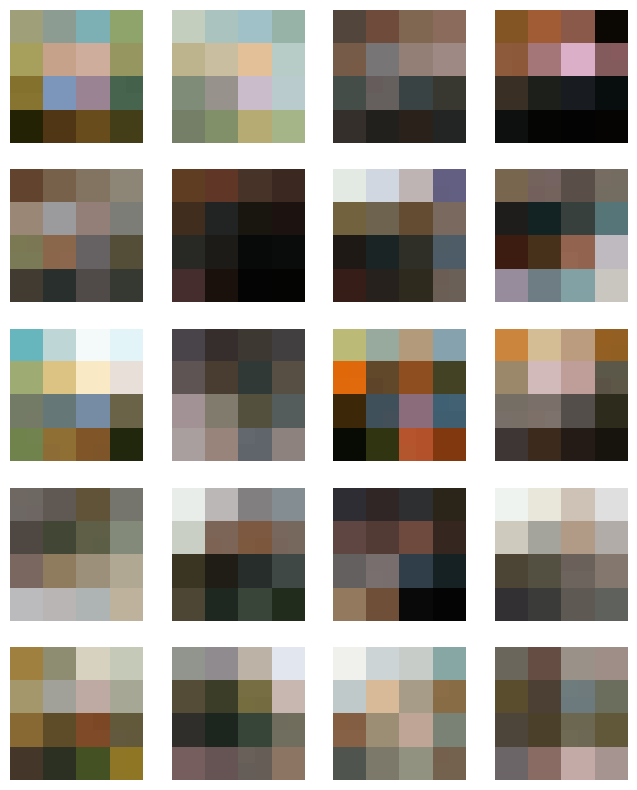

Batch: 1025 / 31250
Alpha: 0.10933333333333334
D Loss: R: 3.096536 F: -5.758585 GP: 0.337589
G Loss: 6.056026
Batch: 1050 / 31250
Alpha: 0.112
D Loss: R: 1.860682 F: -4.986516 GP: 0.499777
G Loss: 5.294547
Batch: 1075 / 31250
Alpha: 0.11466666666666667
D Loss: R: 2.483353 F: -6.100566 GP: 0.747536
G Loss: 5.991154
Found 17432 files belonging to 1 classes.


2024-05-07 01:00:12.466627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 01:00:12.466923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 01:00:12.483308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 1100 / 31250
Alpha: 0.11733333333333333
D Loss: R: 3.431642 F: -6.492839 GP: 0.586965
G Loss: 6.748254
Batch: 1125 / 31250
Alpha: 0.12
D Loss: R: 3.387362 F: -6.227821 GP: 0.288720
G Loss: 6.695150
Batch: 1150 / 31250
Alpha: 0.12266666666666666
D Loss: R: 2.534491 F: -5.949464 GP: 0.296502
G Loss: 6.230842
Batch: 1175 / 31250
Alpha: 0.12533333333333332
D Loss: R: 2.795322 F: -6.057178 GP: 0.517333
G Loss: 5.890382
Batch: 1200 / 31250
Alpha: 0.128
D Loss: R: 3.177141 F: -6.462363 GP: 0.438213
G Loss: 5.161936
Batch: 1225 / 31250
Alpha: 0.13066666666666665
D Loss: R: 3.666336 F: -6.537253 GP: 0.310228
G Loss: 6.466427
Batch: 1250 / 31250
Alpha: 0.13333333333333333
D Loss: R: 4.078331 F: -6.661509 GP: 0.200878
G Loss: 6.638492
Batch: 1275 / 31250
Alpha: 0.136
D Loss: R: 3.282706 F: -6.401044 GP: 0.351443
G Loss: 6.153862
Batch: 1300 / 31250
Alpha: 0.13866666666666666
D Loss: R: 3.447003 F: -6.505294 GP: 0.307705
G Loss: 5.868357
Batch: 1325 / 31250
Alpha: 0.14133333333333334
D Loss

2024-05-07 01:22:04.921801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 01:22:04.922143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 01:22:04.938512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 1375 / 31250
Alpha: 0.14666666666666667
D Loss: R: 4.069535 F: -6.968166 GP: 0.313928
G Loss: 7.782911
Batch: 1400 / 31250
Alpha: 0.14933333333333335
D Loss: R: 4.147361 F: -7.053964 GP: 0.209793
G Loss: 7.949447
Batch: 1425 / 31250
Alpha: 0.152
D Loss: R: 4.472977 F: -7.277151 GP: 0.254737
G Loss: 7.211648
Batch: 1450 / 31250
Alpha: 0.15466666666666667
D Loss: R: 4.144493 F: -6.903166 GP: 0.210503
G Loss: 6.844277
Batch: 1475 / 31250
Alpha: 0.15733333333333333
D Loss: R: 4.038301 F: -7.141503 GP: 0.339675
G Loss: 7.986575
Batch: 1500 / 31250
Alpha: 0.16
D Loss: R: 4.520697 F: -7.420719 GP: 0.294509
G Loss: 7.269799
1/1 [==============================] - 0s 51ms/step


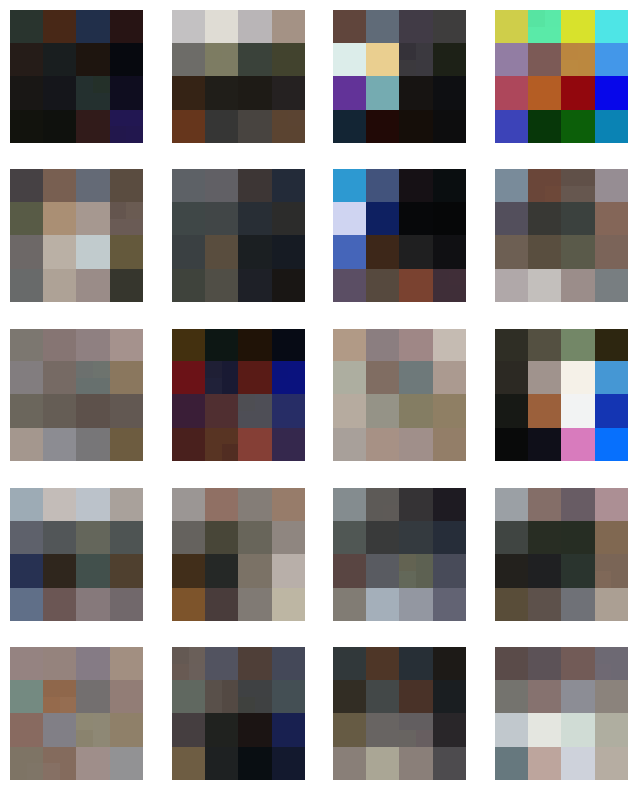

Batch: 1525 / 31250
Alpha: 0.16266666666666665
D Loss: R: 4.709093 F: -7.510629 GP: 0.225496
G Loss: 7.271873
Batch: 1550 / 31250
Alpha: 0.16533333333333333
D Loss: R: 4.098824 F: -6.594023 GP: 0.077749
G Loss: 8.187037
Batch: 1575 / 31250
Alpha: 0.168
D Loss: R: 5.004063 F: -7.214639 GP: 0.231510
G Loss: 7.211755
Batch: 1600 / 31250
Alpha: 0.17066666666666666
D Loss: R: 4.181638 F: -7.340930 GP: 0.438007
G Loss: 7.882864
Batch: 1625 / 31250
Alpha: 0.17333333333333334
D Loss: R: 4.289214 F: -7.756440 GP: 0.642496
G Loss: 7.187298
Found 17432 files belonging to 1 classes.


2024-05-07 01:43:57.004443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 01:43:57.004768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 01:43:57.020770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 1650 / 31250
Alpha: 0.176
D Loss: R: 5.127987 F: -8.061425 GP: 0.589009
G Loss: 7.545432
Batch: 1675 / 31250
Alpha: 0.17866666666666667
D Loss: R: 4.935475 F: -8.006104 GP: 0.653954
G Loss: 7.559107
Batch: 1700 / 31250
Alpha: 0.18133333333333335
D Loss: R: 5.251882 F: -7.853724 GP: 0.204421
G Loss: 7.807466
Batch: 1725 / 31250
Alpha: 0.184
D Loss: R: 5.080718 F: -8.047144 GP: 0.417472
G Loss: 7.055041
Batch: 1750 / 31250
Alpha: 0.18666666666666668
D Loss: R: 4.337809 F: -7.426092 GP: 0.375308
G Loss: 7.041038
Batch: 1775 / 31250
Alpha: 0.18933333333333333
D Loss: R: 4.521987 F: -7.436583 GP: 0.517007
G Loss: 7.580616
Batch: 1800 / 31250
Alpha: 0.192
D Loss: R: 4.709830 F: -7.491051 GP: 0.340463
G Loss: 7.899826
Batch: 1825 / 31250
Alpha: 0.19466666666666665
D Loss: R: 4.760655 F: -7.027209 GP: 0.170339
G Loss: 7.783275
Batch: 1850 / 31250
Alpha: 0.19733333333333333
D Loss: R: 5.369821 F: -7.780864 GP: 0.079412
G Loss: 7.587619
Batch: 1875 / 31250
Alpha: 0.2
D Loss: R: 5.091552 F

2024-05-07 02:05:49.727926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 02:05:49.728197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 02:05:49.744586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 1925 / 31250
Alpha: 0.20533333333333334
D Loss: R: 4.819920 F: -7.751160 GP: 0.284118
G Loss: 7.457366
Batch: 1950 / 31250
Alpha: 0.208
D Loss: R: 5.377222 F: -7.790897 GP: 0.181276
G Loss: 7.348392
Batch: 1975 / 31250
Alpha: 0.21066666666666667
D Loss: R: 5.421739 F: -7.971299 GP: 0.441988
G Loss: 7.321353
Batch: 2000 / 31250
Alpha: 0.21333333333333335
D Loss: R: 5.122118 F: -8.021255 GP: 0.413587
G Loss: 7.593641
Saving weights...
Done.
1/1 [==============================] - 0s 52ms/step


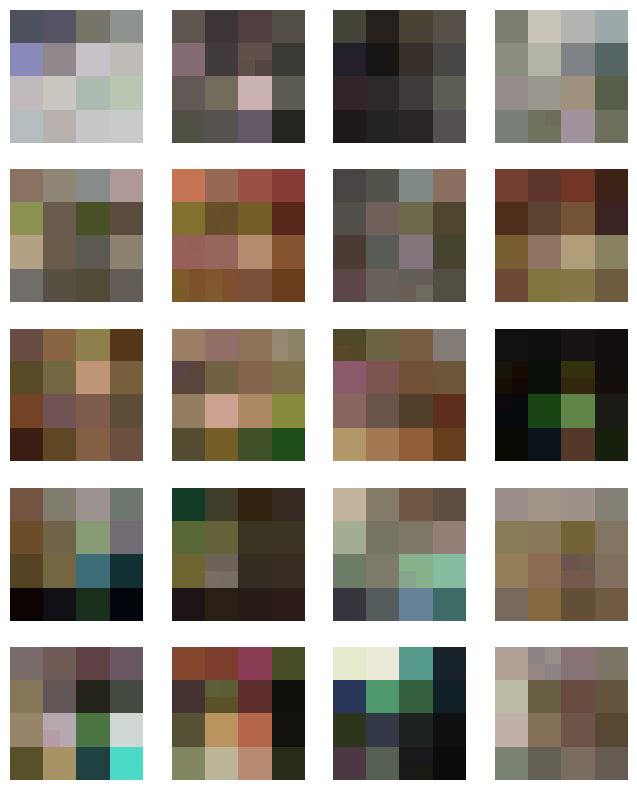

Batch: 2025 / 31250
Alpha: 0.216
D Loss: R: 4.648776 F: -7.398592 GP: 0.336076
G Loss: 7.698213
Batch: 2050 / 31250
Alpha: 0.21866666666666668
D Loss: R: 5.224479 F: -7.692369 GP: 0.196930
G Loss: 7.775111
Batch: 2075 / 31250
Alpha: 0.22133333333333333
D Loss: R: 5.509065 F: -7.914541 GP: 0.318717
G Loss: 7.931046
Batch: 2100 / 31250
Alpha: 0.224
D Loss: R: 5.378232 F: -8.068268 GP: 0.296437
G Loss: 7.757833
Batch: 2125 / 31250
Alpha: 0.22666666666666666
D Loss: R: 5.476283 F: -7.837760 GP: 0.263897
G Loss: 7.939817
Batch: 2150 / 31250
Alpha: 0.22933333333333333
D Loss: R: 5.136190 F: -7.791137 GP: 0.179461
G Loss: 7.553158
Batch: 2175 / 31250
Alpha: 0.232
D Loss: R: 4.653025 F: -7.333833 GP: 0.310774
G Loss: 7.810121
Found 17432 files belonging to 1 classes.


2024-05-07 02:27:41.046827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 02:27:41.047166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 02:27:41.063193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 2200 / 31250
Alpha: 0.23466666666666666
D Loss: R: 5.482685 F: -7.567941 GP: 0.105456
G Loss: 7.283837
Batch: 2225 / 31250
Alpha: 0.23733333333333334
D Loss: R: 5.394858 F: -7.812603 GP: 0.119285
G Loss: 7.943662
Batch: 2250 / 31250
Alpha: 0.24
D Loss: R: 5.839160 F: -7.942705 GP: 0.116936
G Loss: 8.072291
Batch: 2275 / 31250
Alpha: 0.24266666666666667
D Loss: R: 5.656971 F: -7.998849 GP: 0.225015
G Loss: 8.047291
Batch: 2300 / 31250
Alpha: 0.24533333333333332
D Loss: R: 5.652434 F: -7.902730 GP: 0.192326
G Loss: 8.022100
Batch: 2325 / 31250
Alpha: 0.248
D Loss: R: 5.100486 F: -6.903235 GP: 0.140153
G Loss: 8.079375
Batch: 2350 / 31250
Alpha: 0.25066666666666665
D Loss: R: 5.733939 F: -7.956870 GP: 0.127236
G Loss: 8.295331
Batch: 2375 / 31250
Alpha: 0.25333333333333335
D Loss: R: 5.546605 F: -8.006197 GP: 0.312800
G Loss: 7.747811
Batch: 2400 / 31250
Alpha: 0.256
D Loss: R: 5.909321 F: -8.047167 GP: 0.137352
G Loss: 8.300527
Batch: 2425 / 31250
Alpha: 0.25866666666666666
D Loss

2024-05-07 02:49:31.308597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 02:49:31.308887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 02:49:31.325076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 2450 / 31250
Alpha: 0.2613333333333333
D Loss: R: 6.220298 F: -8.221281 GP: 0.176656
G Loss: 7.952081
Batch: 2475 / 31250
Alpha: 0.264
D Loss: R: 6.470998 F: -8.277662 GP: 0.114480
G Loss: 8.123611
Batch: 2500 / 31250
Alpha: 0.26666666666666666
D Loss: R: 5.717889 F: -7.975475 GP: 0.353842
G Loss: 7.952856
1/1 [==============================] - 0s 50ms/step


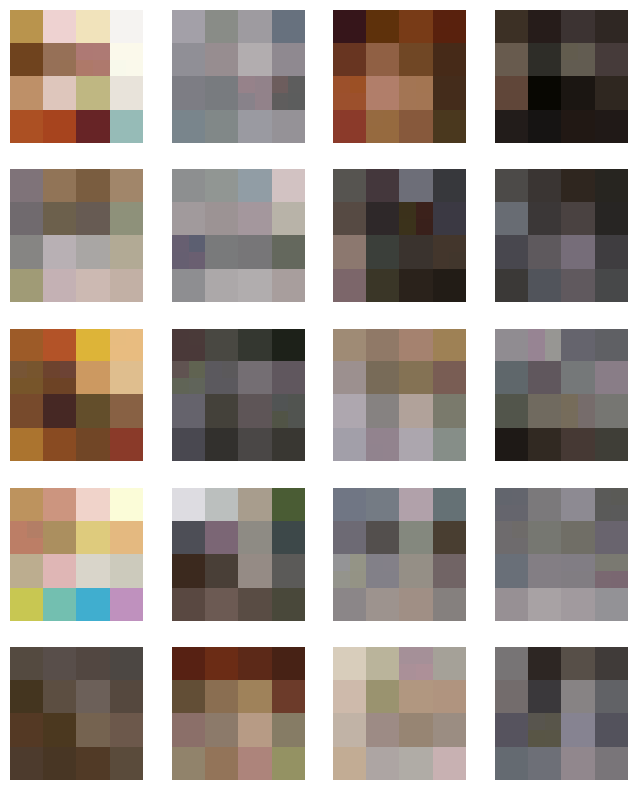

Batch: 2525 / 31250
Alpha: 0.2693333333333333
D Loss: R: 6.385499 F: -8.409480 GP: 0.125747
G Loss: 8.534074
Batch: 2550 / 31250
Alpha: 0.272
D Loss: R: 6.237042 F: -8.172778 GP: 0.131579
G Loss: 8.473492
Batch: 2575 / 31250
Alpha: 0.27466666666666667
D Loss: R: 5.860528 F: -7.911726 GP: 0.128231
G Loss: 8.321202
Batch: 2600 / 31250
Alpha: 0.2773333333333333
D Loss: R: 5.986409 F: -7.953462 GP: 0.145409
G Loss: 7.814025
Batch: 2625 / 31250
Alpha: 0.28
D Loss: R: 6.341765 F: -8.005293 GP: 0.223819
G Loss: 8.256336
Batch: 2650 / 31250
Alpha: 0.2826666666666667
D Loss: R: 6.105611 F: -8.162377 GP: 0.140175
G Loss: 8.188648
Batch: 2675 / 31250
Alpha: 0.2853333333333333
D Loss: R: 6.346433 F: -7.943863 GP: 0.073910
G Loss: 7.959547
Batch: 2700 / 31250
Alpha: 0.288
D Loss: R: 5.776000 F: -8.058050 GP: 0.456592
G Loss: 7.795880
Found 17432 files belonging to 1 classes.


2024-05-07 03:11:22.237841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 03:11:22.238184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 03:11:22.254332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 2725 / 31250
Alpha: 0.2906666666666667
D Loss: R: 7.308883 F: -8.843748 GP: 0.257766
G Loss: 8.458353
Batch: 2750 / 31250
Alpha: 0.29333333333333333
D Loss: R: 6.407614 F: -8.683928 GP: 0.240963
G Loss: 8.298946
Batch: 2775 / 31250
Alpha: 0.296
D Loss: R: 5.753914 F: -7.621189 GP: 0.299828
G Loss: 7.616194
Batch: 2800 / 31250
Alpha: 0.2986666666666667
D Loss: R: 6.715005 F: -8.509903 GP: 0.245053
G Loss: 8.692692
Batch: 2825 / 31250
Alpha: 0.30133333333333334
D Loss: R: 7.081961 F: -8.673087 GP: 0.078645
G Loss: 8.456884
Batch: 2850 / 31250
Alpha: 0.304
D Loss: R: 6.804752 F: -8.507492 GP: 0.113078
G Loss: 8.378956
Batch: 2875 / 31250
Alpha: 0.30666666666666664
D Loss: R: 6.104414 F: -7.864876 GP: 0.146464
G Loss: 8.562528
Batch: 2900 / 31250
Alpha: 0.30933333333333335
D Loss: R: 6.748786 F: -8.284384 GP: 0.150944
G Loss: 8.347383
Batch: 2925 / 31250
Alpha: 0.312
D Loss: R: 6.791782 F: -8.191922 GP: 0.147535
G Loss: 8.604361
Batch: 2950 / 31250
Alpha: 0.31466666666666665
D Loss:

2024-05-07 03:33:16.555781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 03:33:16.556075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 03:33:16.572612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 3000 / 31250
Alpha: 0.32
D Loss: R: 7.228346 F: -8.772120 GP: 0.132809
G Loss: 8.766544
Saving weights...
Done.
1/1 [==============================] - 0s 53ms/step


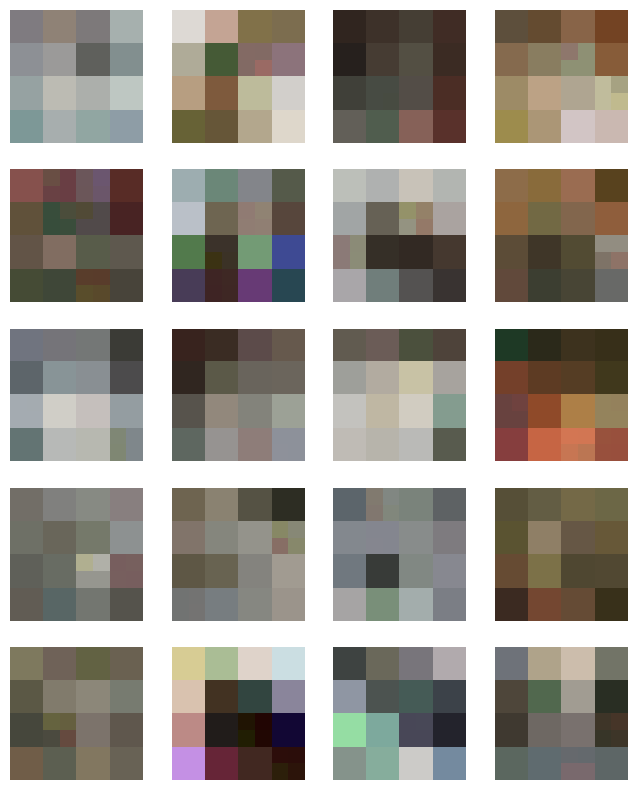

Batch: 3025 / 31250
Alpha: 0.32266666666666666
D Loss: R: 6.909180 F: -8.448554 GP: 0.102052
G Loss: 8.403643
Batch: 3050 / 31250
Alpha: 0.3253333333333333
D Loss: R: 6.907253 F: -8.645693 GP: 0.186099
G Loss: 8.766316
Batch: 3075 / 31250
Alpha: 0.328
D Loss: R: 7.951731 F: -9.232998 GP: 0.100152
G Loss: 9.844341
Batch: 3100 / 31250
Alpha: 0.33066666666666666
D Loss: R: 7.455630 F: -9.222387 GP: 0.106617
G Loss: 9.019312
Batch: 3125 / 31250
Alpha: 0.3333333333333333
D Loss: R: 7.080009 F: -8.771479 GP: 0.211094
G Loss: 9.060114
Batch: 3150 / 31250
Alpha: 0.336
D Loss: R: 7.081716 F: -8.712614 GP: 0.124540
G Loss: 8.780502
Batch: 3175 / 31250
Alpha: 0.33866666666666667
D Loss: R: 6.669384 F: -8.411989 GP: 0.129880
G Loss: 8.606791
Batch: 3200 / 31250
Alpha: 0.3413333333333333
D Loss: R: 7.268950 F: -8.748077 GP: 0.209843
G Loss: 8.428099
Batch: 3225 / 31250
Alpha: 0.344
D Loss: R: 7.070852 F: -8.541311 GP: 0.170322
G Loss: 8.879488
Batch: 3250 / 31250
Alpha: 0.3466666666666667
D Loss: R

2024-05-07 03:55:16.759002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 03:55:16.759276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 03:55:16.776361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 3275 / 31250
Alpha: 0.34933333333333333
D Loss: R: 6.959873 F: -8.378906 GP: 0.120648
G Loss: 8.647700
Batch: 3300 / 31250
Alpha: 0.352
D Loss: R: 7.450996 F: -8.662316 GP: 0.124458
G Loss: 8.367872
Batch: 3325 / 31250
Alpha: 0.3546666666666667
D Loss: R: 7.093386 F: -8.455132 GP: 0.355792
G Loss: 8.301376
Batch: 3350 / 31250
Alpha: 0.35733333333333334
D Loss: R: 6.823382 F: -8.285289 GP: 0.110039
G Loss: 8.557602
Batch: 3375 / 31250
Alpha: 0.36
D Loss: R: 6.831924 F: -7.955254 GP: 0.160923
G Loss: 8.501857
Batch: 3400 / 31250
Alpha: 0.3626666666666667
D Loss: R: 7.263620 F: -8.438633 GP: 0.070384
G Loss: 8.501940
Batch: 3425 / 31250
Alpha: 0.36533333333333334
D Loss: R: 7.472750 F: -8.702406 GP: 0.139771
G Loss: 9.004736
Batch: 3450 / 31250
Alpha: 0.368
D Loss: R: 7.684084 F: -8.829286 GP: 0.090950
G Loss: 8.830723
Batch: 3475 / 31250
Alpha: 0.37066666666666664
D Loss: R: 8.097744 F: -8.687949 GP: 0.127101
G Loss: 8.711107
Batch: 3500 / 31250
Alpha: 0.37333333333333335
D Loss: 

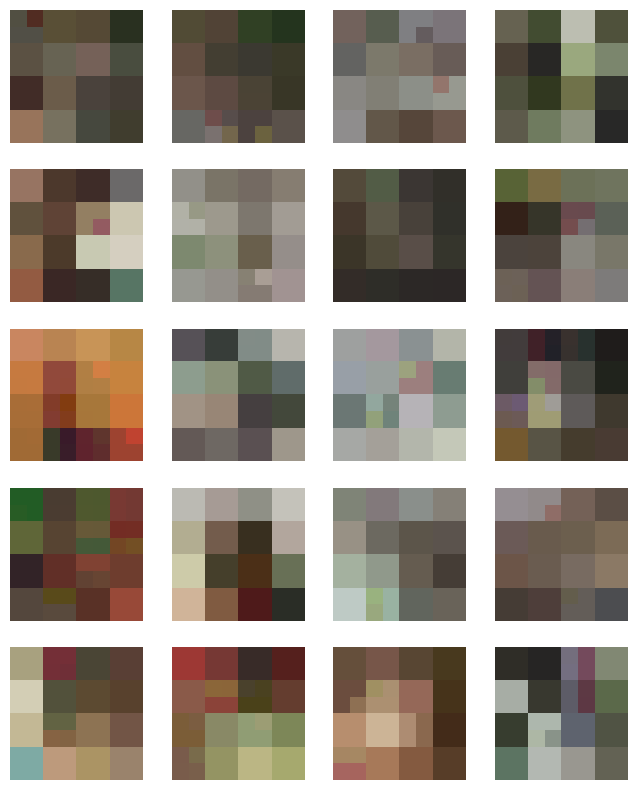

Batch: 3525 / 31250
Alpha: 0.376
D Loss: R: 7.041169 F: -8.498516 GP: 0.138341
G Loss: 8.903420
Found 17432 files belonging to 1 classes.


2024-05-07 04:17:17.290399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 04:17:17.290687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17432]
	 [[{{node Placeholder/_0}}]]
2024-05-07 04:17:17.307289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17

Batch: 3550 / 31250
Alpha: 0.37866666666666665
D Loss: R: 7.755779 F: -8.749019 GP: 0.084315
G Loss: 8.166311
Batch: 3575 / 31250
Alpha: 0.38133333333333336
D Loss: R: 7.432866 F: -8.510422 GP: 0.141410
G Loss: 8.831072
Batch: 3600 / 31250
Alpha: 0.384
D Loss: R: 7.486979 F: -8.585027 GP: 0.115723
G Loss: 9.158716
Batch: 3625 / 31250
Alpha: 0.38666666666666666
D Loss: R: 7.431559 F: -8.256037 GP: 0.042177
G Loss: 8.856984
Batch: 3650 / 31250
Alpha: 0.3893333333333333
D Loss: R: 8.277529 F: -9.242441 GP: 0.072643
G Loss: 9.729934
Batch: 3675 / 31250
Alpha: 0.392
D Loss: R: 7.600662 F: -8.654829 GP: 0.257400
G Loss: 9.017250


In [ ]:
train_progan(gan, 8,
             checkpoint_path=base_dir+'8x8/',
             transition_kimg=600,
             total_kimg=2000)

In [66]:
gan = ProGAN()
gan.load(8, base_dir+'8x8/')